# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x_10000.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if (pred[i,0] - y[i,0] and pred[i,1] - y[i,1]) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/125, Loss: 0.3719
Epoch 1/200, Iteration 2/125, Loss: 1.4052
Epoch 1/200, Iteration 3/125, Loss: 2.0045
Epoch 1/200, Iteration 4/125, Loss: 1.0231
Epoch 1/200, Iteration 5/125, Loss: 0.4543
Epoch 1/200, Iteration 6/125, Loss: 0.6844
Epoch 1/200, Iteration 7/125, Loss: 0.5306
Epoch 1/200, Iteration 8/125, Loss: 0.2476
Epoch 1/200, Iteration 9/125, Loss: 0.3729
Epoch 1/200, Iteration 10/125, Loss: 0.3864
Epoch 1/200, Iteration 11/125, Loss: 0.3569
Epoch 1/200, Iteration 12/125, Loss: 0.3223
Epoch 1/200, Iteration 13/125, Loss: 0.2640
Epoch 1/200, Iteration 14/125, Loss: 0.1700
Epoch 1/200, Iteration 15/125, Loss: 0.2188
Epoch 1/200, Iteration 16/125, Loss: 0.1551
Epoch 1/200, Iteration 17/125, Loss: 0.2062
Epoch 1/200, Iteration 18/125, Loss: 0.2282
Epoch 1/200, Iteration 19/125, Loss: 0.1481
Epoch 1/200, Iteration 20/125, Loss: 0.1643
Epoch 1/200, Iteration 21/125, Loss: 0.1115
Epoch 1/200, Iteration 22/125, Loss: 0.1517
Epoch 1/200, Iteration 23/125, Loss: 0.14

Epoch 2/200, Iteration 75/125, Loss: 0.0700
Epoch 2/200, Iteration 76/125, Loss: 0.0616
Epoch 2/200, Iteration 77/125, Loss: 0.0718
Epoch 2/200, Iteration 78/125, Loss: 0.0833
Epoch 2/200, Iteration 79/125, Loss: 0.0557
Epoch 2/200, Iteration 80/125, Loss: 0.0600
Epoch 2/200, Iteration 81/125, Loss: 0.0537
Epoch 2/200, Iteration 82/125, Loss: 0.0455
Epoch 2/200, Iteration 83/125, Loss: 0.0504
Epoch 2/200, Iteration 84/125, Loss: 0.0575
Epoch 2/200, Iteration 85/125, Loss: 0.0361
Epoch 2/200, Iteration 86/125, Loss: 0.0408
Epoch 2/200, Iteration 87/125, Loss: 0.0601
Epoch 2/200, Iteration 88/125, Loss: 0.0447
Epoch 2/200, Iteration 89/125, Loss: 0.0473
Epoch 2/200, Iteration 90/125, Loss: 0.0395
Epoch 2/200, Iteration 91/125, Loss: 0.0444
Epoch 2/200, Iteration 92/125, Loss: 0.0429
Epoch 2/200, Iteration 93/125, Loss: 0.0424
Epoch 2/200, Iteration 94/125, Loss: 0.0356
Epoch 2/200, Iteration 95/125, Loss: 0.0442
Epoch 2/200, Iteration 96/125, Loss: 0.0457
Epoch 2/200, Iteration 97/125, L

Epoch 4/200, Iteration 20/125, Loss: 0.0670
Epoch 4/200, Iteration 21/125, Loss: 0.0385
Epoch 4/200, Iteration 22/125, Loss: 0.0292
Epoch 4/200, Iteration 23/125, Loss: 0.0505
Epoch 4/200, Iteration 24/125, Loss: 0.0619
Epoch 4/200, Iteration 25/125, Loss: 0.0444
Epoch 4/200, Iteration 26/125, Loss: 0.0458
Epoch 4/200, Iteration 27/125, Loss: 0.0490
Epoch 4/200, Iteration 28/125, Loss: 0.0545
Epoch 4/200, Iteration 29/125, Loss: 0.0426
Epoch 4/200, Iteration 30/125, Loss: 0.0341
Epoch 4/200, Iteration 31/125, Loss: 0.0261
Epoch 4/200, Iteration 32/125, Loss: 0.0337
Epoch 4/200, Iteration 33/125, Loss: 0.0437
Epoch 4/200, Iteration 34/125, Loss: 0.0342
Epoch 4/200, Iteration 35/125, Loss: 0.0448
Epoch 4/200, Iteration 36/125, Loss: 0.0341
Epoch 4/200, Iteration 37/125, Loss: 0.0399
Epoch 4/200, Iteration 38/125, Loss: 0.0380
Epoch 4/200, Iteration 39/125, Loss: 0.0496
Epoch 4/200, Iteration 40/125, Loss: 0.0553
Epoch 4/200, Iteration 41/125, Loss: 0.0493
Epoch 4/200, Iteration 42/125, L

Epoch 5/200, Iteration 80/125, Loss: 0.0611
Epoch 5/200, Iteration 81/125, Loss: 0.0307
Epoch 5/200, Iteration 82/125, Loss: 0.0385
Epoch 5/200, Iteration 83/125, Loss: 0.0381
Epoch 5/200, Iteration 84/125, Loss: 0.0367
Epoch 5/200, Iteration 85/125, Loss: 0.0369
Epoch 5/200, Iteration 86/125, Loss: 0.0468
Epoch 5/200, Iteration 87/125, Loss: 0.0643
Epoch 5/200, Iteration 88/125, Loss: 0.0432
Epoch 5/200, Iteration 89/125, Loss: 0.0410
Epoch 5/200, Iteration 90/125, Loss: 0.0331
Epoch 5/200, Iteration 91/125, Loss: 0.0524
Epoch 5/200, Iteration 92/125, Loss: 0.0503
Epoch 5/200, Iteration 93/125, Loss: 0.0410
Epoch 5/200, Iteration 94/125, Loss: 0.0464
Epoch 5/200, Iteration 95/125, Loss: 0.0336
Epoch 5/200, Iteration 96/125, Loss: 0.0401
Epoch 5/200, Iteration 97/125, Loss: 0.0452
Epoch 5/200, Iteration 98/125, Loss: 0.0407
Epoch 5/200, Iteration 99/125, Loss: 0.0401
Epoch 5/200, Iteration 100/125, Loss: 0.0308
Epoch 5/200, Iteration 101/125, Loss: 0.0393
Epoch 5/200, Iteration 102/125

Epoch 7/200, Iteration 20/125, Loss: 0.0372
Epoch 7/200, Iteration 21/125, Loss: 0.0543
Epoch 7/200, Iteration 22/125, Loss: 0.0508
Epoch 7/200, Iteration 23/125, Loss: 0.0391
Epoch 7/200, Iteration 24/125, Loss: 0.0320
Epoch 7/200, Iteration 25/125, Loss: 0.0260
Epoch 7/200, Iteration 26/125, Loss: 0.0777
Epoch 7/200, Iteration 27/125, Loss: 0.0575
Epoch 7/200, Iteration 28/125, Loss: 0.0457
Epoch 7/200, Iteration 29/125, Loss: 0.0510
Epoch 7/200, Iteration 30/125, Loss: 0.0525
Epoch 7/200, Iteration 31/125, Loss: 0.0613
Epoch 7/200, Iteration 32/125, Loss: 0.0497
Epoch 7/200, Iteration 33/125, Loss: 0.0696
Epoch 7/200, Iteration 34/125, Loss: 0.0498
Epoch 7/200, Iteration 35/125, Loss: 0.0445
Epoch 7/200, Iteration 36/125, Loss: 0.0307
Epoch 7/200, Iteration 37/125, Loss: 0.0413
Epoch 7/200, Iteration 38/125, Loss: 0.0377
Epoch 7/200, Iteration 39/125, Loss: 0.0445
Epoch 7/200, Iteration 40/125, Loss: 0.0630
Epoch 7/200, Iteration 41/125, Loss: 0.0451
Epoch 7/200, Iteration 42/125, L

Epoch 8/200, Iteration 79/125, Loss: 0.0276
Epoch 8/200, Iteration 80/125, Loss: 0.0358
Epoch 8/200, Iteration 81/125, Loss: 0.0369
Epoch 8/200, Iteration 82/125, Loss: 0.0458
Epoch 8/200, Iteration 83/125, Loss: 0.0541
Epoch 8/200, Iteration 84/125, Loss: 0.0557
Epoch 8/200, Iteration 85/125, Loss: 0.0597
Epoch 8/200, Iteration 86/125, Loss: 0.0298
Epoch 8/200, Iteration 87/125, Loss: 0.0319
Epoch 8/200, Iteration 88/125, Loss: 0.0498
Epoch 8/200, Iteration 89/125, Loss: 0.0485
Epoch 8/200, Iteration 90/125, Loss: 0.0398
Epoch 8/200, Iteration 91/125, Loss: 0.0287
Epoch 8/200, Iteration 92/125, Loss: 0.0410
Epoch 8/200, Iteration 93/125, Loss: 0.0774
Epoch 8/200, Iteration 94/125, Loss: 0.0506
Epoch 8/200, Iteration 95/125, Loss: 0.0371
Epoch 8/200, Iteration 96/125, Loss: 0.0590
Epoch 8/200, Iteration 97/125, Loss: 0.0679
Epoch 8/200, Iteration 98/125, Loss: 0.0605
Epoch 8/200, Iteration 99/125, Loss: 0.0538
Epoch 8/200, Iteration 100/125, Loss: 0.0433
Epoch 8/200, Iteration 101/125,

Epoch 10/200, Iteration 20/125, Loss: 0.0386
Epoch 10/200, Iteration 21/125, Loss: 0.0367
Epoch 10/200, Iteration 22/125, Loss: 0.0652
Epoch 10/200, Iteration 23/125, Loss: 0.0400
Epoch 10/200, Iteration 24/125, Loss: 0.0420
Epoch 10/200, Iteration 25/125, Loss: 0.0361
Epoch 10/200, Iteration 26/125, Loss: 0.0450
Epoch 10/200, Iteration 27/125, Loss: 0.0366
Epoch 10/200, Iteration 28/125, Loss: 0.0370
Epoch 10/200, Iteration 29/125, Loss: 0.0386
Epoch 10/200, Iteration 30/125, Loss: 0.0243
Epoch 10/200, Iteration 31/125, Loss: 0.0407
Epoch 10/200, Iteration 32/125, Loss: 0.0497
Epoch 10/200, Iteration 33/125, Loss: 0.0312
Epoch 10/200, Iteration 34/125, Loss: 0.0342
Epoch 10/200, Iteration 35/125, Loss: 0.0254
Epoch 10/200, Iteration 36/125, Loss: 0.0252
Epoch 10/200, Iteration 37/125, Loss: 0.0265
Epoch 10/200, Iteration 38/125, Loss: 0.0355
Epoch 10/200, Iteration 39/125, Loss: 0.0431
Epoch 10/200, Iteration 40/125, Loss: 0.0389
Epoch 10/200, Iteration 41/125, Loss: 0.0451
Epoch 10/2

Epoch 11/200, Iteration 76/125, Loss: 0.0665
Epoch 11/200, Iteration 77/125, Loss: 0.0342
Epoch 11/200, Iteration 78/125, Loss: 0.0288
Epoch 11/200, Iteration 79/125, Loss: 0.0320
Epoch 11/200, Iteration 80/125, Loss: 0.0457
Epoch 11/200, Iteration 81/125, Loss: 0.0445
Epoch 11/200, Iteration 82/125, Loss: 0.0231
Epoch 11/200, Iteration 83/125, Loss: 0.0557
Epoch 11/200, Iteration 84/125, Loss: 0.0493
Epoch 11/200, Iteration 85/125, Loss: 0.0352
Epoch 11/200, Iteration 86/125, Loss: 0.0306
Epoch 11/200, Iteration 87/125, Loss: 0.0304
Epoch 11/200, Iteration 88/125, Loss: 0.0345
Epoch 11/200, Iteration 89/125, Loss: 0.0228
Epoch 11/200, Iteration 90/125, Loss: 0.0200
Epoch 11/200, Iteration 91/125, Loss: 0.0237
Epoch 11/200, Iteration 92/125, Loss: 0.0302
Epoch 11/200, Iteration 93/125, Loss: 0.0300
Epoch 11/200, Iteration 94/125, Loss: 0.0365
Epoch 11/200, Iteration 95/125, Loss: 0.0437
Epoch 11/200, Iteration 96/125, Loss: 0.0281
Epoch 11/200, Iteration 97/125, Loss: 0.0360
Epoch 11/2

Epoch 13/200, Iteration 19/125, Loss: 0.0243
Epoch 13/200, Iteration 20/125, Loss: 0.0314
Epoch 13/200, Iteration 21/125, Loss: 0.0261
Epoch 13/200, Iteration 22/125, Loss: 0.0278
Epoch 13/200, Iteration 23/125, Loss: 0.0191
Epoch 13/200, Iteration 24/125, Loss: 0.0222
Epoch 13/200, Iteration 25/125, Loss: 0.0286
Epoch 13/200, Iteration 26/125, Loss: 0.0186
Epoch 13/200, Iteration 27/125, Loss: 0.0255
Epoch 13/200, Iteration 28/125, Loss: 0.0412
Epoch 13/200, Iteration 29/125, Loss: 0.0372
Epoch 13/200, Iteration 30/125, Loss: 0.0411
Epoch 13/200, Iteration 31/125, Loss: 0.0309
Epoch 13/200, Iteration 32/125, Loss: 0.0175
Epoch 13/200, Iteration 33/125, Loss: 0.0326
Epoch 13/200, Iteration 34/125, Loss: 0.0317
Epoch 13/200, Iteration 35/125, Loss: 0.0361
Epoch 13/200, Iteration 36/125, Loss: 0.0344
Epoch 13/200, Iteration 37/125, Loss: 0.0362
Epoch 13/200, Iteration 38/125, Loss: 0.0311
Epoch 13/200, Iteration 39/125, Loss: 0.0200
Epoch 13/200, Iteration 40/125, Loss: 0.0241
Epoch 13/2

Epoch 14/200, Iteration 77/125, Loss: 0.0276
Epoch 14/200, Iteration 78/125, Loss: 0.0310
Epoch 14/200, Iteration 79/125, Loss: 0.0186
Epoch 14/200, Iteration 80/125, Loss: 0.0321
Epoch 14/200, Iteration 81/125, Loss: 0.0241
Epoch 14/200, Iteration 82/125, Loss: 0.0286
Epoch 14/200, Iteration 83/125, Loss: 0.0244
Epoch 14/200, Iteration 84/125, Loss: 0.0250
Epoch 14/200, Iteration 85/125, Loss: 0.0248
Epoch 14/200, Iteration 86/125, Loss: 0.0382
Epoch 14/200, Iteration 87/125, Loss: 0.0350
Epoch 14/200, Iteration 88/125, Loss: 0.0203
Epoch 14/200, Iteration 89/125, Loss: 0.0441
Epoch 14/200, Iteration 90/125, Loss: 0.0520
Epoch 14/200, Iteration 91/125, Loss: 0.0515
Epoch 14/200, Iteration 92/125, Loss: 0.0434
Epoch 14/200, Iteration 93/125, Loss: 0.0296
Epoch 14/200, Iteration 94/125, Loss: 0.0287
Epoch 14/200, Iteration 95/125, Loss: 0.0374
Epoch 14/200, Iteration 96/125, Loss: 0.0528
Epoch 14/200, Iteration 97/125, Loss: 0.0293
Epoch 14/200, Iteration 98/125, Loss: 0.0154
Epoch 14/2

Epoch 16/200, Iteration 19/125, Loss: 0.0300
Epoch 16/200, Iteration 20/125, Loss: 0.0299
Epoch 16/200, Iteration 21/125, Loss: 0.0386
Epoch 16/200, Iteration 22/125, Loss: 0.0226
Epoch 16/200, Iteration 23/125, Loss: 0.0241
Epoch 16/200, Iteration 24/125, Loss: 0.0391
Epoch 16/200, Iteration 25/125, Loss: 0.0198
Epoch 16/200, Iteration 26/125, Loss: 0.0326
Epoch 16/200, Iteration 27/125, Loss: 0.0131
Epoch 16/200, Iteration 28/125, Loss: 0.0391
Epoch 16/200, Iteration 29/125, Loss: 0.0361
Epoch 16/200, Iteration 30/125, Loss: 0.0256
Epoch 16/200, Iteration 31/125, Loss: 0.0275
Epoch 16/200, Iteration 32/125, Loss: 0.0335
Epoch 16/200, Iteration 33/125, Loss: 0.0220
Epoch 16/200, Iteration 34/125, Loss: 0.0286
Epoch 16/200, Iteration 35/125, Loss: 0.0322
Epoch 16/200, Iteration 36/125, Loss: 0.0280
Epoch 16/200, Iteration 37/125, Loss: 0.0378
Epoch 16/200, Iteration 38/125, Loss: 0.0195
Epoch 16/200, Iteration 39/125, Loss: 0.0447
Epoch 16/200, Iteration 40/125, Loss: 0.0676
Epoch 16/2

Epoch 17/200, Iteration 80/125, Loss: 0.0198
Epoch 17/200, Iteration 81/125, Loss: 0.0215
Epoch 17/200, Iteration 82/125, Loss: 0.0260
Epoch 17/200, Iteration 83/125, Loss: 0.0234
Epoch 17/200, Iteration 84/125, Loss: 0.0249
Epoch 17/200, Iteration 85/125, Loss: 0.0365
Epoch 17/200, Iteration 86/125, Loss: 0.0215
Epoch 17/200, Iteration 87/125, Loss: 0.0244
Epoch 17/200, Iteration 88/125, Loss: 0.0380
Epoch 17/200, Iteration 89/125, Loss: 0.0253
Epoch 17/200, Iteration 90/125, Loss: 0.0273
Epoch 17/200, Iteration 91/125, Loss: 0.0294
Epoch 17/200, Iteration 92/125, Loss: 0.0332
Epoch 17/200, Iteration 93/125, Loss: 0.0260
Epoch 17/200, Iteration 94/125, Loss: 0.0324
Epoch 17/200, Iteration 95/125, Loss: 0.0230
Epoch 17/200, Iteration 96/125, Loss: 0.0224
Epoch 17/200, Iteration 97/125, Loss: 0.0428
Epoch 17/200, Iteration 98/125, Loss: 0.0382
Epoch 17/200, Iteration 99/125, Loss: 0.0317
Epoch 17/200, Iteration 100/125, Loss: 0.0277
Epoch 17/200, Iteration 101/125, Loss: 0.0310
Epoch 17

Epoch 19/200, Iteration 20/125, Loss: 0.0460
Epoch 19/200, Iteration 21/125, Loss: 0.0377
Epoch 19/200, Iteration 22/125, Loss: 0.0245
Epoch 19/200, Iteration 23/125, Loss: 0.0628
Epoch 19/200, Iteration 24/125, Loss: 0.0225
Epoch 19/200, Iteration 25/125, Loss: 0.0337
Epoch 19/200, Iteration 26/125, Loss: 0.0298
Epoch 19/200, Iteration 27/125, Loss: 0.0307
Epoch 19/200, Iteration 28/125, Loss: 0.0591
Epoch 19/200, Iteration 29/125, Loss: 0.0620
Epoch 19/200, Iteration 30/125, Loss: 0.0293
Epoch 19/200, Iteration 31/125, Loss: 0.0218
Epoch 19/200, Iteration 32/125, Loss: 0.0349
Epoch 19/200, Iteration 33/125, Loss: 0.0441
Epoch 19/200, Iteration 34/125, Loss: 0.0423
Epoch 19/200, Iteration 35/125, Loss: 0.0408
Epoch 19/200, Iteration 36/125, Loss: 0.0182
Epoch 19/200, Iteration 37/125, Loss: 0.0428
Epoch 19/200, Iteration 38/125, Loss: 0.0483
Epoch 19/200, Iteration 39/125, Loss: 0.0414
Epoch 19/200, Iteration 40/125, Loss: 0.0174
Epoch 19/200, Iteration 41/125, Loss: 0.0256
Epoch 19/2

Epoch 20/200, Iteration 75/125, Loss: 0.0194
Epoch 20/200, Iteration 76/125, Loss: 0.0321
Epoch 20/200, Iteration 77/125, Loss: 0.0361
Epoch 20/200, Iteration 78/125, Loss: 0.0325
Epoch 20/200, Iteration 79/125, Loss: 0.0287
Epoch 20/200, Iteration 80/125, Loss: 0.0414
Epoch 20/200, Iteration 81/125, Loss: 0.0222
Epoch 20/200, Iteration 82/125, Loss: 0.0279
Epoch 20/200, Iteration 83/125, Loss: 0.0426
Epoch 20/200, Iteration 84/125, Loss: 0.0439
Epoch 20/200, Iteration 85/125, Loss: 0.0440
Epoch 20/200, Iteration 86/125, Loss: 0.0412
Epoch 20/200, Iteration 87/125, Loss: 0.0514
Epoch 20/200, Iteration 88/125, Loss: 0.0454
Epoch 20/200, Iteration 89/125, Loss: 0.0342
Epoch 20/200, Iteration 90/125, Loss: 0.0427
Epoch 20/200, Iteration 91/125, Loss: 0.0249
Epoch 20/200, Iteration 92/125, Loss: 0.0381
Epoch 20/200, Iteration 93/125, Loss: 0.0201
Epoch 20/200, Iteration 94/125, Loss: 0.0350
Epoch 20/200, Iteration 95/125, Loss: 0.0438
Epoch 20/200, Iteration 96/125, Loss: 0.0557
Epoch 20/2

Epoch 22/200, Iteration 20/125, Loss: 0.0262
Epoch 22/200, Iteration 21/125, Loss: 0.0188
Epoch 22/200, Iteration 22/125, Loss: 0.0165
Epoch 22/200, Iteration 23/125, Loss: 0.0490
Epoch 22/200, Iteration 24/125, Loss: 0.0193
Epoch 22/200, Iteration 25/125, Loss: 0.0367
Epoch 22/200, Iteration 26/125, Loss: 0.0176
Epoch 22/200, Iteration 27/125, Loss: 0.0224
Epoch 22/200, Iteration 28/125, Loss: 0.0208
Epoch 22/200, Iteration 29/125, Loss: 0.0178
Epoch 22/200, Iteration 30/125, Loss: 0.0242
Epoch 22/200, Iteration 31/125, Loss: 0.0204
Epoch 22/200, Iteration 32/125, Loss: 0.0247
Epoch 22/200, Iteration 33/125, Loss: 0.0214
Epoch 22/200, Iteration 34/125, Loss: 0.0313
Epoch 22/200, Iteration 35/125, Loss: 0.0288
Epoch 22/200, Iteration 36/125, Loss: 0.0230
Epoch 22/200, Iteration 37/125, Loss: 0.0344
Epoch 22/200, Iteration 38/125, Loss: 0.0342
Epoch 22/200, Iteration 39/125, Loss: 0.0285
Epoch 22/200, Iteration 40/125, Loss: 0.0280
Epoch 22/200, Iteration 41/125, Loss: 0.0297
Epoch 22/2

Epoch 23/200, Iteration 75/125, Loss: 0.0267
Epoch 23/200, Iteration 76/125, Loss: 0.0310
Epoch 23/200, Iteration 77/125, Loss: 0.0150
Epoch 23/200, Iteration 78/125, Loss: 0.0194
Epoch 23/200, Iteration 79/125, Loss: 0.0161
Epoch 23/200, Iteration 80/125, Loss: 0.0344
Epoch 23/200, Iteration 81/125, Loss: 0.0258
Epoch 23/200, Iteration 82/125, Loss: 0.0277
Epoch 23/200, Iteration 83/125, Loss: 0.0181
Epoch 23/200, Iteration 84/125, Loss: 0.0225
Epoch 23/200, Iteration 85/125, Loss: 0.0269
Epoch 23/200, Iteration 86/125, Loss: 0.0204
Epoch 23/200, Iteration 87/125, Loss: 0.0315
Epoch 23/200, Iteration 88/125, Loss: 0.0284
Epoch 23/200, Iteration 89/125, Loss: 0.0298
Epoch 23/200, Iteration 90/125, Loss: 0.0239
Epoch 23/200, Iteration 91/125, Loss: 0.0169
Epoch 23/200, Iteration 92/125, Loss: 0.0246
Epoch 23/200, Iteration 93/125, Loss: 0.0443
Epoch 23/200, Iteration 94/125, Loss: 0.0388
Epoch 23/200, Iteration 95/125, Loss: 0.0299
Epoch 23/200, Iteration 96/125, Loss: 0.0440
Epoch 23/2

Epoch 25/200, Iteration 19/125, Loss: 0.0331
Epoch 25/200, Iteration 20/125, Loss: 0.0346
Epoch 25/200, Iteration 21/125, Loss: 0.0261
Epoch 25/200, Iteration 22/125, Loss: 0.0209
Epoch 25/200, Iteration 23/125, Loss: 0.0353
Epoch 25/200, Iteration 24/125, Loss: 0.0343
Epoch 25/200, Iteration 25/125, Loss: 0.0606
Epoch 25/200, Iteration 26/125, Loss: 0.0271
Epoch 25/200, Iteration 27/125, Loss: 0.0234
Epoch 25/200, Iteration 28/125, Loss: 0.0217
Epoch 25/200, Iteration 29/125, Loss: 0.0374
Epoch 25/200, Iteration 30/125, Loss: 0.0518
Epoch 25/200, Iteration 31/125, Loss: 0.0328
Epoch 25/200, Iteration 32/125, Loss: 0.0384
Epoch 25/200, Iteration 33/125, Loss: 0.0440
Epoch 25/200, Iteration 34/125, Loss: 0.0297
Epoch 25/200, Iteration 35/125, Loss: 0.0431
Epoch 25/200, Iteration 36/125, Loss: 0.0434
Epoch 25/200, Iteration 37/125, Loss: 0.0315
Epoch 25/200, Iteration 38/125, Loss: 0.0309
Epoch 25/200, Iteration 39/125, Loss: 0.0415
Epoch 25/200, Iteration 40/125, Loss: 0.0340
Epoch 25/2

Epoch 26/200, Iteration 78/125, Loss: 0.0300
Epoch 26/200, Iteration 79/125, Loss: 0.0250
Epoch 26/200, Iteration 80/125, Loss: 0.0288
Epoch 26/200, Iteration 81/125, Loss: 0.0333
Epoch 26/200, Iteration 82/125, Loss: 0.0269
Epoch 26/200, Iteration 83/125, Loss: 0.0202
Epoch 26/200, Iteration 84/125, Loss: 0.0378
Epoch 26/200, Iteration 85/125, Loss: 0.0332
Epoch 26/200, Iteration 86/125, Loss: 0.0425
Epoch 26/200, Iteration 87/125, Loss: 0.0381
Epoch 26/200, Iteration 88/125, Loss: 0.0258
Epoch 26/200, Iteration 89/125, Loss: 0.0403
Epoch 26/200, Iteration 90/125, Loss: 0.0225
Epoch 26/200, Iteration 91/125, Loss: 0.0270
Epoch 26/200, Iteration 92/125, Loss: 0.0337
Epoch 26/200, Iteration 93/125, Loss: 0.0284
Epoch 26/200, Iteration 94/125, Loss: 0.0224
Epoch 26/200, Iteration 95/125, Loss: 0.0267
Epoch 26/200, Iteration 96/125, Loss: 0.0281
Epoch 26/200, Iteration 97/125, Loss: 0.0215
Epoch 26/200, Iteration 98/125, Loss: 0.0248
Epoch 26/200, Iteration 99/125, Loss: 0.0319
Epoch 26/2

Epoch 28/200, Iteration 20/125, Loss: 0.0238
Epoch 28/200, Iteration 21/125, Loss: 0.0243
Epoch 28/200, Iteration 22/125, Loss: 0.0305
Epoch 28/200, Iteration 23/125, Loss: 0.0370
Epoch 28/200, Iteration 24/125, Loss: 0.0406
Epoch 28/200, Iteration 25/125, Loss: 0.0338
Epoch 28/200, Iteration 26/125, Loss: 0.0247
Epoch 28/200, Iteration 27/125, Loss: 0.0278
Epoch 28/200, Iteration 28/125, Loss: 0.0302
Epoch 28/200, Iteration 29/125, Loss: 0.0220
Epoch 28/200, Iteration 30/125, Loss: 0.0539
Epoch 28/200, Iteration 31/125, Loss: 0.0345
Epoch 28/200, Iteration 32/125, Loss: 0.0430
Epoch 28/200, Iteration 33/125, Loss: 0.0342
Epoch 28/200, Iteration 34/125, Loss: 0.0304
Epoch 28/200, Iteration 35/125, Loss: 0.0232
Epoch 28/200, Iteration 36/125, Loss: 0.0462
Epoch 28/200, Iteration 37/125, Loss: 0.0368
Epoch 28/200, Iteration 38/125, Loss: 0.0268
Epoch 28/200, Iteration 39/125, Loss: 0.0317
Epoch 28/200, Iteration 40/125, Loss: 0.0204
Epoch 28/200, Iteration 41/125, Loss: 0.0401
Epoch 28/2

Epoch 29/200, Iteration 84/125, Loss: 0.0183
Epoch 29/200, Iteration 85/125, Loss: 0.0180
Epoch 29/200, Iteration 86/125, Loss: 0.0250
Epoch 29/200, Iteration 87/125, Loss: 0.0350
Epoch 29/200, Iteration 88/125, Loss: 0.0140
Epoch 29/200, Iteration 89/125, Loss: 0.0209
Epoch 29/200, Iteration 90/125, Loss: 0.0180
Epoch 29/200, Iteration 91/125, Loss: 0.0160
Epoch 29/200, Iteration 92/125, Loss: 0.0230
Epoch 29/200, Iteration 93/125, Loss: 0.0446
Epoch 29/200, Iteration 94/125, Loss: 0.0309
Epoch 29/200, Iteration 95/125, Loss: 0.0402
Epoch 29/200, Iteration 96/125, Loss: 0.0137
Epoch 29/200, Iteration 97/125, Loss: 0.0337
Epoch 29/200, Iteration 98/125, Loss: 0.0234
Epoch 29/200, Iteration 99/125, Loss: 0.0374
Epoch 29/200, Iteration 100/125, Loss: 0.0275
Epoch 29/200, Iteration 101/125, Loss: 0.0334
Epoch 29/200, Iteration 102/125, Loss: 0.0376
Epoch 29/200, Iteration 103/125, Loss: 0.0183
Epoch 29/200, Iteration 104/125, Loss: 0.0391
Epoch 29/200, Iteration 105/125, Loss: 0.0184
Epoc

Epoch 31/200, Iteration 21/125, Loss: 0.0328
Epoch 31/200, Iteration 22/125, Loss: 0.0251
Epoch 31/200, Iteration 23/125, Loss: 0.0416
Epoch 31/200, Iteration 24/125, Loss: 0.0183
Epoch 31/200, Iteration 25/125, Loss: 0.0237
Epoch 31/200, Iteration 26/125, Loss: 0.0228
Epoch 31/200, Iteration 27/125, Loss: 0.0189
Epoch 31/200, Iteration 28/125, Loss: 0.0310
Epoch 31/200, Iteration 29/125, Loss: 0.0253
Epoch 31/200, Iteration 30/125, Loss: 0.0231
Epoch 31/200, Iteration 31/125, Loss: 0.0273
Epoch 31/200, Iteration 32/125, Loss: 0.0298
Epoch 31/200, Iteration 33/125, Loss: 0.0220
Epoch 31/200, Iteration 34/125, Loss: 0.0248
Epoch 31/200, Iteration 35/125, Loss: 0.0441
Epoch 31/200, Iteration 36/125, Loss: 0.0274
Epoch 31/200, Iteration 37/125, Loss: 0.0300
Epoch 31/200, Iteration 38/125, Loss: 0.0664
Epoch 31/200, Iteration 39/125, Loss: 0.0269
Epoch 31/200, Iteration 40/125, Loss: 0.0367
Epoch 31/200, Iteration 41/125, Loss: 0.0274
Epoch 31/200, Iteration 42/125, Loss: 0.0247
Epoch 31/2

Epoch 32/200, Iteration 81/125, Loss: 0.0194
Epoch 32/200, Iteration 82/125, Loss: 0.0430
Epoch 32/200, Iteration 83/125, Loss: 0.0140
Epoch 32/200, Iteration 84/125, Loss: 0.0304
Epoch 32/200, Iteration 85/125, Loss: 0.0235
Epoch 32/200, Iteration 86/125, Loss: 0.0406
Epoch 32/200, Iteration 87/125, Loss: 0.0219
Epoch 32/200, Iteration 88/125, Loss: 0.0247
Epoch 32/200, Iteration 89/125, Loss: 0.0167
Epoch 32/200, Iteration 90/125, Loss: 0.0289
Epoch 32/200, Iteration 91/125, Loss: 0.0146
Epoch 32/200, Iteration 92/125, Loss: 0.0196
Epoch 32/200, Iteration 93/125, Loss: 0.0188
Epoch 32/200, Iteration 94/125, Loss: 0.0297
Epoch 32/200, Iteration 95/125, Loss: 0.0342
Epoch 32/200, Iteration 96/125, Loss: 0.0157
Epoch 32/200, Iteration 97/125, Loss: 0.0171
Epoch 32/200, Iteration 98/125, Loss: 0.0445
Epoch 32/200, Iteration 99/125, Loss: 0.0240
Epoch 32/200, Iteration 100/125, Loss: 0.0192
Epoch 32/200, Iteration 101/125, Loss: 0.0174
Epoch 32/200, Iteration 102/125, Loss: 0.0292
Epoch 3

Epoch 34/200, Iteration 20/125, Loss: 0.0270
Epoch 34/200, Iteration 21/125, Loss: 0.0591
Epoch 34/200, Iteration 22/125, Loss: 0.0456
Epoch 34/200, Iteration 23/125, Loss: 0.0306
Epoch 34/200, Iteration 24/125, Loss: 0.0325
Epoch 34/200, Iteration 25/125, Loss: 0.0492
Epoch 34/200, Iteration 26/125, Loss: 0.0416
Epoch 34/200, Iteration 27/125, Loss: 0.0387
Epoch 34/200, Iteration 28/125, Loss: 0.0381
Epoch 34/200, Iteration 29/125, Loss: 0.0411
Epoch 34/200, Iteration 30/125, Loss: 0.0208
Epoch 34/200, Iteration 31/125, Loss: 0.0247
Epoch 34/200, Iteration 32/125, Loss: 0.0314
Epoch 34/200, Iteration 33/125, Loss: 0.0563
Epoch 34/200, Iteration 34/125, Loss: 0.0214
Epoch 34/200, Iteration 35/125, Loss: 0.0414
Epoch 34/200, Iteration 36/125, Loss: 0.0336
Epoch 34/200, Iteration 37/125, Loss: 0.0223
Epoch 34/200, Iteration 38/125, Loss: 0.0244
Epoch 34/200, Iteration 39/125, Loss: 0.0301
Epoch 34/200, Iteration 40/125, Loss: 0.0643
Epoch 34/200, Iteration 41/125, Loss: 0.0249
Epoch 34/2

Epoch 35/200, Iteration 78/125, Loss: 0.0127
Epoch 35/200, Iteration 79/125, Loss: 0.0102
Epoch 35/200, Iteration 80/125, Loss: 0.0177
Epoch 35/200, Iteration 81/125, Loss: 0.0195
Epoch 35/200, Iteration 82/125, Loss: 0.0230
Epoch 35/200, Iteration 83/125, Loss: 0.0236
Epoch 35/200, Iteration 84/125, Loss: 0.0120
Epoch 35/200, Iteration 85/125, Loss: 0.0120
Epoch 35/200, Iteration 86/125, Loss: 0.0212
Epoch 35/200, Iteration 87/125, Loss: 0.0306
Epoch 35/200, Iteration 88/125, Loss: 0.0173
Epoch 35/200, Iteration 89/125, Loss: 0.0161
Epoch 35/200, Iteration 90/125, Loss: 0.0092
Epoch 35/200, Iteration 91/125, Loss: 0.0333
Epoch 35/200, Iteration 92/125, Loss: 0.0354
Epoch 35/200, Iteration 93/125, Loss: 0.0081
Epoch 35/200, Iteration 94/125, Loss: 0.0230
Epoch 35/200, Iteration 95/125, Loss: 0.0252
Epoch 35/200, Iteration 96/125, Loss: 0.0145
Epoch 35/200, Iteration 97/125, Loss: 0.0144
Epoch 35/200, Iteration 98/125, Loss: 0.0111
Epoch 35/200, Iteration 99/125, Loss: 0.0195
Epoch 35/2

Epoch 37/200, Iteration 20/125, Loss: 0.0222
Epoch 37/200, Iteration 21/125, Loss: 0.0218
Epoch 37/200, Iteration 22/125, Loss: 0.0155
Epoch 37/200, Iteration 23/125, Loss: 0.0122
Epoch 37/200, Iteration 24/125, Loss: 0.0159
Epoch 37/200, Iteration 25/125, Loss: 0.0245
Epoch 37/200, Iteration 26/125, Loss: 0.0295
Epoch 37/200, Iteration 27/125, Loss: 0.0145
Epoch 37/200, Iteration 28/125, Loss: 0.0226
Epoch 37/200, Iteration 29/125, Loss: 0.0298
Epoch 37/200, Iteration 30/125, Loss: 0.0200
Epoch 37/200, Iteration 31/125, Loss: 0.0138
Epoch 37/200, Iteration 32/125, Loss: 0.0232
Epoch 37/200, Iteration 33/125, Loss: 0.0268
Epoch 37/200, Iteration 34/125, Loss: 0.0147
Epoch 37/200, Iteration 35/125, Loss: 0.0108
Epoch 37/200, Iteration 36/125, Loss: 0.0132
Epoch 37/200, Iteration 37/125, Loss: 0.0119
Epoch 37/200, Iteration 38/125, Loss: 0.0179
Epoch 37/200, Iteration 39/125, Loss: 0.0108
Epoch 37/200, Iteration 40/125, Loss: 0.0199
Epoch 37/200, Iteration 41/125, Loss: 0.0081
Epoch 37/2

Epoch 38/200, Iteration 80/125, Loss: 0.0138
Epoch 38/200, Iteration 81/125, Loss: 0.0119
Epoch 38/200, Iteration 82/125, Loss: 0.0151
Epoch 38/200, Iteration 83/125, Loss: 0.0215
Epoch 38/200, Iteration 84/125, Loss: 0.0234
Epoch 38/200, Iteration 85/125, Loss: 0.0222
Epoch 38/200, Iteration 86/125, Loss: 0.0237
Epoch 38/200, Iteration 87/125, Loss: 0.0132
Epoch 38/200, Iteration 88/125, Loss: 0.0236
Epoch 38/200, Iteration 89/125, Loss: 0.0261
Epoch 38/200, Iteration 90/125, Loss: 0.0235
Epoch 38/200, Iteration 91/125, Loss: 0.0100
Epoch 38/200, Iteration 92/125, Loss: 0.0196
Epoch 38/200, Iteration 93/125, Loss: 0.0235
Epoch 38/200, Iteration 94/125, Loss: 0.0299
Epoch 38/200, Iteration 95/125, Loss: 0.0223
Epoch 38/200, Iteration 96/125, Loss: 0.0142
Epoch 38/200, Iteration 97/125, Loss: 0.0096
Epoch 38/200, Iteration 98/125, Loss: 0.0199
Epoch 38/200, Iteration 99/125, Loss: 0.0158
Epoch 38/200, Iteration 100/125, Loss: 0.0140
Epoch 38/200, Iteration 101/125, Loss: 0.0221
Epoch 38

Epoch 40/200, Iteration 20/125, Loss: 0.0292
Epoch 40/200, Iteration 21/125, Loss: 0.0143
Epoch 40/200, Iteration 22/125, Loss: 0.0261
Epoch 40/200, Iteration 23/125, Loss: 0.0246
Epoch 40/200, Iteration 24/125, Loss: 0.0122
Epoch 40/200, Iteration 25/125, Loss: 0.0142
Epoch 40/200, Iteration 26/125, Loss: 0.0205
Epoch 40/200, Iteration 27/125, Loss: 0.0125
Epoch 40/200, Iteration 28/125, Loss: 0.0156
Epoch 40/200, Iteration 29/125, Loss: 0.0219
Epoch 40/200, Iteration 30/125, Loss: 0.0136
Epoch 40/200, Iteration 31/125, Loss: 0.0154
Epoch 40/200, Iteration 32/125, Loss: 0.0166
Epoch 40/200, Iteration 33/125, Loss: 0.0171
Epoch 40/200, Iteration 34/125, Loss: 0.0117
Epoch 40/200, Iteration 35/125, Loss: 0.0093
Epoch 40/200, Iteration 36/125, Loss: 0.0171
Epoch 40/200, Iteration 37/125, Loss: 0.0126
Epoch 40/200, Iteration 38/125, Loss: 0.0166
Epoch 40/200, Iteration 39/125, Loss: 0.0208
Epoch 40/200, Iteration 40/125, Loss: 0.0103
Epoch 40/200, Iteration 41/125, Loss: 0.0097
Epoch 40/2

Epoch 41/200, Iteration 78/125, Loss: 0.0204
Epoch 41/200, Iteration 79/125, Loss: 0.0333
Epoch 41/200, Iteration 80/125, Loss: 0.0138
Epoch 41/200, Iteration 81/125, Loss: 0.0112
Epoch 41/200, Iteration 82/125, Loss: 0.0385
Epoch 41/200, Iteration 83/125, Loss: 0.0214
Epoch 41/200, Iteration 84/125, Loss: 0.0232
Epoch 41/200, Iteration 85/125, Loss: 0.0228
Epoch 41/200, Iteration 86/125, Loss: 0.0150
Epoch 41/200, Iteration 87/125, Loss: 0.0131
Epoch 41/200, Iteration 88/125, Loss: 0.0211
Epoch 41/200, Iteration 89/125, Loss: 0.0288
Epoch 41/200, Iteration 90/125, Loss: 0.0162
Epoch 41/200, Iteration 91/125, Loss: 0.0157
Epoch 41/200, Iteration 92/125, Loss: 0.0146
Epoch 41/200, Iteration 93/125, Loss: 0.0223
Epoch 41/200, Iteration 94/125, Loss: 0.0123
Epoch 41/200, Iteration 95/125, Loss: 0.0226
Epoch 41/200, Iteration 96/125, Loss: 0.0144
Epoch 41/200, Iteration 97/125, Loss: 0.0157
Epoch 41/200, Iteration 98/125, Loss: 0.0183
Epoch 41/200, Iteration 99/125, Loss: 0.0170
Epoch 41/2

Epoch 43/200, Iteration 19/125, Loss: 0.0231
Epoch 43/200, Iteration 20/125, Loss: 0.0147
Epoch 43/200, Iteration 21/125, Loss: 0.0168
Epoch 43/200, Iteration 22/125, Loss: 0.0174
Epoch 43/200, Iteration 23/125, Loss: 0.0123
Epoch 43/200, Iteration 24/125, Loss: 0.0111
Epoch 43/200, Iteration 25/125, Loss: 0.0079
Epoch 43/200, Iteration 26/125, Loss: 0.0188
Epoch 43/200, Iteration 27/125, Loss: 0.0155
Epoch 43/200, Iteration 28/125, Loss: 0.0166
Epoch 43/200, Iteration 29/125, Loss: 0.0186
Epoch 43/200, Iteration 30/125, Loss: 0.0225
Epoch 43/200, Iteration 31/125, Loss: 0.0108
Epoch 43/200, Iteration 32/125, Loss: 0.0462
Epoch 43/200, Iteration 33/125, Loss: 0.0194
Epoch 43/200, Iteration 34/125, Loss: 0.0157
Epoch 43/200, Iteration 35/125, Loss: 0.0097
Epoch 43/200, Iteration 36/125, Loss: 0.0423
Epoch 43/200, Iteration 37/125, Loss: 0.0140
Epoch 43/200, Iteration 38/125, Loss: 0.0228
Epoch 43/200, Iteration 39/125, Loss: 0.0230
Epoch 43/200, Iteration 40/125, Loss: 0.0234
Epoch 43/2

Epoch 44/200, Iteration 83/125, Loss: 0.0153
Epoch 44/200, Iteration 84/125, Loss: 0.0131
Epoch 44/200, Iteration 85/125, Loss: 0.0266
Epoch 44/200, Iteration 86/125, Loss: 0.0172
Epoch 44/200, Iteration 87/125, Loss: 0.0230
Epoch 44/200, Iteration 88/125, Loss: 0.0147
Epoch 44/200, Iteration 89/125, Loss: 0.0133
Epoch 44/200, Iteration 90/125, Loss: 0.0136
Epoch 44/200, Iteration 91/125, Loss: 0.0146
Epoch 44/200, Iteration 92/125, Loss: 0.0301
Epoch 44/200, Iteration 93/125, Loss: 0.0159
Epoch 44/200, Iteration 94/125, Loss: 0.0132
Epoch 44/200, Iteration 95/125, Loss: 0.0251
Epoch 44/200, Iteration 96/125, Loss: 0.0137
Epoch 44/200, Iteration 97/125, Loss: 0.0244
Epoch 44/200, Iteration 98/125, Loss: 0.0171
Epoch 44/200, Iteration 99/125, Loss: 0.0106
Epoch 44/200, Iteration 100/125, Loss: 0.0150
Epoch 44/200, Iteration 101/125, Loss: 0.0128
Epoch 44/200, Iteration 102/125, Loss: 0.0124
Epoch 44/200, Iteration 103/125, Loss: 0.0131
Epoch 44/200, Iteration 104/125, Loss: 0.0173
Epoch

Epoch 46/200, Iteration 19/125, Loss: 0.0135
Epoch 46/200, Iteration 20/125, Loss: 0.0282
Epoch 46/200, Iteration 21/125, Loss: 0.0108
Epoch 46/200, Iteration 22/125, Loss: 0.0185
Epoch 46/200, Iteration 23/125, Loss: 0.0097
Epoch 46/200, Iteration 24/125, Loss: 0.0118
Epoch 46/200, Iteration 25/125, Loss: 0.0244
Epoch 46/200, Iteration 26/125, Loss: 0.0092
Epoch 46/200, Iteration 27/125, Loss: 0.0061
Epoch 46/200, Iteration 28/125, Loss: 0.0167
Epoch 46/200, Iteration 29/125, Loss: 0.0226
Epoch 46/200, Iteration 30/125, Loss: 0.0144
Epoch 46/200, Iteration 31/125, Loss: 0.0188
Epoch 46/200, Iteration 32/125, Loss: 0.0121
Epoch 46/200, Iteration 33/125, Loss: 0.0271
Epoch 46/200, Iteration 34/125, Loss: 0.0144
Epoch 46/200, Iteration 35/125, Loss: 0.0219
Epoch 46/200, Iteration 36/125, Loss: 0.0235
Epoch 46/200, Iteration 37/125, Loss: 0.0361
Epoch 46/200, Iteration 38/125, Loss: 0.0270
Epoch 46/200, Iteration 39/125, Loss: 0.0236
Epoch 46/200, Iteration 40/125, Loss: 0.0248
Epoch 46/2

Epoch 47/200, Iteration 81/125, Loss: 0.0122
Epoch 47/200, Iteration 82/125, Loss: 0.0239
Epoch 47/200, Iteration 83/125, Loss: 0.0224
Epoch 47/200, Iteration 84/125, Loss: 0.0156
Epoch 47/200, Iteration 85/125, Loss: 0.0132
Epoch 47/200, Iteration 86/125, Loss: 0.0112
Epoch 47/200, Iteration 87/125, Loss: 0.0112
Epoch 47/200, Iteration 88/125, Loss: 0.0193
Epoch 47/200, Iteration 89/125, Loss: 0.0266
Epoch 47/200, Iteration 90/125, Loss: 0.0247
Epoch 47/200, Iteration 91/125, Loss: 0.0180
Epoch 47/200, Iteration 92/125, Loss: 0.0386
Epoch 47/200, Iteration 93/125, Loss: 0.0201
Epoch 47/200, Iteration 94/125, Loss: 0.0139
Epoch 47/200, Iteration 95/125, Loss: 0.0078
Epoch 47/200, Iteration 96/125, Loss: 0.0170
Epoch 47/200, Iteration 97/125, Loss: 0.0115
Epoch 47/200, Iteration 98/125, Loss: 0.0110
Epoch 47/200, Iteration 99/125, Loss: 0.0183
Epoch 47/200, Iteration 100/125, Loss: 0.0162
Epoch 47/200, Iteration 101/125, Loss: 0.0143
Epoch 47/200, Iteration 102/125, Loss: 0.0211
Epoch 4

Epoch 49/200, Iteration 21/125, Loss: 0.0130
Epoch 49/200, Iteration 22/125, Loss: 0.0152
Epoch 49/200, Iteration 23/125, Loss: 0.0306
Epoch 49/200, Iteration 24/125, Loss: 0.0147
Epoch 49/200, Iteration 25/125, Loss: 0.0219
Epoch 49/200, Iteration 26/125, Loss: 0.0097
Epoch 49/200, Iteration 27/125, Loss: 0.0176
Epoch 49/200, Iteration 28/125, Loss: 0.0107
Epoch 49/200, Iteration 29/125, Loss: 0.0211
Epoch 49/200, Iteration 30/125, Loss: 0.0097
Epoch 49/200, Iteration 31/125, Loss: 0.0144
Epoch 49/200, Iteration 32/125, Loss: 0.0162
Epoch 49/200, Iteration 33/125, Loss: 0.0072
Epoch 49/200, Iteration 34/125, Loss: 0.0108
Epoch 49/200, Iteration 35/125, Loss: 0.0238
Epoch 49/200, Iteration 36/125, Loss: 0.0147
Epoch 49/200, Iteration 37/125, Loss: 0.0345
Epoch 49/200, Iteration 38/125, Loss: 0.0130
Epoch 49/200, Iteration 39/125, Loss: 0.0198
Epoch 49/200, Iteration 40/125, Loss: 0.0149
Epoch 49/200, Iteration 41/125, Loss: 0.0204
Epoch 49/200, Iteration 42/125, Loss: 0.0144
Epoch 49/2

Epoch 50/200, Iteration 77/125, Loss: 0.0241
Epoch 50/200, Iteration 78/125, Loss: 0.0202
Epoch 50/200, Iteration 79/125, Loss: 0.0133
Epoch 50/200, Iteration 80/125, Loss: 0.0146
Epoch 50/200, Iteration 81/125, Loss: 0.0137
Epoch 50/200, Iteration 82/125, Loss: 0.0096
Epoch 50/200, Iteration 83/125, Loss: 0.0178
Epoch 50/200, Iteration 84/125, Loss: 0.0180
Epoch 50/200, Iteration 85/125, Loss: 0.0184
Epoch 50/200, Iteration 86/125, Loss: 0.0155
Epoch 50/200, Iteration 87/125, Loss: 0.0093
Epoch 50/200, Iteration 88/125, Loss: 0.0124
Epoch 50/200, Iteration 89/125, Loss: 0.0158
Epoch 50/200, Iteration 90/125, Loss: 0.0182
Epoch 50/200, Iteration 91/125, Loss: 0.0168
Epoch 50/200, Iteration 92/125, Loss: 0.0213
Epoch 50/200, Iteration 93/125, Loss: 0.0106
Epoch 50/200, Iteration 94/125, Loss: 0.0169
Epoch 50/200, Iteration 95/125, Loss: 0.0146
Epoch 50/200, Iteration 96/125, Loss: 0.0190
Epoch 50/200, Iteration 97/125, Loss: 0.0186
Epoch 50/200, Iteration 98/125, Loss: 0.0119
Epoch 50/2

Epoch 52/200, Iteration 18/125, Loss: 0.0146
Epoch 52/200, Iteration 19/125, Loss: 0.0373
Epoch 52/200, Iteration 20/125, Loss: 0.0266
Epoch 52/200, Iteration 21/125, Loss: 0.0182
Epoch 52/200, Iteration 22/125, Loss: 0.0141
Epoch 52/200, Iteration 23/125, Loss: 0.0160
Epoch 52/200, Iteration 24/125, Loss: 0.0197
Epoch 52/200, Iteration 25/125, Loss: 0.0191
Epoch 52/200, Iteration 26/125, Loss: 0.0196
Epoch 52/200, Iteration 27/125, Loss: 0.0120
Epoch 52/200, Iteration 28/125, Loss: 0.0171
Epoch 52/200, Iteration 29/125, Loss: 0.0120
Epoch 52/200, Iteration 30/125, Loss: 0.0130
Epoch 52/200, Iteration 31/125, Loss: 0.0299
Epoch 52/200, Iteration 32/125, Loss: 0.0335
Epoch 52/200, Iteration 33/125, Loss: 0.0152
Epoch 52/200, Iteration 34/125, Loss: 0.0126
Epoch 52/200, Iteration 35/125, Loss: 0.0325
Epoch 52/200, Iteration 36/125, Loss: 0.0243
Epoch 52/200, Iteration 37/125, Loss: 0.0177
Epoch 52/200, Iteration 38/125, Loss: 0.0138
Epoch 52/200, Iteration 39/125, Loss: 0.0118
Epoch 52/2

Epoch 53/200, Iteration 77/125, Loss: 0.0208
Epoch 53/200, Iteration 78/125, Loss: 0.0168
Epoch 53/200, Iteration 79/125, Loss: 0.0193
Epoch 53/200, Iteration 80/125, Loss: 0.0107
Epoch 53/200, Iteration 81/125, Loss: 0.0166
Epoch 53/200, Iteration 82/125, Loss: 0.0082
Epoch 53/200, Iteration 83/125, Loss: 0.0158
Epoch 53/200, Iteration 84/125, Loss: 0.0361
Epoch 53/200, Iteration 85/125, Loss: 0.0185
Epoch 53/200, Iteration 86/125, Loss: 0.0250
Epoch 53/200, Iteration 87/125, Loss: 0.0191
Epoch 53/200, Iteration 88/125, Loss: 0.0091
Epoch 53/200, Iteration 89/125, Loss: 0.0072
Epoch 53/200, Iteration 90/125, Loss: 0.0122
Epoch 53/200, Iteration 91/125, Loss: 0.0141
Epoch 53/200, Iteration 92/125, Loss: 0.0162
Epoch 53/200, Iteration 93/125, Loss: 0.0103
Epoch 53/200, Iteration 94/125, Loss: 0.0210
Epoch 53/200, Iteration 95/125, Loss: 0.0154
Epoch 53/200, Iteration 96/125, Loss: 0.0209
Epoch 53/200, Iteration 97/125, Loss: 0.0170
Epoch 53/200, Iteration 98/125, Loss: 0.0098
Epoch 53/2

Epoch 55/200, Iteration 19/125, Loss: 0.0241
Epoch 55/200, Iteration 20/125, Loss: 0.0307
Epoch 55/200, Iteration 21/125, Loss: 0.0129
Epoch 55/200, Iteration 22/125, Loss: 0.0081
Epoch 55/200, Iteration 23/125, Loss: 0.0162
Epoch 55/200, Iteration 24/125, Loss: 0.0152
Epoch 55/200, Iteration 25/125, Loss: 0.0143
Epoch 55/200, Iteration 26/125, Loss: 0.0158
Epoch 55/200, Iteration 27/125, Loss: 0.0140
Epoch 55/200, Iteration 28/125, Loss: 0.0137
Epoch 55/200, Iteration 29/125, Loss: 0.0186
Epoch 55/200, Iteration 30/125, Loss: 0.0148
Epoch 55/200, Iteration 31/125, Loss: 0.0147
Epoch 55/200, Iteration 32/125, Loss: 0.0097
Epoch 55/200, Iteration 33/125, Loss: 0.0226
Epoch 55/200, Iteration 34/125, Loss: 0.0117
Epoch 55/200, Iteration 35/125, Loss: 0.0263
Epoch 55/200, Iteration 36/125, Loss: 0.0125
Epoch 55/200, Iteration 37/125, Loss: 0.0143
Epoch 55/200, Iteration 38/125, Loss: 0.0079
Epoch 55/200, Iteration 39/125, Loss: 0.0145
Epoch 55/200, Iteration 40/125, Loss: 0.0153
Epoch 55/2

Epoch 56/200, Iteration 79/125, Loss: 0.0271
Epoch 56/200, Iteration 80/125, Loss: 0.0203
Epoch 56/200, Iteration 81/125, Loss: 0.0126
Epoch 56/200, Iteration 82/125, Loss: 0.0193
Epoch 56/200, Iteration 83/125, Loss: 0.0124
Epoch 56/200, Iteration 84/125, Loss: 0.0134
Epoch 56/200, Iteration 85/125, Loss: 0.0159
Epoch 56/200, Iteration 86/125, Loss: 0.0214
Epoch 56/200, Iteration 87/125, Loss: 0.0173
Epoch 56/200, Iteration 88/125, Loss: 0.0239
Epoch 56/200, Iteration 89/125, Loss: 0.0078
Epoch 56/200, Iteration 90/125, Loss: 0.0132
Epoch 56/200, Iteration 91/125, Loss: 0.0172
Epoch 56/200, Iteration 92/125, Loss: 0.0113
Epoch 56/200, Iteration 93/125, Loss: 0.0173
Epoch 56/200, Iteration 94/125, Loss: 0.0126
Epoch 56/200, Iteration 95/125, Loss: 0.0101
Epoch 56/200, Iteration 96/125, Loss: 0.0180
Epoch 56/200, Iteration 97/125, Loss: 0.0092
Epoch 56/200, Iteration 98/125, Loss: 0.0272
Epoch 56/200, Iteration 99/125, Loss: 0.0176
Epoch 56/200, Iteration 100/125, Loss: 0.0186
Epoch 56/

Epoch 58/200, Iteration 20/125, Loss: 0.0236
Epoch 58/200, Iteration 21/125, Loss: 0.0146
Epoch 58/200, Iteration 22/125, Loss: 0.0203
Epoch 58/200, Iteration 23/125, Loss: 0.0142
Epoch 58/200, Iteration 24/125, Loss: 0.0095
Epoch 58/200, Iteration 25/125, Loss: 0.0166
Epoch 58/200, Iteration 26/125, Loss: 0.0122
Epoch 58/200, Iteration 27/125, Loss: 0.0176
Epoch 58/200, Iteration 28/125, Loss: 0.0201
Epoch 58/200, Iteration 29/125, Loss: 0.0234
Epoch 58/200, Iteration 30/125, Loss: 0.0072
Epoch 58/200, Iteration 31/125, Loss: 0.0188
Epoch 58/200, Iteration 32/125, Loss: 0.0138
Epoch 58/200, Iteration 33/125, Loss: 0.0126
Epoch 58/200, Iteration 34/125, Loss: 0.0137
Epoch 58/200, Iteration 35/125, Loss: 0.0132
Epoch 58/200, Iteration 36/125, Loss: 0.0152
Epoch 58/200, Iteration 37/125, Loss: 0.0215
Epoch 58/200, Iteration 38/125, Loss: 0.0062
Epoch 58/200, Iteration 39/125, Loss: 0.0106
Epoch 58/200, Iteration 40/125, Loss: 0.0151
Epoch 58/200, Iteration 41/125, Loss: 0.0146
Epoch 58/2

Epoch 59/200, Iteration 82/125, Loss: 0.0380
Epoch 59/200, Iteration 83/125, Loss: 0.0136
Epoch 59/200, Iteration 84/125, Loss: 0.0102
Epoch 59/200, Iteration 85/125, Loss: 0.0094
Epoch 59/200, Iteration 86/125, Loss: 0.0080
Epoch 59/200, Iteration 87/125, Loss: 0.0094
Epoch 59/200, Iteration 88/125, Loss: 0.0096
Epoch 59/200, Iteration 89/125, Loss: 0.0118
Epoch 59/200, Iteration 90/125, Loss: 0.0231
Epoch 59/200, Iteration 91/125, Loss: 0.0105
Epoch 59/200, Iteration 92/125, Loss: 0.0232
Epoch 59/200, Iteration 93/125, Loss: 0.0104
Epoch 59/200, Iteration 94/125, Loss: 0.0087
Epoch 59/200, Iteration 95/125, Loss: 0.0336
Epoch 59/200, Iteration 96/125, Loss: 0.0138
Epoch 59/200, Iteration 97/125, Loss: 0.0136
Epoch 59/200, Iteration 98/125, Loss: 0.0131
Epoch 59/200, Iteration 99/125, Loss: 0.0086
Epoch 59/200, Iteration 100/125, Loss: 0.0158
Epoch 59/200, Iteration 101/125, Loss: 0.0158
Epoch 59/200, Iteration 102/125, Loss: 0.0138
Epoch 59/200, Iteration 103/125, Loss: 0.0196
Epoch 

Epoch 61/200, Iteration 20/125, Loss: 0.0106
Epoch 61/200, Iteration 21/125, Loss: 0.0146
Epoch 61/200, Iteration 22/125, Loss: 0.0241
Epoch 61/200, Iteration 23/125, Loss: 0.0165
Epoch 61/200, Iteration 24/125, Loss: 0.0115
Epoch 61/200, Iteration 25/125, Loss: 0.0066
Epoch 61/200, Iteration 26/125, Loss: 0.0160
Epoch 61/200, Iteration 27/125, Loss: 0.0107
Epoch 61/200, Iteration 28/125, Loss: 0.0128
Epoch 61/200, Iteration 29/125, Loss: 0.0121
Epoch 61/200, Iteration 30/125, Loss: 0.0091
Epoch 61/200, Iteration 31/125, Loss: 0.0216
Epoch 61/200, Iteration 32/125, Loss: 0.0084
Epoch 61/200, Iteration 33/125, Loss: 0.0121
Epoch 61/200, Iteration 34/125, Loss: 0.0281
Epoch 61/200, Iteration 35/125, Loss: 0.0175
Epoch 61/200, Iteration 36/125, Loss: 0.0142
Epoch 61/200, Iteration 37/125, Loss: 0.0091
Epoch 61/200, Iteration 38/125, Loss: 0.0182
Epoch 61/200, Iteration 39/125, Loss: 0.0120
Epoch 61/200, Iteration 40/125, Loss: 0.0128
Epoch 61/200, Iteration 41/125, Loss: 0.0123
Epoch 61/2

Epoch 62/200, Iteration 81/125, Loss: 0.0221
Epoch 62/200, Iteration 82/125, Loss: 0.0144
Epoch 62/200, Iteration 83/125, Loss: 0.0283
Epoch 62/200, Iteration 84/125, Loss: 0.0146
Epoch 62/200, Iteration 85/125, Loss: 0.0397
Epoch 62/200, Iteration 86/125, Loss: 0.0225
Epoch 62/200, Iteration 87/125, Loss: 0.0236
Epoch 62/200, Iteration 88/125, Loss: 0.0120
Epoch 62/200, Iteration 89/125, Loss: 0.0094
Epoch 62/200, Iteration 90/125, Loss: 0.0158
Epoch 62/200, Iteration 91/125, Loss: 0.0127
Epoch 62/200, Iteration 92/125, Loss: 0.0080
Epoch 62/200, Iteration 93/125, Loss: 0.0098
Epoch 62/200, Iteration 94/125, Loss: 0.0132
Epoch 62/200, Iteration 95/125, Loss: 0.0137
Epoch 62/200, Iteration 96/125, Loss: 0.0152
Epoch 62/200, Iteration 97/125, Loss: 0.0172
Epoch 62/200, Iteration 98/125, Loss: 0.0142
Epoch 62/200, Iteration 99/125, Loss: 0.0216
Epoch 62/200, Iteration 100/125, Loss: 0.0186
Epoch 62/200, Iteration 101/125, Loss: 0.0097
Epoch 62/200, Iteration 102/125, Loss: 0.0179
Epoch 6

Epoch 64/200, Iteration 20/125, Loss: 0.0138
Epoch 64/200, Iteration 21/125, Loss: 0.0134
Epoch 64/200, Iteration 22/125, Loss: 0.0123
Epoch 64/200, Iteration 23/125, Loss: 0.0129
Epoch 64/200, Iteration 24/125, Loss: 0.0194
Epoch 64/200, Iteration 25/125, Loss: 0.0142
Epoch 64/200, Iteration 26/125, Loss: 0.0141
Epoch 64/200, Iteration 27/125, Loss: 0.0127
Epoch 64/200, Iteration 28/125, Loss: 0.0170
Epoch 64/200, Iteration 29/125, Loss: 0.0179
Epoch 64/200, Iteration 30/125, Loss: 0.0178
Epoch 64/200, Iteration 31/125, Loss: 0.0286
Epoch 64/200, Iteration 32/125, Loss: 0.0144
Epoch 64/200, Iteration 33/125, Loss: 0.0155
Epoch 64/200, Iteration 34/125, Loss: 0.0126
Epoch 64/200, Iteration 35/125, Loss: 0.0079
Epoch 64/200, Iteration 36/125, Loss: 0.0250
Epoch 64/200, Iteration 37/125, Loss: 0.0212
Epoch 64/200, Iteration 38/125, Loss: 0.0166
Epoch 64/200, Iteration 39/125, Loss: 0.0160
Epoch 64/200, Iteration 40/125, Loss: 0.0130
Epoch 64/200, Iteration 41/125, Loss: 0.0165
Epoch 64/2

Epoch 65/200, Iteration 77/125, Loss: 0.0204
Epoch 65/200, Iteration 78/125, Loss: 0.0102
Epoch 65/200, Iteration 79/125, Loss: 0.0108
Epoch 65/200, Iteration 80/125, Loss: 0.0103
Epoch 65/200, Iteration 81/125, Loss: 0.0212
Epoch 65/200, Iteration 82/125, Loss: 0.0177
Epoch 65/200, Iteration 83/125, Loss: 0.0206
Epoch 65/200, Iteration 84/125, Loss: 0.0161
Epoch 65/200, Iteration 85/125, Loss: 0.0207
Epoch 65/200, Iteration 86/125, Loss: 0.0113
Epoch 65/200, Iteration 87/125, Loss: 0.0180
Epoch 65/200, Iteration 88/125, Loss: 0.0212
Epoch 65/200, Iteration 89/125, Loss: 0.0180
Epoch 65/200, Iteration 90/125, Loss: 0.0161
Epoch 65/200, Iteration 91/125, Loss: 0.0200
Epoch 65/200, Iteration 92/125, Loss: 0.0119
Epoch 65/200, Iteration 93/125, Loss: 0.0147
Epoch 65/200, Iteration 94/125, Loss: 0.0216
Epoch 65/200, Iteration 95/125, Loss: 0.0075
Epoch 65/200, Iteration 96/125, Loss: 0.0110
Epoch 65/200, Iteration 97/125, Loss: 0.0145
Epoch 65/200, Iteration 98/125, Loss: 0.0169
Epoch 65/2

Epoch 67/200, Iteration 20/125, Loss: 0.0148
Epoch 67/200, Iteration 21/125, Loss: 0.0085
Epoch 67/200, Iteration 22/125, Loss: 0.0262
Epoch 67/200, Iteration 23/125, Loss: 0.0108
Epoch 67/200, Iteration 24/125, Loss: 0.0163
Epoch 67/200, Iteration 25/125, Loss: 0.0091
Epoch 67/200, Iteration 26/125, Loss: 0.0125
Epoch 67/200, Iteration 27/125, Loss: 0.0199
Epoch 67/200, Iteration 28/125, Loss: 0.0148
Epoch 67/200, Iteration 29/125, Loss: 0.0155
Epoch 67/200, Iteration 30/125, Loss: 0.0112
Epoch 67/200, Iteration 31/125, Loss: 0.0166
Epoch 67/200, Iteration 32/125, Loss: 0.0128
Epoch 67/200, Iteration 33/125, Loss: 0.0143
Epoch 67/200, Iteration 34/125, Loss: 0.0202
Epoch 67/200, Iteration 35/125, Loss: 0.0081
Epoch 67/200, Iteration 36/125, Loss: 0.0175
Epoch 67/200, Iteration 37/125, Loss: 0.0107
Epoch 67/200, Iteration 38/125, Loss: 0.0177
Epoch 67/200, Iteration 39/125, Loss: 0.0088
Epoch 67/200, Iteration 40/125, Loss: 0.0148
Epoch 67/200, Iteration 41/125, Loss: 0.0147
Epoch 67/2

Epoch 68/200, Iteration 77/125, Loss: 0.0142
Epoch 68/200, Iteration 78/125, Loss: 0.0108
Epoch 68/200, Iteration 79/125, Loss: 0.0126
Epoch 68/200, Iteration 80/125, Loss: 0.0109
Epoch 68/200, Iteration 81/125, Loss: 0.0214
Epoch 68/200, Iteration 82/125, Loss: 0.0107
Epoch 68/200, Iteration 83/125, Loss: 0.0186
Epoch 68/200, Iteration 84/125, Loss: 0.0143
Epoch 68/200, Iteration 85/125, Loss: 0.0389
Epoch 68/200, Iteration 86/125, Loss: 0.0157
Epoch 68/200, Iteration 87/125, Loss: 0.0109
Epoch 68/200, Iteration 88/125, Loss: 0.0075
Epoch 68/200, Iteration 89/125, Loss: 0.0110
Epoch 68/200, Iteration 90/125, Loss: 0.0157
Epoch 68/200, Iteration 91/125, Loss: 0.0230
Epoch 68/200, Iteration 92/125, Loss: 0.0193
Epoch 68/200, Iteration 93/125, Loss: 0.0131
Epoch 68/200, Iteration 94/125, Loss: 0.0141
Epoch 68/200, Iteration 95/125, Loss: 0.0130
Epoch 68/200, Iteration 96/125, Loss: 0.0154
Epoch 68/200, Iteration 97/125, Loss: 0.0212
Epoch 68/200, Iteration 98/125, Loss: 0.0217
Epoch 68/2

Epoch 70/200, Iteration 20/125, Loss: 0.0226
Epoch 70/200, Iteration 21/125, Loss: 0.0140
Epoch 70/200, Iteration 22/125, Loss: 0.0206
Epoch 70/200, Iteration 23/125, Loss: 0.0152
Epoch 70/200, Iteration 24/125, Loss: 0.0122
Epoch 70/200, Iteration 25/125, Loss: 0.0135
Epoch 70/200, Iteration 26/125, Loss: 0.0254
Epoch 70/200, Iteration 27/125, Loss: 0.0370
Epoch 70/200, Iteration 28/125, Loss: 0.0086
Epoch 70/200, Iteration 29/125, Loss: 0.0115
Epoch 70/200, Iteration 30/125, Loss: 0.0155
Epoch 70/200, Iteration 31/125, Loss: 0.0134
Epoch 70/200, Iteration 32/125, Loss: 0.0200
Epoch 70/200, Iteration 33/125, Loss: 0.0104
Epoch 70/200, Iteration 34/125, Loss: 0.0123
Epoch 70/200, Iteration 35/125, Loss: 0.0147
Epoch 70/200, Iteration 36/125, Loss: 0.0112
Epoch 70/200, Iteration 37/125, Loss: 0.0233
Epoch 70/200, Iteration 38/125, Loss: 0.0159
Epoch 70/200, Iteration 39/125, Loss: 0.0077
Epoch 70/200, Iteration 40/125, Loss: 0.0117
Epoch 70/200, Iteration 41/125, Loss: 0.0216
Epoch 70/2

Epoch 71/200, Iteration 79/125, Loss: 0.0267
Epoch 71/200, Iteration 80/125, Loss: 0.0143
Epoch 71/200, Iteration 81/125, Loss: 0.0114
Epoch 71/200, Iteration 82/125, Loss: 0.0107
Epoch 71/200, Iteration 83/125, Loss: 0.0099
Epoch 71/200, Iteration 84/125, Loss: 0.0074
Epoch 71/200, Iteration 85/125, Loss: 0.0199
Epoch 71/200, Iteration 86/125, Loss: 0.0186
Epoch 71/200, Iteration 87/125, Loss: 0.0239
Epoch 71/200, Iteration 88/125, Loss: 0.0260
Epoch 71/200, Iteration 89/125, Loss: 0.0161
Epoch 71/200, Iteration 90/125, Loss: 0.0196
Epoch 71/200, Iteration 91/125, Loss: 0.0083
Epoch 71/200, Iteration 92/125, Loss: 0.0127
Epoch 71/200, Iteration 93/125, Loss: 0.0203
Epoch 71/200, Iteration 94/125, Loss: 0.0124
Epoch 71/200, Iteration 95/125, Loss: 0.0139
Epoch 71/200, Iteration 96/125, Loss: 0.0180
Epoch 71/200, Iteration 97/125, Loss: 0.0285
Epoch 71/200, Iteration 98/125, Loss: 0.0194
Epoch 71/200, Iteration 99/125, Loss: 0.0125
Epoch 71/200, Iteration 100/125, Loss: 0.0158
Epoch 71/

Epoch 73/200, Iteration 19/125, Loss: 0.0193
Epoch 73/200, Iteration 20/125, Loss: 0.0137
Epoch 73/200, Iteration 21/125, Loss: 0.0160
Epoch 73/200, Iteration 22/125, Loss: 0.0127
Epoch 73/200, Iteration 23/125, Loss: 0.0268
Epoch 73/200, Iteration 24/125, Loss: 0.0195
Epoch 73/200, Iteration 25/125, Loss: 0.0172
Epoch 73/200, Iteration 26/125, Loss: 0.0163
Epoch 73/200, Iteration 27/125, Loss: 0.0159
Epoch 73/200, Iteration 28/125, Loss: 0.0160
Epoch 73/200, Iteration 29/125, Loss: 0.0095
Epoch 73/200, Iteration 30/125, Loss: 0.0183
Epoch 73/200, Iteration 31/125, Loss: 0.0088
Epoch 73/200, Iteration 32/125, Loss: 0.0267
Epoch 73/200, Iteration 33/125, Loss: 0.0199
Epoch 73/200, Iteration 34/125, Loss: 0.0192
Epoch 73/200, Iteration 35/125, Loss: 0.0112
Epoch 73/200, Iteration 36/125, Loss: 0.0106
Epoch 73/200, Iteration 37/125, Loss: 0.0111
Epoch 73/200, Iteration 38/125, Loss: 0.0091
Epoch 73/200, Iteration 39/125, Loss: 0.0162
Epoch 73/200, Iteration 40/125, Loss: 0.0129
Epoch 73/2

Epoch 74/200, Iteration 80/125, Loss: 0.0175
Epoch 74/200, Iteration 81/125, Loss: 0.0107
Epoch 74/200, Iteration 82/125, Loss: 0.0092
Epoch 74/200, Iteration 83/125, Loss: 0.0161
Epoch 74/200, Iteration 84/125, Loss: 0.0114
Epoch 74/200, Iteration 85/125, Loss: 0.0287
Epoch 74/200, Iteration 86/125, Loss: 0.0343
Epoch 74/200, Iteration 87/125, Loss: 0.0145
Epoch 74/200, Iteration 88/125, Loss: 0.0053
Epoch 74/200, Iteration 89/125, Loss: 0.0148
Epoch 74/200, Iteration 90/125, Loss: 0.0209
Epoch 74/200, Iteration 91/125, Loss: 0.0186
Epoch 74/200, Iteration 92/125, Loss: 0.0060
Epoch 74/200, Iteration 93/125, Loss: 0.0150
Epoch 74/200, Iteration 94/125, Loss: 0.0063
Epoch 74/200, Iteration 95/125, Loss: 0.0126
Epoch 74/200, Iteration 96/125, Loss: 0.0174
Epoch 74/200, Iteration 97/125, Loss: 0.0155
Epoch 74/200, Iteration 98/125, Loss: 0.0085
Epoch 74/200, Iteration 99/125, Loss: 0.0181
Epoch 74/200, Iteration 100/125, Loss: 0.0089
Epoch 74/200, Iteration 101/125, Loss: 0.0207
Epoch 74

Epoch 76/200, Iteration 18/125, Loss: 0.0298
Epoch 76/200, Iteration 19/125, Loss: 0.0134
Epoch 76/200, Iteration 20/125, Loss: 0.0132
Epoch 76/200, Iteration 21/125, Loss: 0.0200
Epoch 76/200, Iteration 22/125, Loss: 0.0166
Epoch 76/200, Iteration 23/125, Loss: 0.0157
Epoch 76/200, Iteration 24/125, Loss: 0.0079
Epoch 76/200, Iteration 25/125, Loss: 0.0316
Epoch 76/200, Iteration 26/125, Loss: 0.0237
Epoch 76/200, Iteration 27/125, Loss: 0.0196
Epoch 76/200, Iteration 28/125, Loss: 0.0122
Epoch 76/200, Iteration 29/125, Loss: 0.0143
Epoch 76/200, Iteration 30/125, Loss: 0.0074
Epoch 76/200, Iteration 31/125, Loss: 0.0175
Epoch 76/200, Iteration 32/125, Loss: 0.0126
Epoch 76/200, Iteration 33/125, Loss: 0.0086
Epoch 76/200, Iteration 34/125, Loss: 0.0215
Epoch 76/200, Iteration 35/125, Loss: 0.0100
Epoch 76/200, Iteration 36/125, Loss: 0.0143
Epoch 76/200, Iteration 37/125, Loss: 0.0299
Epoch 76/200, Iteration 38/125, Loss: 0.0262
Epoch 76/200, Iteration 39/125, Loss: 0.0117
Epoch 76/2

Epoch 77/200, Iteration 79/125, Loss: 0.0248
Epoch 77/200, Iteration 80/125, Loss: 0.0136
Epoch 77/200, Iteration 81/125, Loss: 0.0107
Epoch 77/200, Iteration 82/125, Loss: 0.0119
Epoch 77/200, Iteration 83/125, Loss: 0.0197
Epoch 77/200, Iteration 84/125, Loss: 0.0137
Epoch 77/200, Iteration 85/125, Loss: 0.0205
Epoch 77/200, Iteration 86/125, Loss: 0.0222
Epoch 77/200, Iteration 87/125, Loss: 0.0156
Epoch 77/200, Iteration 88/125, Loss: 0.0146
Epoch 77/200, Iteration 89/125, Loss: 0.0134
Epoch 77/200, Iteration 90/125, Loss: 0.0080
Epoch 77/200, Iteration 91/125, Loss: 0.0288
Epoch 77/200, Iteration 92/125, Loss: 0.0206
Epoch 77/200, Iteration 93/125, Loss: 0.0083
Epoch 77/200, Iteration 94/125, Loss: 0.0137
Epoch 77/200, Iteration 95/125, Loss: 0.0151
Epoch 77/200, Iteration 96/125, Loss: 0.0232
Epoch 77/200, Iteration 97/125, Loss: 0.0184
Epoch 77/200, Iteration 98/125, Loss: 0.0117
Epoch 77/200, Iteration 99/125, Loss: 0.0110
Epoch 77/200, Iteration 100/125, Loss: 0.0141
Epoch 77/

Epoch 79/200, Iteration 19/125, Loss: 0.0141
Epoch 79/200, Iteration 20/125, Loss: 0.0220
Epoch 79/200, Iteration 21/125, Loss: 0.0239
Epoch 79/200, Iteration 22/125, Loss: 0.0209
Epoch 79/200, Iteration 23/125, Loss: 0.0197
Epoch 79/200, Iteration 24/125, Loss: 0.0286
Epoch 79/200, Iteration 25/125, Loss: 0.0242
Epoch 79/200, Iteration 26/125, Loss: 0.0133
Epoch 79/200, Iteration 27/125, Loss: 0.0135
Epoch 79/200, Iteration 28/125, Loss: 0.0170
Epoch 79/200, Iteration 29/125, Loss: 0.0168
Epoch 79/200, Iteration 30/125, Loss: 0.0080
Epoch 79/200, Iteration 31/125, Loss: 0.0250
Epoch 79/200, Iteration 32/125, Loss: 0.0150
Epoch 79/200, Iteration 33/125, Loss: 0.0169
Epoch 79/200, Iteration 34/125, Loss: 0.0126
Epoch 79/200, Iteration 35/125, Loss: 0.0166
Epoch 79/200, Iteration 36/125, Loss: 0.0140
Epoch 79/200, Iteration 37/125, Loss: 0.0124
Epoch 79/200, Iteration 38/125, Loss: 0.0167
Epoch 79/200, Iteration 39/125, Loss: 0.0083
Epoch 79/200, Iteration 40/125, Loss: 0.0109
Epoch 79/2

Epoch 80/200, Iteration 79/125, Loss: 0.0207
Epoch 80/200, Iteration 80/125, Loss: 0.0100
Epoch 80/200, Iteration 81/125, Loss: 0.0323
Epoch 80/200, Iteration 82/125, Loss: 0.0122
Epoch 80/200, Iteration 83/125, Loss: 0.0124
Epoch 80/200, Iteration 84/125, Loss: 0.0152
Epoch 80/200, Iteration 85/125, Loss: 0.0252
Epoch 80/200, Iteration 86/125, Loss: 0.0079
Epoch 80/200, Iteration 87/125, Loss: 0.0058
Epoch 80/200, Iteration 88/125, Loss: 0.0258
Epoch 80/200, Iteration 89/125, Loss: 0.0130
Epoch 80/200, Iteration 90/125, Loss: 0.0187
Epoch 80/200, Iteration 91/125, Loss: 0.0110
Epoch 80/200, Iteration 92/125, Loss: 0.0132
Epoch 80/200, Iteration 93/125, Loss: 0.0271
Epoch 80/200, Iteration 94/125, Loss: 0.0265
Epoch 80/200, Iteration 95/125, Loss: 0.0120
Epoch 80/200, Iteration 96/125, Loss: 0.0152
Epoch 80/200, Iteration 97/125, Loss: 0.0169
Epoch 80/200, Iteration 98/125, Loss: 0.0088
Epoch 80/200, Iteration 99/125, Loss: 0.0080
Epoch 80/200, Iteration 100/125, Loss: 0.0138
Epoch 80/

Epoch 82/200, Iteration 20/125, Loss: 0.0125
Epoch 82/200, Iteration 21/125, Loss: 0.0184
Epoch 82/200, Iteration 22/125, Loss: 0.0115
Epoch 82/200, Iteration 23/125, Loss: 0.0254
Epoch 82/200, Iteration 24/125, Loss: 0.0147
Epoch 82/200, Iteration 25/125, Loss: 0.0091
Epoch 82/200, Iteration 26/125, Loss: 0.0073
Epoch 82/200, Iteration 27/125, Loss: 0.0129
Epoch 82/200, Iteration 28/125, Loss: 0.0058
Epoch 82/200, Iteration 29/125, Loss: 0.0146
Epoch 82/200, Iteration 30/125, Loss: 0.0072
Epoch 82/200, Iteration 31/125, Loss: 0.0140
Epoch 82/200, Iteration 32/125, Loss: 0.0193
Epoch 82/200, Iteration 33/125, Loss: 0.0155
Epoch 82/200, Iteration 34/125, Loss: 0.0142
Epoch 82/200, Iteration 35/125, Loss: 0.0142
Epoch 82/200, Iteration 36/125, Loss: 0.0112
Epoch 82/200, Iteration 37/125, Loss: 0.0141
Epoch 82/200, Iteration 38/125, Loss: 0.0300
Epoch 82/200, Iteration 39/125, Loss: 0.0171
Epoch 82/200, Iteration 40/125, Loss: 0.0085
Epoch 82/200, Iteration 41/125, Loss: 0.0169
Epoch 82/2

Epoch 83/200, Iteration 78/125, Loss: 0.0084
Epoch 83/200, Iteration 79/125, Loss: 0.0186
Epoch 83/200, Iteration 80/125, Loss: 0.0123
Epoch 83/200, Iteration 81/125, Loss: 0.0051
Epoch 83/200, Iteration 82/125, Loss: 0.0226
Epoch 83/200, Iteration 83/125, Loss: 0.0126
Epoch 83/200, Iteration 84/125, Loss: 0.0153
Epoch 83/200, Iteration 85/125, Loss: 0.0199
Epoch 83/200, Iteration 86/125, Loss: 0.0102
Epoch 83/200, Iteration 87/125, Loss: 0.0153
Epoch 83/200, Iteration 88/125, Loss: 0.0089
Epoch 83/200, Iteration 89/125, Loss: 0.0176
Epoch 83/200, Iteration 90/125, Loss: 0.0150
Epoch 83/200, Iteration 91/125, Loss: 0.0094
Epoch 83/200, Iteration 92/125, Loss: 0.0162
Epoch 83/200, Iteration 93/125, Loss: 0.0129
Epoch 83/200, Iteration 94/125, Loss: 0.0095
Epoch 83/200, Iteration 95/125, Loss: 0.0269
Epoch 83/200, Iteration 96/125, Loss: 0.0209
Epoch 83/200, Iteration 97/125, Loss: 0.0148
Epoch 83/200, Iteration 98/125, Loss: 0.0187
Epoch 83/200, Iteration 99/125, Loss: 0.0097
Epoch 83/2

Epoch 85/200, Iteration 19/125, Loss: 0.0086
Epoch 85/200, Iteration 20/125, Loss: 0.0107
Epoch 85/200, Iteration 21/125, Loss: 0.0096
Epoch 85/200, Iteration 22/125, Loss: 0.0156
Epoch 85/200, Iteration 23/125, Loss: 0.0073
Epoch 85/200, Iteration 24/125, Loss: 0.0172
Epoch 85/200, Iteration 25/125, Loss: 0.0123
Epoch 85/200, Iteration 26/125, Loss: 0.0124
Epoch 85/200, Iteration 27/125, Loss: 0.0242
Epoch 85/200, Iteration 28/125, Loss: 0.0094
Epoch 85/200, Iteration 29/125, Loss: 0.0207
Epoch 85/200, Iteration 30/125, Loss: 0.0192
Epoch 85/200, Iteration 31/125, Loss: 0.0081
Epoch 85/200, Iteration 32/125, Loss: 0.0089
Epoch 85/200, Iteration 33/125, Loss: 0.0108
Epoch 85/200, Iteration 34/125, Loss: 0.0187
Epoch 85/200, Iteration 35/125, Loss: 0.0162
Epoch 85/200, Iteration 36/125, Loss: 0.0201
Epoch 85/200, Iteration 37/125, Loss: 0.0176
Epoch 85/200, Iteration 38/125, Loss: 0.0079
Epoch 85/200, Iteration 39/125, Loss: 0.0075
Epoch 85/200, Iteration 40/125, Loss: 0.0158
Epoch 85/2

Epoch 86/200, Iteration 77/125, Loss: 0.0133
Epoch 86/200, Iteration 78/125, Loss: 0.0134
Epoch 86/200, Iteration 79/125, Loss: 0.0154
Epoch 86/200, Iteration 80/125, Loss: 0.0199
Epoch 86/200, Iteration 81/125, Loss: 0.0156
Epoch 86/200, Iteration 82/125, Loss: 0.0155
Epoch 86/200, Iteration 83/125, Loss: 0.0086
Epoch 86/200, Iteration 84/125, Loss: 0.0140
Epoch 86/200, Iteration 85/125, Loss: 0.0206
Epoch 86/200, Iteration 86/125, Loss: 0.0203
Epoch 86/200, Iteration 87/125, Loss: 0.0286
Epoch 86/200, Iteration 88/125, Loss: 0.0061
Epoch 86/200, Iteration 89/125, Loss: 0.0144
Epoch 86/200, Iteration 90/125, Loss: 0.0121
Epoch 86/200, Iteration 91/125, Loss: 0.0187
Epoch 86/200, Iteration 92/125, Loss: 0.0109
Epoch 86/200, Iteration 93/125, Loss: 0.0059
Epoch 86/200, Iteration 94/125, Loss: 0.0112
Epoch 86/200, Iteration 95/125, Loss: 0.0139
Epoch 86/200, Iteration 96/125, Loss: 0.0066
Epoch 86/200, Iteration 97/125, Loss: 0.0140
Epoch 86/200, Iteration 98/125, Loss: 0.0209
Epoch 86/2

Epoch 88/200, Iteration 19/125, Loss: 0.0179
Epoch 88/200, Iteration 20/125, Loss: 0.0165
Epoch 88/200, Iteration 21/125, Loss: 0.0231
Epoch 88/200, Iteration 22/125, Loss: 0.0171
Epoch 88/200, Iteration 23/125, Loss: 0.0137
Epoch 88/200, Iteration 24/125, Loss: 0.0099
Epoch 88/200, Iteration 25/125, Loss: 0.0098
Epoch 88/200, Iteration 26/125, Loss: 0.0192
Epoch 88/200, Iteration 27/125, Loss: 0.0099
Epoch 88/200, Iteration 28/125, Loss: 0.0149
Epoch 88/200, Iteration 29/125, Loss: 0.0154
Epoch 88/200, Iteration 30/125, Loss: 0.0151
Epoch 88/200, Iteration 31/125, Loss: 0.0133
Epoch 88/200, Iteration 32/125, Loss: 0.0106
Epoch 88/200, Iteration 33/125, Loss: 0.0114
Epoch 88/200, Iteration 34/125, Loss: 0.0114
Epoch 88/200, Iteration 35/125, Loss: 0.0076
Epoch 88/200, Iteration 36/125, Loss: 0.0074
Epoch 88/200, Iteration 37/125, Loss: 0.0251
Epoch 88/200, Iteration 38/125, Loss: 0.0147
Epoch 88/200, Iteration 39/125, Loss: 0.0088
Epoch 88/200, Iteration 40/125, Loss: 0.0110
Epoch 88/2

Epoch 89/200, Iteration 87/125, Loss: 0.0266
Epoch 89/200, Iteration 88/125, Loss: 0.0077
Epoch 89/200, Iteration 89/125, Loss: 0.0122
Epoch 89/200, Iteration 90/125, Loss: 0.0097
Epoch 89/200, Iteration 91/125, Loss: 0.0244
Epoch 89/200, Iteration 92/125, Loss: 0.0106
Epoch 89/200, Iteration 93/125, Loss: 0.0168
Epoch 89/200, Iteration 94/125, Loss: 0.0167
Epoch 89/200, Iteration 95/125, Loss: 0.0113
Epoch 89/200, Iteration 96/125, Loss: 0.0203
Epoch 89/200, Iteration 97/125, Loss: 0.0099
Epoch 89/200, Iteration 98/125, Loss: 0.0094
Epoch 89/200, Iteration 99/125, Loss: 0.0272
Epoch 89/200, Iteration 100/125, Loss: 0.0360
Epoch 89/200, Iteration 101/125, Loss: 0.0202
Epoch 89/200, Iteration 102/125, Loss: 0.0191
Epoch 89/200, Iteration 103/125, Loss: 0.0126
Epoch 89/200, Iteration 104/125, Loss: 0.0112
Epoch 89/200, Iteration 105/125, Loss: 0.0162
Epoch 89/200, Iteration 106/125, Loss: 0.0112
Epoch 89/200, Iteration 107/125, Loss: 0.0212
Epoch 89/200, Iteration 108/125, Loss: 0.0187
E

Epoch 91/200, Iteration 18/125, Loss: 0.0195
Epoch 91/200, Iteration 19/125, Loss: 0.0253
Epoch 91/200, Iteration 20/125, Loss: 0.0166
Epoch 91/200, Iteration 21/125, Loss: 0.0134
Epoch 91/200, Iteration 22/125, Loss: 0.0100
Epoch 91/200, Iteration 23/125, Loss: 0.0091
Epoch 91/200, Iteration 24/125, Loss: 0.0080
Epoch 91/200, Iteration 25/125, Loss: 0.0082
Epoch 91/200, Iteration 26/125, Loss: 0.0184
Epoch 91/200, Iteration 27/125, Loss: 0.0144
Epoch 91/200, Iteration 28/125, Loss: 0.0257
Epoch 91/200, Iteration 29/125, Loss: 0.0160
Epoch 91/200, Iteration 30/125, Loss: 0.0169
Epoch 91/200, Iteration 31/125, Loss: 0.0164
Epoch 91/200, Iteration 32/125, Loss: 0.0232
Epoch 91/200, Iteration 33/125, Loss: 0.0163
Epoch 91/200, Iteration 34/125, Loss: 0.0173
Epoch 91/200, Iteration 35/125, Loss: 0.0239
Epoch 91/200, Iteration 36/125, Loss: 0.0151
Epoch 91/200, Iteration 37/125, Loss: 0.0229
Epoch 91/200, Iteration 38/125, Loss: 0.0130
Epoch 91/200, Iteration 39/125, Loss: 0.0119
Epoch 91/2

Epoch 92/200, Iteration 74/125, Loss: 0.0222
Epoch 92/200, Iteration 75/125, Loss: 0.0078
Epoch 92/200, Iteration 76/125, Loss: 0.0117
Epoch 92/200, Iteration 77/125, Loss: 0.0200
Epoch 92/200, Iteration 78/125, Loss: 0.0179
Epoch 92/200, Iteration 79/125, Loss: 0.0195
Epoch 92/200, Iteration 80/125, Loss: 0.0189
Epoch 92/200, Iteration 81/125, Loss: 0.0120
Epoch 92/200, Iteration 82/125, Loss: 0.0092
Epoch 92/200, Iteration 83/125, Loss: 0.0082
Epoch 92/200, Iteration 84/125, Loss: 0.0176
Epoch 92/200, Iteration 85/125, Loss: 0.0125
Epoch 92/200, Iteration 86/125, Loss: 0.0124
Epoch 92/200, Iteration 87/125, Loss: 0.0164
Epoch 92/200, Iteration 88/125, Loss: 0.0281
Epoch 92/200, Iteration 89/125, Loss: 0.0211
Epoch 92/200, Iteration 90/125, Loss: 0.0093
Epoch 92/200, Iteration 91/125, Loss: 0.0212
Epoch 92/200, Iteration 92/125, Loss: 0.0172
Epoch 92/200, Iteration 93/125, Loss: 0.0085
Epoch 92/200, Iteration 94/125, Loss: 0.0081
Epoch 92/200, Iteration 95/125, Loss: 0.0116
Epoch 92/2

Test Error: 
 Accuracy: 94.45%, Avg loss: 0.006777, MRE: 0.033174 

Epoch 94/200, Iteration 1/125, Loss: 0.0269
Epoch 94/200, Iteration 2/125, Loss: 0.0106
Epoch 94/200, Iteration 3/125, Loss: 0.0137
Epoch 94/200, Iteration 4/125, Loss: 0.0192
Epoch 94/200, Iteration 5/125, Loss: 0.0187
Epoch 94/200, Iteration 6/125, Loss: 0.0199
Epoch 94/200, Iteration 7/125, Loss: 0.0349
Epoch 94/200, Iteration 8/125, Loss: 0.0106
Epoch 94/200, Iteration 9/125, Loss: 0.0137
Epoch 94/200, Iteration 10/125, Loss: 0.0188
Epoch 94/200, Iteration 11/125, Loss: 0.0127
Epoch 94/200, Iteration 12/125, Loss: 0.0080
Epoch 94/200, Iteration 13/125, Loss: 0.0148
Epoch 94/200, Iteration 14/125, Loss: 0.0089
Epoch 94/200, Iteration 15/125, Loss: 0.0134
Epoch 94/200, Iteration 16/125, Loss: 0.0161
Epoch 94/200, Iteration 17/125, Loss: 0.0150
Epoch 94/200, Iteration 18/125, Loss: 0.0141
Epoch 94/200, Iteration 19/125, Loss: 0.0089
Epoch 94/200, Iteration 20/125, Loss: 0.0182
Epoch 94/200, Iteration 21/125, Loss: 0.0

Epoch 95/200, Iteration 56/125, Loss: 0.0153
Epoch 95/200, Iteration 57/125, Loss: 0.0117
Epoch 95/200, Iteration 58/125, Loss: 0.0226
Epoch 95/200, Iteration 59/125, Loss: 0.0122
Epoch 95/200, Iteration 60/125, Loss: 0.0128
Epoch 95/200, Iteration 61/125, Loss: 0.0088
Epoch 95/200, Iteration 62/125, Loss: 0.0134
Epoch 95/200, Iteration 63/125, Loss: 0.0117
Epoch 95/200, Iteration 64/125, Loss: 0.0108
Epoch 95/200, Iteration 65/125, Loss: 0.0100
Epoch 95/200, Iteration 66/125, Loss: 0.0097
Epoch 95/200, Iteration 67/125, Loss: 0.0173
Epoch 95/200, Iteration 68/125, Loss: 0.0111
Epoch 95/200, Iteration 69/125, Loss: 0.0183
Epoch 95/200, Iteration 70/125, Loss: 0.0217
Epoch 95/200, Iteration 71/125, Loss: 0.0213
Epoch 95/200, Iteration 72/125, Loss: 0.0126
Epoch 95/200, Iteration 73/125, Loss: 0.0109
Epoch 95/200, Iteration 74/125, Loss: 0.0104
Epoch 95/200, Iteration 75/125, Loss: 0.0210
Epoch 95/200, Iteration 76/125, Loss: 0.0106
Epoch 95/200, Iteration 77/125, Loss: 0.0088
Epoch 95/2

Epoch 96/200, Iteration 116/125, Loss: 0.0113
Epoch 96/200, Iteration 117/125, Loss: 0.0143
Epoch 96/200, Iteration 118/125, Loss: 0.0161
Epoch 96/200, Iteration 119/125, Loss: 0.0160
Epoch 96/200, Iteration 120/125, Loss: 0.0093
Epoch 96/200, Iteration 121/125, Loss: 0.0168
Epoch 96/200, Iteration 122/125, Loss: 0.0146
Epoch 96/200, Iteration 123/125, Loss: 0.0132
Epoch 96/200, Iteration 124/125, Loss: 0.0232
Epoch 96/200, Iteration 125/125, Loss: 0.0217
Train Error: 
 Accuracy: 89.74%, Avg loss: 0.006723, MRE: 0.052358 

Test Error: 
 Accuracy: 89.6%, Avg loss: 0.006662, MRE: 0.032828 

Epoch 97/200, Iteration 1/125, Loss: 0.0146
Epoch 97/200, Iteration 2/125, Loss: 0.0150
Epoch 97/200, Iteration 3/125, Loss: 0.0235
Epoch 97/200, Iteration 4/125, Loss: 0.0182
Epoch 97/200, Iteration 5/125, Loss: 0.0107
Epoch 97/200, Iteration 6/125, Loss: 0.0097
Epoch 97/200, Iteration 7/125, Loss: 0.0119
Epoch 97/200, Iteration 8/125, Loss: 0.0135
Epoch 97/200, Iteration 9/125, Loss: 0.0161
Epoch 97

Epoch 98/200, Iteration 58/125, Loss: 0.0080
Epoch 98/200, Iteration 59/125, Loss: 0.0111
Epoch 98/200, Iteration 60/125, Loss: 0.0121
Epoch 98/200, Iteration 61/125, Loss: 0.0201
Epoch 98/200, Iteration 62/125, Loss: 0.0194
Epoch 98/200, Iteration 63/125, Loss: 0.0094
Epoch 98/200, Iteration 64/125, Loss: 0.0175
Epoch 98/200, Iteration 65/125, Loss: 0.0145
Epoch 98/200, Iteration 66/125, Loss: 0.0120
Epoch 98/200, Iteration 67/125, Loss: 0.0083
Epoch 98/200, Iteration 68/125, Loss: 0.0187
Epoch 98/200, Iteration 69/125, Loss: 0.0127
Epoch 98/200, Iteration 70/125, Loss: 0.0095
Epoch 98/200, Iteration 71/125, Loss: 0.0112
Epoch 98/200, Iteration 72/125, Loss: 0.0240
Epoch 98/200, Iteration 73/125, Loss: 0.0174
Epoch 98/200, Iteration 74/125, Loss: 0.0118
Epoch 98/200, Iteration 75/125, Loss: 0.0149
Epoch 98/200, Iteration 76/125, Loss: 0.0214
Epoch 98/200, Iteration 77/125, Loss: 0.0243
Epoch 98/200, Iteration 78/125, Loss: 0.0162
Epoch 98/200, Iteration 79/125, Loss: 0.0140
Epoch 98/2

Train Error: 
 Accuracy: 97.59%, Avg loss: 0.004963, MRE: 0.045822 

Test Error: 
 Accuracy: 98.05%, Avg loss: 0.004918, MRE: 0.028334 

Epoch 100/200, Iteration 1/125, Loss: 0.0217
Epoch 100/200, Iteration 2/125, Loss: 0.0253
Epoch 100/200, Iteration 3/125, Loss: 0.0123
Epoch 100/200, Iteration 4/125, Loss: 0.0262
Epoch 100/200, Iteration 5/125, Loss: 0.0175
Epoch 100/200, Iteration 6/125, Loss: 0.0213
Epoch 100/200, Iteration 7/125, Loss: 0.0096
Epoch 100/200, Iteration 8/125, Loss: 0.0187
Epoch 100/200, Iteration 9/125, Loss: 0.0101
Epoch 100/200, Iteration 10/125, Loss: 0.0145
Epoch 100/200, Iteration 11/125, Loss: 0.0136
Epoch 100/200, Iteration 12/125, Loss: 0.0118
Epoch 100/200, Iteration 13/125, Loss: 0.0111
Epoch 100/200, Iteration 14/125, Loss: 0.0144
Epoch 100/200, Iteration 15/125, Loss: 0.0196
Epoch 100/200, Iteration 16/125, Loss: 0.0070
Epoch 100/200, Iteration 17/125, Loss: 0.0125
Epoch 100/200, Iteration 18/125, Loss: 0.0135
Epoch 100/200, Iteration 19/125, Loss: 0.013

Epoch 101/200, Iteration 58/125, Loss: 0.0127
Epoch 101/200, Iteration 59/125, Loss: 0.0090
Epoch 101/200, Iteration 60/125, Loss: 0.0140
Epoch 101/200, Iteration 61/125, Loss: 0.0085
Epoch 101/200, Iteration 62/125, Loss: 0.0130
Epoch 101/200, Iteration 63/125, Loss: 0.0186
Epoch 101/200, Iteration 64/125, Loss: 0.0230
Epoch 101/200, Iteration 65/125, Loss: 0.0150
Epoch 101/200, Iteration 66/125, Loss: 0.0130
Epoch 101/200, Iteration 67/125, Loss: 0.0100
Epoch 101/200, Iteration 68/125, Loss: 0.0133
Epoch 101/200, Iteration 69/125, Loss: 0.0116
Epoch 101/200, Iteration 70/125, Loss: 0.0098
Epoch 101/200, Iteration 71/125, Loss: 0.0122
Epoch 101/200, Iteration 72/125, Loss: 0.0149
Epoch 101/200, Iteration 73/125, Loss: 0.0156
Epoch 101/200, Iteration 74/125, Loss: 0.0145
Epoch 101/200, Iteration 75/125, Loss: 0.0072
Epoch 101/200, Iteration 76/125, Loss: 0.0152
Epoch 101/200, Iteration 77/125, Loss: 0.0077
Epoch 101/200, Iteration 78/125, Loss: 0.0160
Epoch 101/200, Iteration 79/125, L

Epoch 102/200, Iteration 109/125, Loss: 0.0169
Epoch 102/200, Iteration 110/125, Loss: 0.0078
Epoch 102/200, Iteration 111/125, Loss: 0.0176
Epoch 102/200, Iteration 112/125, Loss: 0.0155
Epoch 102/200, Iteration 113/125, Loss: 0.0100
Epoch 102/200, Iteration 114/125, Loss: 0.0071
Epoch 102/200, Iteration 115/125, Loss: 0.0080
Epoch 102/200, Iteration 116/125, Loss: 0.0126
Epoch 102/200, Iteration 117/125, Loss: 0.0135
Epoch 102/200, Iteration 118/125, Loss: 0.0181
Epoch 102/200, Iteration 119/125, Loss: 0.0139
Epoch 102/200, Iteration 120/125, Loss: 0.0157
Epoch 102/200, Iteration 121/125, Loss: 0.0153
Epoch 102/200, Iteration 122/125, Loss: 0.0171
Epoch 102/200, Iteration 123/125, Loss: 0.0246
Epoch 102/200, Iteration 124/125, Loss: 0.0115
Epoch 102/200, Iteration 125/125, Loss: 0.0119
Train Error: 
 Accuracy: 96.49%, Avg loss: 0.006367, MRE: 0.049783 

Test Error: 
 Accuracy: 96.95%, Avg loss: 0.006278, MRE: 0.032242 

Epoch 103/200, Iteration 1/125, Loss: 0.0158
Epoch 103/200, Iter

Epoch 104/200, Iteration 40/125, Loss: 0.0144
Epoch 104/200, Iteration 41/125, Loss: 0.0091
Epoch 104/200, Iteration 42/125, Loss: 0.0237
Epoch 104/200, Iteration 43/125, Loss: 0.0072
Epoch 104/200, Iteration 44/125, Loss: 0.0323
Epoch 104/200, Iteration 45/125, Loss: 0.0175
Epoch 104/200, Iteration 46/125, Loss: 0.0138
Epoch 104/200, Iteration 47/125, Loss: 0.0143
Epoch 104/200, Iteration 48/125, Loss: 0.0104
Epoch 104/200, Iteration 49/125, Loss: 0.0134
Epoch 104/200, Iteration 50/125, Loss: 0.0168
Epoch 104/200, Iteration 51/125, Loss: 0.0179
Epoch 104/200, Iteration 52/125, Loss: 0.0085
Epoch 104/200, Iteration 53/125, Loss: 0.0076
Epoch 104/200, Iteration 54/125, Loss: 0.0260
Epoch 104/200, Iteration 55/125, Loss: 0.0116
Epoch 104/200, Iteration 56/125, Loss: 0.0107
Epoch 104/200, Iteration 57/125, Loss: 0.0166
Epoch 104/200, Iteration 58/125, Loss: 0.0125
Epoch 104/200, Iteration 59/125, Loss: 0.0198
Epoch 104/200, Iteration 60/125, Loss: 0.0163
Epoch 104/200, Iteration 61/125, L

Epoch 105/200, Iteration 95/125, Loss: 0.0096
Epoch 105/200, Iteration 96/125, Loss: 0.0209
Epoch 105/200, Iteration 97/125, Loss: 0.0181
Epoch 105/200, Iteration 98/125, Loss: 0.0165
Epoch 105/200, Iteration 99/125, Loss: 0.0054
Epoch 105/200, Iteration 100/125, Loss: 0.0130
Epoch 105/200, Iteration 101/125, Loss: 0.0096
Epoch 105/200, Iteration 102/125, Loss: 0.0281
Epoch 105/200, Iteration 103/125, Loss: 0.0110
Epoch 105/200, Iteration 104/125, Loss: 0.0169
Epoch 105/200, Iteration 105/125, Loss: 0.0082
Epoch 105/200, Iteration 106/125, Loss: 0.0146
Epoch 105/200, Iteration 107/125, Loss: 0.0074
Epoch 105/200, Iteration 108/125, Loss: 0.0147
Epoch 105/200, Iteration 109/125, Loss: 0.0200
Epoch 105/200, Iteration 110/125, Loss: 0.0145
Epoch 105/200, Iteration 111/125, Loss: 0.0229
Epoch 105/200, Iteration 112/125, Loss: 0.0158
Epoch 105/200, Iteration 113/125, Loss: 0.0291
Epoch 105/200, Iteration 114/125, Loss: 0.0124
Epoch 105/200, Iteration 115/125, Loss: 0.0120
Epoch 105/200, Ite

Epoch 107/200, Iteration 21/125, Loss: 0.0127
Epoch 107/200, Iteration 22/125, Loss: 0.0116
Epoch 107/200, Iteration 23/125, Loss: 0.0206
Epoch 107/200, Iteration 24/125, Loss: 0.0115
Epoch 107/200, Iteration 25/125, Loss: 0.0148
Epoch 107/200, Iteration 26/125, Loss: 0.0110
Epoch 107/200, Iteration 27/125, Loss: 0.0156
Epoch 107/200, Iteration 28/125, Loss: 0.0085
Epoch 107/200, Iteration 29/125, Loss: 0.0258
Epoch 107/200, Iteration 30/125, Loss: 0.0092
Epoch 107/200, Iteration 31/125, Loss: 0.0093
Epoch 107/200, Iteration 32/125, Loss: 0.0081
Epoch 107/200, Iteration 33/125, Loss: 0.0126
Epoch 107/200, Iteration 34/125, Loss: 0.0288
Epoch 107/200, Iteration 35/125, Loss: 0.0131
Epoch 107/200, Iteration 36/125, Loss: 0.0251
Epoch 107/200, Iteration 37/125, Loss: 0.0064
Epoch 107/200, Iteration 38/125, Loss: 0.0174
Epoch 107/200, Iteration 39/125, Loss: 0.0212
Epoch 107/200, Iteration 40/125, Loss: 0.0063
Epoch 107/200, Iteration 41/125, Loss: 0.0148
Epoch 107/200, Iteration 42/125, L

Epoch 108/200, Iteration 80/125, Loss: 0.0155
Epoch 108/200, Iteration 81/125, Loss: 0.0087
Epoch 108/200, Iteration 82/125, Loss: 0.0100
Epoch 108/200, Iteration 83/125, Loss: 0.0100
Epoch 108/200, Iteration 84/125, Loss: 0.0171
Epoch 108/200, Iteration 85/125, Loss: 0.0143
Epoch 108/200, Iteration 86/125, Loss: 0.0163
Epoch 108/200, Iteration 87/125, Loss: 0.0188
Epoch 108/200, Iteration 88/125, Loss: 0.0161
Epoch 108/200, Iteration 89/125, Loss: 0.0115
Epoch 108/200, Iteration 90/125, Loss: 0.0156
Epoch 108/200, Iteration 91/125, Loss: 0.0242
Epoch 108/200, Iteration 92/125, Loss: 0.0125
Epoch 108/200, Iteration 93/125, Loss: 0.0077
Epoch 108/200, Iteration 94/125, Loss: 0.0188
Epoch 108/200, Iteration 95/125, Loss: 0.0337
Epoch 108/200, Iteration 96/125, Loss: 0.0141
Epoch 108/200, Iteration 97/125, Loss: 0.0123
Epoch 108/200, Iteration 98/125, Loss: 0.0213
Epoch 108/200, Iteration 99/125, Loss: 0.0113
Epoch 108/200, Iteration 100/125, Loss: 0.0133
Epoch 108/200, Iteration 101/125,

Epoch 110/200, Iteration 19/125, Loss: 0.0307
Epoch 110/200, Iteration 20/125, Loss: 0.0158
Epoch 110/200, Iteration 21/125, Loss: 0.0205
Epoch 110/200, Iteration 22/125, Loss: 0.0154
Epoch 110/200, Iteration 23/125, Loss: 0.0156
Epoch 110/200, Iteration 24/125, Loss: 0.0118
Epoch 110/200, Iteration 25/125, Loss: 0.0126
Epoch 110/200, Iteration 26/125, Loss: 0.0115
Epoch 110/200, Iteration 27/125, Loss: 0.0167
Epoch 110/200, Iteration 28/125, Loss: 0.0075
Epoch 110/200, Iteration 29/125, Loss: 0.0183
Epoch 110/200, Iteration 30/125, Loss: 0.0121
Epoch 110/200, Iteration 31/125, Loss: 0.0219
Epoch 110/200, Iteration 32/125, Loss: 0.0274
Epoch 110/200, Iteration 33/125, Loss: 0.0137
Epoch 110/200, Iteration 34/125, Loss: 0.0187
Epoch 110/200, Iteration 35/125, Loss: 0.0085
Epoch 110/200, Iteration 36/125, Loss: 0.0137
Epoch 110/200, Iteration 37/125, Loss: 0.0161
Epoch 110/200, Iteration 38/125, Loss: 0.0120
Epoch 110/200, Iteration 39/125, Loss: 0.0089
Epoch 110/200, Iteration 40/125, L

Epoch 111/200, Iteration 74/125, Loss: 0.0128
Epoch 111/200, Iteration 75/125, Loss: 0.0351
Epoch 111/200, Iteration 76/125, Loss: 0.0083
Epoch 111/200, Iteration 77/125, Loss: 0.0159
Epoch 111/200, Iteration 78/125, Loss: 0.0157
Epoch 111/200, Iteration 79/125, Loss: 0.0299
Epoch 111/200, Iteration 80/125, Loss: 0.0203
Epoch 111/200, Iteration 81/125, Loss: 0.0076
Epoch 111/200, Iteration 82/125, Loss: 0.0273
Epoch 111/200, Iteration 83/125, Loss: 0.0098
Epoch 111/200, Iteration 84/125, Loss: 0.0117
Epoch 111/200, Iteration 85/125, Loss: 0.0183
Epoch 111/200, Iteration 86/125, Loss: 0.0125
Epoch 111/200, Iteration 87/125, Loss: 0.0155
Epoch 111/200, Iteration 88/125, Loss: 0.0137
Epoch 111/200, Iteration 89/125, Loss: 0.0087
Epoch 111/200, Iteration 90/125, Loss: 0.0174
Epoch 111/200, Iteration 91/125, Loss: 0.0091
Epoch 111/200, Iteration 92/125, Loss: 0.0201
Epoch 111/200, Iteration 93/125, Loss: 0.0173
Epoch 111/200, Iteration 94/125, Loss: 0.0119
Epoch 111/200, Iteration 95/125, L

Train Error: 
 Accuracy: 94.74%, Avg loss: 0.005591, MRE: 0.050635 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.005439, MRE: 0.030469 

Epoch 113/200, Iteration 1/125, Loss: 0.0119
Epoch 113/200, Iteration 2/125, Loss: 0.0105
Epoch 113/200, Iteration 3/125, Loss: 0.0083
Epoch 113/200, Iteration 4/125, Loss: 0.0195
Epoch 113/200, Iteration 5/125, Loss: 0.0197
Epoch 113/200, Iteration 6/125, Loss: 0.0092
Epoch 113/200, Iteration 7/125, Loss: 0.0225
Epoch 113/200, Iteration 8/125, Loss: 0.0151
Epoch 113/200, Iteration 9/125, Loss: 0.0221
Epoch 113/200, Iteration 10/125, Loss: 0.0303
Epoch 113/200, Iteration 11/125, Loss: 0.0179
Epoch 113/200, Iteration 12/125, Loss: 0.0180
Epoch 113/200, Iteration 13/125, Loss: 0.0203
Epoch 113/200, Iteration 14/125, Loss: 0.0233
Epoch 113/200, Iteration 15/125, Loss: 0.0341
Epoch 113/200, Iteration 16/125, Loss: 0.0107
Epoch 113/200, Iteration 17/125, Loss: 0.0059
Epoch 113/200, Iteration 18/125, Loss: 0.0201
Epoch 113/200, Iteration 19/125, Loss: 0.0164

Epoch 114/200, Iteration 58/125, Loss: 0.0168
Epoch 114/200, Iteration 59/125, Loss: 0.0064
Epoch 114/200, Iteration 60/125, Loss: 0.0075
Epoch 114/200, Iteration 61/125, Loss: 0.0326
Epoch 114/200, Iteration 62/125, Loss: 0.0122
Epoch 114/200, Iteration 63/125, Loss: 0.0107
Epoch 114/200, Iteration 64/125, Loss: 0.0127
Epoch 114/200, Iteration 65/125, Loss: 0.0098
Epoch 114/200, Iteration 66/125, Loss: 0.0228
Epoch 114/200, Iteration 67/125, Loss: 0.0225
Epoch 114/200, Iteration 68/125, Loss: 0.0163
Epoch 114/200, Iteration 69/125, Loss: 0.0168
Epoch 114/200, Iteration 70/125, Loss: 0.0115
Epoch 114/200, Iteration 71/125, Loss: 0.0143
Epoch 114/200, Iteration 72/125, Loss: 0.0157
Epoch 114/200, Iteration 73/125, Loss: 0.0174
Epoch 114/200, Iteration 74/125, Loss: 0.0126
Epoch 114/200, Iteration 75/125, Loss: 0.0137
Epoch 114/200, Iteration 76/125, Loss: 0.0156
Epoch 114/200, Iteration 77/125, Loss: 0.0109
Epoch 114/200, Iteration 78/125, Loss: 0.0053
Epoch 114/200, Iteration 79/125, L

Epoch 115/200, Iteration 118/125, Loss: 0.0132
Epoch 115/200, Iteration 119/125, Loss: 0.0140
Epoch 115/200, Iteration 120/125, Loss: 0.0210
Epoch 115/200, Iteration 121/125, Loss: 0.0224
Epoch 115/200, Iteration 122/125, Loss: 0.0089
Epoch 115/200, Iteration 123/125, Loss: 0.0151
Epoch 115/200, Iteration 124/125, Loss: 0.0095
Epoch 115/200, Iteration 125/125, Loss: 0.0082
Train Error: 
 Accuracy: 97.6%, Avg loss: 0.005200, MRE: 0.047512 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.005152, MRE: 0.029840 

Epoch 116/200, Iteration 1/125, Loss: 0.0129
Epoch 116/200, Iteration 2/125, Loss: 0.0185
Epoch 116/200, Iteration 3/125, Loss: 0.0328
Epoch 116/200, Iteration 4/125, Loss: 0.0114
Epoch 116/200, Iteration 5/125, Loss: 0.0189
Epoch 116/200, Iteration 6/125, Loss: 0.0140
Epoch 116/200, Iteration 7/125, Loss: 0.0166
Epoch 116/200, Iteration 8/125, Loss: 0.0104
Epoch 116/200, Iteration 9/125, Loss: 0.0175
Epoch 116/200, Iteration 10/125, Loss: 0.0096
Epoch 116/200, Iteration 11/125, Loss:

Epoch 117/200, Iteration 40/125, Loss: 0.0070
Epoch 117/200, Iteration 41/125, Loss: 0.0110
Epoch 117/200, Iteration 42/125, Loss: 0.0216
Epoch 117/200, Iteration 43/125, Loss: 0.0135
Epoch 117/200, Iteration 44/125, Loss: 0.0170
Epoch 117/200, Iteration 45/125, Loss: 0.0110
Epoch 117/200, Iteration 46/125, Loss: 0.0160
Epoch 117/200, Iteration 47/125, Loss: 0.0235
Epoch 117/200, Iteration 48/125, Loss: 0.0151
Epoch 117/200, Iteration 49/125, Loss: 0.0051
Epoch 117/200, Iteration 50/125, Loss: 0.0116
Epoch 117/200, Iteration 51/125, Loss: 0.0170
Epoch 117/200, Iteration 52/125, Loss: 0.0105
Epoch 117/200, Iteration 53/125, Loss: 0.0093
Epoch 117/200, Iteration 54/125, Loss: 0.0152
Epoch 117/200, Iteration 55/125, Loss: 0.0107
Epoch 117/200, Iteration 56/125, Loss: 0.0123
Epoch 117/200, Iteration 57/125, Loss: 0.0108
Epoch 117/200, Iteration 58/125, Loss: 0.0102
Epoch 117/200, Iteration 59/125, Loss: 0.0145
Epoch 117/200, Iteration 60/125, Loss: 0.0127
Epoch 117/200, Iteration 61/125, L

Epoch 118/200, Iteration 95/125, Loss: 0.0194
Epoch 118/200, Iteration 96/125, Loss: 0.0194
Epoch 118/200, Iteration 97/125, Loss: 0.0095
Epoch 118/200, Iteration 98/125, Loss: 0.0123
Epoch 118/200, Iteration 99/125, Loss: 0.0095
Epoch 118/200, Iteration 100/125, Loss: 0.0295
Epoch 118/200, Iteration 101/125, Loss: 0.0162
Epoch 118/200, Iteration 102/125, Loss: 0.0130
Epoch 118/200, Iteration 103/125, Loss: 0.0086
Epoch 118/200, Iteration 104/125, Loss: 0.0139
Epoch 118/200, Iteration 105/125, Loss: 0.0190
Epoch 118/200, Iteration 106/125, Loss: 0.0140
Epoch 118/200, Iteration 107/125, Loss: 0.0123
Epoch 118/200, Iteration 108/125, Loss: 0.0255
Epoch 118/200, Iteration 109/125, Loss: 0.0085
Epoch 118/200, Iteration 110/125, Loss: 0.0080
Epoch 118/200, Iteration 111/125, Loss: 0.0110
Epoch 118/200, Iteration 112/125, Loss: 0.0118
Epoch 118/200, Iteration 113/125, Loss: 0.0172
Epoch 118/200, Iteration 114/125, Loss: 0.0158
Epoch 118/200, Iteration 115/125, Loss: 0.0128
Epoch 118/200, Ite

Epoch 120/200, Iteration 19/125, Loss: 0.0135
Epoch 120/200, Iteration 20/125, Loss: 0.0117
Epoch 120/200, Iteration 21/125, Loss: 0.0242
Epoch 120/200, Iteration 22/125, Loss: 0.0143
Epoch 120/200, Iteration 23/125, Loss: 0.0125
Epoch 120/200, Iteration 24/125, Loss: 0.0095
Epoch 120/200, Iteration 25/125, Loss: 0.0101
Epoch 120/200, Iteration 26/125, Loss: 0.0070
Epoch 120/200, Iteration 27/125, Loss: 0.0089
Epoch 120/200, Iteration 28/125, Loss: 0.0135
Epoch 120/200, Iteration 29/125, Loss: 0.0258
Epoch 120/200, Iteration 30/125, Loss: 0.0139
Epoch 120/200, Iteration 31/125, Loss: 0.0200
Epoch 120/200, Iteration 32/125, Loss: 0.0128
Epoch 120/200, Iteration 33/125, Loss: 0.0256
Epoch 120/200, Iteration 34/125, Loss: 0.0188
Epoch 120/200, Iteration 35/125, Loss: 0.0162
Epoch 120/200, Iteration 36/125, Loss: 0.0201
Epoch 120/200, Iteration 37/125, Loss: 0.0125
Epoch 120/200, Iteration 38/125, Loss: 0.0147
Epoch 120/200, Iteration 39/125, Loss: 0.0082
Epoch 120/200, Iteration 40/125, L

Epoch 121/200, Iteration 78/125, Loss: 0.0130
Epoch 121/200, Iteration 79/125, Loss: 0.0126
Epoch 121/200, Iteration 80/125, Loss: 0.0137
Epoch 121/200, Iteration 81/125, Loss: 0.0352
Epoch 121/200, Iteration 82/125, Loss: 0.0107
Epoch 121/200, Iteration 83/125, Loss: 0.0132
Epoch 121/200, Iteration 84/125, Loss: 0.0180
Epoch 121/200, Iteration 85/125, Loss: 0.0087
Epoch 121/200, Iteration 86/125, Loss: 0.0222
Epoch 121/200, Iteration 87/125, Loss: 0.0209
Epoch 121/200, Iteration 88/125, Loss: 0.0064
Epoch 121/200, Iteration 89/125, Loss: 0.0139
Epoch 121/200, Iteration 90/125, Loss: 0.0123
Epoch 121/200, Iteration 91/125, Loss: 0.0330
Epoch 121/200, Iteration 92/125, Loss: 0.0072
Epoch 121/200, Iteration 93/125, Loss: 0.0146
Epoch 121/200, Iteration 94/125, Loss: 0.0226
Epoch 121/200, Iteration 95/125, Loss: 0.0173
Epoch 121/200, Iteration 96/125, Loss: 0.0070
Epoch 121/200, Iteration 97/125, Loss: 0.0302
Epoch 121/200, Iteration 98/125, Loss: 0.0107
Epoch 121/200, Iteration 99/125, L

Test Error: 
 Accuracy: 84.35%, Avg loss: 0.007047, MRE: 0.034461 

Epoch 123/200, Iteration 1/125, Loss: 0.0093
Epoch 123/200, Iteration 2/125, Loss: 0.0176
Epoch 123/200, Iteration 3/125, Loss: 0.0089
Epoch 123/200, Iteration 4/125, Loss: 0.0208
Epoch 123/200, Iteration 5/125, Loss: 0.0119
Epoch 123/200, Iteration 6/125, Loss: 0.0202
Epoch 123/200, Iteration 7/125, Loss: 0.0117
Epoch 123/200, Iteration 8/125, Loss: 0.0162
Epoch 123/200, Iteration 9/125, Loss: 0.0139
Epoch 123/200, Iteration 10/125, Loss: 0.0305
Epoch 123/200, Iteration 11/125, Loss: 0.0074
Epoch 123/200, Iteration 12/125, Loss: 0.0136
Epoch 123/200, Iteration 13/125, Loss: 0.0127
Epoch 123/200, Iteration 14/125, Loss: 0.0338
Epoch 123/200, Iteration 15/125, Loss: 0.0144
Epoch 123/200, Iteration 16/125, Loss: 0.0149
Epoch 123/200, Iteration 17/125, Loss: 0.0170
Epoch 123/200, Iteration 18/125, Loss: 0.0153
Epoch 123/200, Iteration 19/125, Loss: 0.0121
Epoch 123/200, Iteration 20/125, Loss: 0.0150
Epoch 123/200, Iterat

Epoch 124/200, Iteration 57/125, Loss: 0.0222
Epoch 124/200, Iteration 58/125, Loss: 0.0110
Epoch 124/200, Iteration 59/125, Loss: 0.0173
Epoch 124/200, Iteration 60/125, Loss: 0.0096
Epoch 124/200, Iteration 61/125, Loss: 0.0148
Epoch 124/200, Iteration 62/125, Loss: 0.0201
Epoch 124/200, Iteration 63/125, Loss: 0.0105
Epoch 124/200, Iteration 64/125, Loss: 0.0177
Epoch 124/200, Iteration 65/125, Loss: 0.0153
Epoch 124/200, Iteration 66/125, Loss: 0.0239
Epoch 124/200, Iteration 67/125, Loss: 0.0198
Epoch 124/200, Iteration 68/125, Loss: 0.0129
Epoch 124/200, Iteration 69/125, Loss: 0.0069
Epoch 124/200, Iteration 70/125, Loss: 0.0198
Epoch 124/200, Iteration 71/125, Loss: 0.0100
Epoch 124/200, Iteration 72/125, Loss: 0.0156
Epoch 124/200, Iteration 73/125, Loss: 0.0135
Epoch 124/200, Iteration 74/125, Loss: 0.0138
Epoch 124/200, Iteration 75/125, Loss: 0.0160
Epoch 124/200, Iteration 76/125, Loss: 0.0099
Epoch 124/200, Iteration 77/125, Loss: 0.0174
Epoch 124/200, Iteration 78/125, L

Epoch 125/200, Iteration 119/125, Loss: 0.0169
Epoch 125/200, Iteration 120/125, Loss: 0.0121
Epoch 125/200, Iteration 121/125, Loss: 0.0109
Epoch 125/200, Iteration 122/125, Loss: 0.0120
Epoch 125/200, Iteration 123/125, Loss: 0.0164
Epoch 125/200, Iteration 124/125, Loss: 0.0168
Epoch 125/200, Iteration 125/125, Loss: 0.0159
Train Error: 
 Accuracy: 86.81%, Avg loss: 0.005965, MRE: 0.050746 

Test Error: 
 Accuracy: 85.7%, Avg loss: 0.005987, MRE: 0.033615 

Epoch 126/200, Iteration 1/125, Loss: 0.0098
Epoch 126/200, Iteration 2/125, Loss: 0.0182
Epoch 126/200, Iteration 3/125, Loss: 0.0253
Epoch 126/200, Iteration 4/125, Loss: 0.0137
Epoch 126/200, Iteration 5/125, Loss: 0.0084
Epoch 126/200, Iteration 6/125, Loss: 0.0110
Epoch 126/200, Iteration 7/125, Loss: 0.0153
Epoch 126/200, Iteration 8/125, Loss: 0.0166
Epoch 126/200, Iteration 9/125, Loss: 0.0134
Epoch 126/200, Iteration 10/125, Loss: 0.0270
Epoch 126/200, Iteration 11/125, Loss: 0.0234
Epoch 126/200, Iteration 12/125, Loss:

Epoch 127/200, Iteration 58/125, Loss: 0.0193
Epoch 127/200, Iteration 59/125, Loss: 0.0116
Epoch 127/200, Iteration 60/125, Loss: 0.0093
Epoch 127/200, Iteration 61/125, Loss: 0.0064
Epoch 127/200, Iteration 62/125, Loss: 0.0084
Epoch 127/200, Iteration 63/125, Loss: 0.0150
Epoch 127/200, Iteration 64/125, Loss: 0.0169
Epoch 127/200, Iteration 65/125, Loss: 0.0128
Epoch 127/200, Iteration 66/125, Loss: 0.0115
Epoch 127/200, Iteration 67/125, Loss: 0.0099
Epoch 127/200, Iteration 68/125, Loss: 0.0069
Epoch 127/200, Iteration 69/125, Loss: 0.0103
Epoch 127/200, Iteration 70/125, Loss: 0.0266
Epoch 127/200, Iteration 71/125, Loss: 0.0225
Epoch 127/200, Iteration 72/125, Loss: 0.0122
Epoch 127/200, Iteration 73/125, Loss: 0.0113
Epoch 127/200, Iteration 74/125, Loss: 0.0139
Epoch 127/200, Iteration 75/125, Loss: 0.0110
Epoch 127/200, Iteration 76/125, Loss: 0.0137
Epoch 127/200, Iteration 77/125, Loss: 0.0150
Epoch 127/200, Iteration 78/125, Loss: 0.0131
Epoch 127/200, Iteration 79/125, L

Epoch 128/200, Iteration 117/125, Loss: 0.0305
Epoch 128/200, Iteration 118/125, Loss: 0.0108
Epoch 128/200, Iteration 119/125, Loss: 0.0191
Epoch 128/200, Iteration 120/125, Loss: 0.0075
Epoch 128/200, Iteration 121/125, Loss: 0.0110
Epoch 128/200, Iteration 122/125, Loss: 0.0068
Epoch 128/200, Iteration 123/125, Loss: 0.0263
Epoch 128/200, Iteration 124/125, Loss: 0.0158
Epoch 128/200, Iteration 125/125, Loss: 0.0127
Train Error: 
 Accuracy: 92.01%, Avg loss: 0.005902, MRE: 0.049400 

Test Error: 
 Accuracy: 91.85%, Avg loss: 0.005826, MRE: 0.030082 

Epoch 129/200, Iteration 1/125, Loss: 0.0196
Epoch 129/200, Iteration 2/125, Loss: 0.0099
Epoch 129/200, Iteration 3/125, Loss: 0.0098
Epoch 129/200, Iteration 4/125, Loss: 0.0102
Epoch 129/200, Iteration 5/125, Loss: 0.0140
Epoch 129/200, Iteration 6/125, Loss: 0.0084
Epoch 129/200, Iteration 7/125, Loss: 0.0090
Epoch 129/200, Iteration 8/125, Loss: 0.0310
Epoch 129/200, Iteration 9/125, Loss: 0.0212
Epoch 129/200, Iteration 10/125, Lo

Epoch 130/200, Iteration 57/125, Loss: 0.0225
Epoch 130/200, Iteration 58/125, Loss: 0.0086
Epoch 130/200, Iteration 59/125, Loss: 0.0155
Epoch 130/200, Iteration 60/125, Loss: 0.0148
Epoch 130/200, Iteration 61/125, Loss: 0.0135
Epoch 130/200, Iteration 62/125, Loss: 0.0156
Epoch 130/200, Iteration 63/125, Loss: 0.0228
Epoch 130/200, Iteration 64/125, Loss: 0.0129
Epoch 130/200, Iteration 65/125, Loss: 0.0257
Epoch 130/200, Iteration 66/125, Loss: 0.0157
Epoch 130/200, Iteration 67/125, Loss: 0.0211
Epoch 130/200, Iteration 68/125, Loss: 0.0071
Epoch 130/200, Iteration 69/125, Loss: 0.0093
Epoch 130/200, Iteration 70/125, Loss: 0.0125
Epoch 130/200, Iteration 71/125, Loss: 0.0074
Epoch 130/200, Iteration 72/125, Loss: 0.0151
Epoch 130/200, Iteration 73/125, Loss: 0.0177
Epoch 130/200, Iteration 74/125, Loss: 0.0152
Epoch 130/200, Iteration 75/125, Loss: 0.0277
Epoch 130/200, Iteration 76/125, Loss: 0.0135
Epoch 130/200, Iteration 77/125, Loss: 0.0129
Epoch 130/200, Iteration 78/125, L

Epoch 131/200, Iteration 123/125, Loss: 0.0106
Epoch 131/200, Iteration 124/125, Loss: 0.0171
Epoch 131/200, Iteration 125/125, Loss: 0.0206
Train Error: 
 Accuracy: 97.74%, Avg loss: 0.006967, MRE: 0.055204 

Test Error: 
 Accuracy: 98.25%, Avg loss: 0.006975, MRE: 0.039952 

Epoch 132/200, Iteration 1/125, Loss: 0.0147
Epoch 132/200, Iteration 2/125, Loss: 0.0145
Epoch 132/200, Iteration 3/125, Loss: 0.0213
Epoch 132/200, Iteration 4/125, Loss: 0.0183
Epoch 132/200, Iteration 5/125, Loss: 0.0119
Epoch 132/200, Iteration 6/125, Loss: 0.0171
Epoch 132/200, Iteration 7/125, Loss: 0.0136
Epoch 132/200, Iteration 8/125, Loss: 0.0119
Epoch 132/200, Iteration 9/125, Loss: 0.0315
Epoch 132/200, Iteration 10/125, Loss: 0.0065
Epoch 132/200, Iteration 11/125, Loss: 0.0203
Epoch 132/200, Iteration 12/125, Loss: 0.0103
Epoch 132/200, Iteration 13/125, Loss: 0.0121
Epoch 132/200, Iteration 14/125, Loss: 0.0125
Epoch 132/200, Iteration 15/125, Loss: 0.0228
Epoch 132/200, Iteration 16/125, Loss: 0.

Epoch 133/200, Iteration 57/125, Loss: 0.0112
Epoch 133/200, Iteration 58/125, Loss: 0.0133
Epoch 133/200, Iteration 59/125, Loss: 0.0169
Epoch 133/200, Iteration 60/125, Loss: 0.0259
Epoch 133/200, Iteration 61/125, Loss: 0.0130
Epoch 133/200, Iteration 62/125, Loss: 0.0071
Epoch 133/200, Iteration 63/125, Loss: 0.0114
Epoch 133/200, Iteration 64/125, Loss: 0.0147
Epoch 133/200, Iteration 65/125, Loss: 0.0323
Epoch 133/200, Iteration 66/125, Loss: 0.0100
Epoch 133/200, Iteration 67/125, Loss: 0.0074
Epoch 133/200, Iteration 68/125, Loss: 0.0148
Epoch 133/200, Iteration 69/125, Loss: 0.0156
Epoch 133/200, Iteration 70/125, Loss: 0.0089
Epoch 133/200, Iteration 71/125, Loss: 0.0112
Epoch 133/200, Iteration 72/125, Loss: 0.0099
Epoch 133/200, Iteration 73/125, Loss: 0.0084
Epoch 133/200, Iteration 74/125, Loss: 0.0090
Epoch 133/200, Iteration 75/125, Loss: 0.0159
Epoch 133/200, Iteration 76/125, Loss: 0.0216
Epoch 133/200, Iteration 77/125, Loss: 0.0055
Epoch 133/200, Iteration 78/125, L

Epoch 134/200, Iteration 115/125, Loss: 0.0107
Epoch 134/200, Iteration 116/125, Loss: 0.0187
Epoch 134/200, Iteration 117/125, Loss: 0.0098
Epoch 134/200, Iteration 118/125, Loss: 0.0213
Epoch 134/200, Iteration 119/125, Loss: 0.0132
Epoch 134/200, Iteration 120/125, Loss: 0.0123
Epoch 134/200, Iteration 121/125, Loss: 0.0139
Epoch 134/200, Iteration 122/125, Loss: 0.0336
Epoch 134/200, Iteration 123/125, Loss: 0.0091
Epoch 134/200, Iteration 124/125, Loss: 0.0133
Epoch 134/200, Iteration 125/125, Loss: 0.0131
Train Error: 
 Accuracy: 93.58%, Avg loss: 0.005645, MRE: 0.048107 

Test Error: 
 Accuracy: 93.55%, Avg loss: 0.005608, MRE: 0.030423 

Epoch 135/200, Iteration 1/125, Loss: 0.0080
Epoch 135/200, Iteration 2/125, Loss: 0.0302
Epoch 135/200, Iteration 3/125, Loss: 0.0067
Epoch 135/200, Iteration 4/125, Loss: 0.0103
Epoch 135/200, Iteration 5/125, Loss: 0.0106
Epoch 135/200, Iteration 6/125, Loss: 0.0163
Epoch 135/200, Iteration 7/125, Loss: 0.0087
Epoch 135/200, Iteration 8/125,

Epoch 136/200, Iteration 40/125, Loss: 0.0151
Epoch 136/200, Iteration 41/125, Loss: 0.0199
Epoch 136/200, Iteration 42/125, Loss: 0.0097
Epoch 136/200, Iteration 43/125, Loss: 0.0305
Epoch 136/200, Iteration 44/125, Loss: 0.0188
Epoch 136/200, Iteration 45/125, Loss: 0.0163
Epoch 136/200, Iteration 46/125, Loss: 0.0091
Epoch 136/200, Iteration 47/125, Loss: 0.0182
Epoch 136/200, Iteration 48/125, Loss: 0.0116
Epoch 136/200, Iteration 49/125, Loss: 0.0145
Epoch 136/200, Iteration 50/125, Loss: 0.0089
Epoch 136/200, Iteration 51/125, Loss: 0.0180
Epoch 136/200, Iteration 52/125, Loss: 0.0071
Epoch 136/200, Iteration 53/125, Loss: 0.0131
Epoch 136/200, Iteration 54/125, Loss: 0.0098
Epoch 136/200, Iteration 55/125, Loss: 0.0114
Epoch 136/200, Iteration 56/125, Loss: 0.0185
Epoch 136/200, Iteration 57/125, Loss: 0.0097
Epoch 136/200, Iteration 58/125, Loss: 0.0124
Epoch 136/200, Iteration 59/125, Loss: 0.0141
Epoch 136/200, Iteration 60/125, Loss: 0.0109
Epoch 136/200, Iteration 61/125, L

Epoch 137/200, Iteration 97/125, Loss: 0.0180
Epoch 137/200, Iteration 98/125, Loss: 0.0178
Epoch 137/200, Iteration 99/125, Loss: 0.0229
Epoch 137/200, Iteration 100/125, Loss: 0.0105
Epoch 137/200, Iteration 101/125, Loss: 0.0147
Epoch 137/200, Iteration 102/125, Loss: 0.0251
Epoch 137/200, Iteration 103/125, Loss: 0.0190
Epoch 137/200, Iteration 104/125, Loss: 0.0187
Epoch 137/200, Iteration 105/125, Loss: 0.0097
Epoch 137/200, Iteration 106/125, Loss: 0.0207
Epoch 137/200, Iteration 107/125, Loss: 0.0152
Epoch 137/200, Iteration 108/125, Loss: 0.0099
Epoch 137/200, Iteration 109/125, Loss: 0.0080
Epoch 137/200, Iteration 110/125, Loss: 0.0234
Epoch 137/200, Iteration 111/125, Loss: 0.0123
Epoch 137/200, Iteration 112/125, Loss: 0.0080
Epoch 137/200, Iteration 113/125, Loss: 0.0125
Epoch 137/200, Iteration 114/125, Loss: 0.0090
Epoch 137/200, Iteration 115/125, Loss: 0.0168
Epoch 137/200, Iteration 116/125, Loss: 0.0135
Epoch 137/200, Iteration 117/125, Loss: 0.0145
Epoch 137/200, I

Epoch 139/200, Iteration 19/125, Loss: 0.0116
Epoch 139/200, Iteration 20/125, Loss: 0.0180
Epoch 139/200, Iteration 21/125, Loss: 0.0242
Epoch 139/200, Iteration 22/125, Loss: 0.0096
Epoch 139/200, Iteration 23/125, Loss: 0.0080
Epoch 139/200, Iteration 24/125, Loss: 0.0199
Epoch 139/200, Iteration 25/125, Loss: 0.0205
Epoch 139/200, Iteration 26/125, Loss: 0.0087
Epoch 139/200, Iteration 27/125, Loss: 0.0102
Epoch 139/200, Iteration 28/125, Loss: 0.0066
Epoch 139/200, Iteration 29/125, Loss: 0.0178
Epoch 139/200, Iteration 30/125, Loss: 0.0114
Epoch 139/200, Iteration 31/125, Loss: 0.0056
Epoch 139/200, Iteration 32/125, Loss: 0.0105
Epoch 139/200, Iteration 33/125, Loss: 0.0077
Epoch 139/200, Iteration 34/125, Loss: 0.0103
Epoch 139/200, Iteration 35/125, Loss: 0.0206
Epoch 139/200, Iteration 36/125, Loss: 0.0134
Epoch 139/200, Iteration 37/125, Loss: 0.0134
Epoch 139/200, Iteration 38/125, Loss: 0.0124
Epoch 139/200, Iteration 39/125, Loss: 0.0175
Epoch 139/200, Iteration 40/125, L

Epoch 140/200, Iteration 79/125, Loss: 0.0265
Epoch 140/200, Iteration 80/125, Loss: 0.0189
Epoch 140/200, Iteration 81/125, Loss: 0.0145
Epoch 140/200, Iteration 82/125, Loss: 0.0110
Epoch 140/200, Iteration 83/125, Loss: 0.0209
Epoch 140/200, Iteration 84/125, Loss: 0.0113
Epoch 140/200, Iteration 85/125, Loss: 0.0158
Epoch 140/200, Iteration 86/125, Loss: 0.0191
Epoch 140/200, Iteration 87/125, Loss: 0.0155
Epoch 140/200, Iteration 88/125, Loss: 0.0078
Epoch 140/200, Iteration 89/125, Loss: 0.0147
Epoch 140/200, Iteration 90/125, Loss: 0.0088
Epoch 140/200, Iteration 91/125, Loss: 0.0135
Epoch 140/200, Iteration 92/125, Loss: 0.0122
Epoch 140/200, Iteration 93/125, Loss: 0.0113
Epoch 140/200, Iteration 94/125, Loss: 0.0147
Epoch 140/200, Iteration 95/125, Loss: 0.0168
Epoch 140/200, Iteration 96/125, Loss: 0.0207
Epoch 140/200, Iteration 97/125, Loss: 0.0312
Epoch 140/200, Iteration 98/125, Loss: 0.0085
Epoch 140/200, Iteration 99/125, Loss: 0.0102
Epoch 140/200, Iteration 100/125, 

Epoch 142/200, Iteration 19/125, Loss: 0.0139
Epoch 142/200, Iteration 20/125, Loss: 0.0146
Epoch 142/200, Iteration 21/125, Loss: 0.0152
Epoch 142/200, Iteration 22/125, Loss: 0.0083
Epoch 142/200, Iteration 23/125, Loss: 0.0175
Epoch 142/200, Iteration 24/125, Loss: 0.0145
Epoch 142/200, Iteration 25/125, Loss: 0.0191
Epoch 142/200, Iteration 26/125, Loss: 0.0089
Epoch 142/200, Iteration 27/125, Loss: 0.0229
Epoch 142/200, Iteration 28/125, Loss: 0.0265
Epoch 142/200, Iteration 29/125, Loss: 0.0169
Epoch 142/200, Iteration 30/125, Loss: 0.0092
Epoch 142/200, Iteration 31/125, Loss: 0.0133
Epoch 142/200, Iteration 32/125, Loss: 0.0138
Epoch 142/200, Iteration 33/125, Loss: 0.0133
Epoch 142/200, Iteration 34/125, Loss: 0.0111
Epoch 142/200, Iteration 35/125, Loss: 0.0097
Epoch 142/200, Iteration 36/125, Loss: 0.0195
Epoch 142/200, Iteration 37/125, Loss: 0.0166
Epoch 142/200, Iteration 38/125, Loss: 0.0129
Epoch 142/200, Iteration 39/125, Loss: 0.0111
Epoch 142/200, Iteration 40/125, L

Epoch 143/200, Iteration 79/125, Loss: 0.0327
Epoch 143/200, Iteration 80/125, Loss: 0.0215
Epoch 143/200, Iteration 81/125, Loss: 0.0152
Epoch 143/200, Iteration 82/125, Loss: 0.0079
Epoch 143/200, Iteration 83/125, Loss: 0.0228
Epoch 143/200, Iteration 84/125, Loss: 0.0115
Epoch 143/200, Iteration 85/125, Loss: 0.0140
Epoch 143/200, Iteration 86/125, Loss: 0.0173
Epoch 143/200, Iteration 87/125, Loss: 0.0086
Epoch 143/200, Iteration 88/125, Loss: 0.0125
Epoch 143/200, Iteration 89/125, Loss: 0.0164
Epoch 143/200, Iteration 90/125, Loss: 0.0142
Epoch 143/200, Iteration 91/125, Loss: 0.0079
Epoch 143/200, Iteration 92/125, Loss: 0.0229
Epoch 143/200, Iteration 93/125, Loss: 0.0183
Epoch 143/200, Iteration 94/125, Loss: 0.0151
Epoch 143/200, Iteration 95/125, Loss: 0.0099
Epoch 143/200, Iteration 96/125, Loss: 0.0149
Epoch 143/200, Iteration 97/125, Loss: 0.0204
Epoch 143/200, Iteration 98/125, Loss: 0.0187
Epoch 143/200, Iteration 99/125, Loss: 0.0154
Epoch 143/200, Iteration 100/125, 

Epoch 145/200, Iteration 28/125, Loss: 0.0253
Epoch 145/200, Iteration 29/125, Loss: 0.0119
Epoch 145/200, Iteration 30/125, Loss: 0.0104
Epoch 145/200, Iteration 31/125, Loss: 0.0233
Epoch 145/200, Iteration 32/125, Loss: 0.0129
Epoch 145/200, Iteration 33/125, Loss: 0.0186
Epoch 145/200, Iteration 34/125, Loss: 0.0132
Epoch 145/200, Iteration 35/125, Loss: 0.0128
Epoch 145/200, Iteration 36/125, Loss: 0.0281
Epoch 145/200, Iteration 37/125, Loss: 0.0111
Epoch 145/200, Iteration 38/125, Loss: 0.0197
Epoch 145/200, Iteration 39/125, Loss: 0.0132
Epoch 145/200, Iteration 40/125, Loss: 0.0165
Epoch 145/200, Iteration 41/125, Loss: 0.0295
Epoch 145/200, Iteration 42/125, Loss: 0.0086
Epoch 145/200, Iteration 43/125, Loss: 0.0088
Epoch 145/200, Iteration 44/125, Loss: 0.0110
Epoch 145/200, Iteration 45/125, Loss: 0.0119
Epoch 145/200, Iteration 46/125, Loss: 0.0149
Epoch 145/200, Iteration 47/125, Loss: 0.0117
Epoch 145/200, Iteration 48/125, Loss: 0.0182
Epoch 145/200, Iteration 49/125, L

Epoch 146/200, Iteration 105/125, Loss: 0.0227
Epoch 146/200, Iteration 106/125, Loss: 0.0102
Epoch 146/200, Iteration 107/125, Loss: 0.0241
Epoch 146/200, Iteration 108/125, Loss: 0.0172
Epoch 146/200, Iteration 109/125, Loss: 0.0148
Epoch 146/200, Iteration 110/125, Loss: 0.0097
Epoch 146/200, Iteration 111/125, Loss: 0.0137
Epoch 146/200, Iteration 112/125, Loss: 0.0226
Epoch 146/200, Iteration 113/125, Loss: 0.0217
Epoch 146/200, Iteration 114/125, Loss: 0.0093
Epoch 146/200, Iteration 115/125, Loss: 0.0214
Epoch 146/200, Iteration 116/125, Loss: 0.0075
Epoch 146/200, Iteration 117/125, Loss: 0.0150
Epoch 146/200, Iteration 118/125, Loss: 0.0147
Epoch 146/200, Iteration 119/125, Loss: 0.0094
Epoch 146/200, Iteration 120/125, Loss: 0.0064
Epoch 146/200, Iteration 121/125, Loss: 0.0240
Epoch 146/200, Iteration 122/125, Loss: 0.0110
Epoch 146/200, Iteration 123/125, Loss: 0.0086
Epoch 146/200, Iteration 124/125, Loss: 0.0187
Epoch 146/200, Iteration 125/125, Loss: 0.0157
Train Error: 

Epoch 148/200, Iteration 52/125, Loss: 0.0135
Epoch 148/200, Iteration 53/125, Loss: 0.0144
Epoch 148/200, Iteration 54/125, Loss: 0.0159
Epoch 148/200, Iteration 55/125, Loss: 0.0154
Epoch 148/200, Iteration 56/125, Loss: 0.0122
Epoch 148/200, Iteration 57/125, Loss: 0.0153
Epoch 148/200, Iteration 58/125, Loss: 0.0210
Epoch 148/200, Iteration 59/125, Loss: 0.0144
Epoch 148/200, Iteration 60/125, Loss: 0.0253
Epoch 148/200, Iteration 61/125, Loss: 0.0112
Epoch 148/200, Iteration 62/125, Loss: 0.0118
Epoch 148/200, Iteration 63/125, Loss: 0.0127
Epoch 148/200, Iteration 64/125, Loss: 0.0115
Epoch 148/200, Iteration 65/125, Loss: 0.0113
Epoch 148/200, Iteration 66/125, Loss: 0.0117
Epoch 148/200, Iteration 67/125, Loss: 0.0137
Epoch 148/200, Iteration 68/125, Loss: 0.0104
Epoch 148/200, Iteration 69/125, Loss: 0.0142
Epoch 148/200, Iteration 70/125, Loss: 0.0170
Epoch 148/200, Iteration 71/125, Loss: 0.0090
Epoch 148/200, Iteration 72/125, Loss: 0.0144
Epoch 148/200, Iteration 73/125, L

Train Error: 
 Accuracy: 93.73%, Avg loss: 0.004855, MRE: 0.045709 

Test Error: 
 Accuracy: 93.25%, Avg loss: 0.004848, MRE: 0.028030 

Epoch 150/200, Iteration 1/125, Loss: 0.0116
Epoch 150/200, Iteration 2/125, Loss: 0.0285
Epoch 150/200, Iteration 3/125, Loss: 0.0143
Epoch 150/200, Iteration 4/125, Loss: 0.0185
Epoch 150/200, Iteration 5/125, Loss: 0.0097
Epoch 150/200, Iteration 6/125, Loss: 0.0074
Epoch 150/200, Iteration 7/125, Loss: 0.0141
Epoch 150/200, Iteration 8/125, Loss: 0.0133
Epoch 150/200, Iteration 9/125, Loss: 0.0268
Epoch 150/200, Iteration 10/125, Loss: 0.0197
Epoch 150/200, Iteration 11/125, Loss: 0.0100
Epoch 150/200, Iteration 12/125, Loss: 0.0103
Epoch 150/200, Iteration 13/125, Loss: 0.0089
Epoch 150/200, Iteration 14/125, Loss: 0.0141
Epoch 150/200, Iteration 15/125, Loss: 0.0183
Epoch 150/200, Iteration 16/125, Loss: 0.0198
Epoch 150/200, Iteration 17/125, Loss: 0.0141
Epoch 150/200, Iteration 18/125, Loss: 0.0185
Epoch 150/200, Iteration 19/125, Loss: 0.015

Epoch 151/200, Iteration 86/125, Loss: 0.0140
Epoch 151/200, Iteration 87/125, Loss: 0.0095
Epoch 151/200, Iteration 88/125, Loss: 0.0174
Epoch 151/200, Iteration 89/125, Loss: 0.0168
Epoch 151/200, Iteration 90/125, Loss: 0.0116
Epoch 151/200, Iteration 91/125, Loss: 0.0085
Epoch 151/200, Iteration 92/125, Loss: 0.0103
Epoch 151/200, Iteration 93/125, Loss: 0.0202
Epoch 151/200, Iteration 94/125, Loss: 0.0191
Epoch 151/200, Iteration 95/125, Loss: 0.0146
Epoch 151/200, Iteration 96/125, Loss: 0.0089
Epoch 151/200, Iteration 97/125, Loss: 0.0194
Epoch 151/200, Iteration 98/125, Loss: 0.0072
Epoch 151/200, Iteration 99/125, Loss: 0.0173
Epoch 151/200, Iteration 100/125, Loss: 0.0088
Epoch 151/200, Iteration 101/125, Loss: 0.0093
Epoch 151/200, Iteration 102/125, Loss: 0.0140
Epoch 151/200, Iteration 103/125, Loss: 0.0148
Epoch 151/200, Iteration 104/125, Loss: 0.0113
Epoch 151/200, Iteration 105/125, Loss: 0.0077
Epoch 151/200, Iteration 106/125, Loss: 0.0136
Epoch 151/200, Iteration 10

Epoch 153/200, Iteration 13/125, Loss: 0.0108
Epoch 153/200, Iteration 14/125, Loss: 0.0116
Epoch 153/200, Iteration 15/125, Loss: 0.0140
Epoch 153/200, Iteration 16/125, Loss: 0.0220
Epoch 153/200, Iteration 17/125, Loss: 0.0173
Epoch 153/200, Iteration 18/125, Loss: 0.0164
Epoch 153/200, Iteration 19/125, Loss: 0.0082
Epoch 153/200, Iteration 20/125, Loss: 0.0140
Epoch 153/200, Iteration 21/125, Loss: 0.0104
Epoch 153/200, Iteration 22/125, Loss: 0.0125
Epoch 153/200, Iteration 23/125, Loss: 0.0117
Epoch 153/200, Iteration 24/125, Loss: 0.0272
Epoch 153/200, Iteration 25/125, Loss: 0.0253
Epoch 153/200, Iteration 26/125, Loss: 0.0133
Epoch 153/200, Iteration 27/125, Loss: 0.0203
Epoch 153/200, Iteration 28/125, Loss: 0.0171
Epoch 153/200, Iteration 29/125, Loss: 0.0092
Epoch 153/200, Iteration 30/125, Loss: 0.0090
Epoch 153/200, Iteration 31/125, Loss: 0.0219
Epoch 153/200, Iteration 32/125, Loss: 0.0167
Epoch 153/200, Iteration 33/125, Loss: 0.0075
Epoch 153/200, Iteration 34/125, L

Epoch 154/200, Iteration 105/125, Loss: 0.0157
Epoch 154/200, Iteration 106/125, Loss: 0.0162
Epoch 154/200, Iteration 107/125, Loss: 0.0131
Epoch 154/200, Iteration 108/125, Loss: 0.0086
Epoch 154/200, Iteration 109/125, Loss: 0.0292
Epoch 154/200, Iteration 110/125, Loss: 0.0148
Epoch 154/200, Iteration 111/125, Loss: 0.0146
Epoch 154/200, Iteration 112/125, Loss: 0.0161
Epoch 154/200, Iteration 113/125, Loss: 0.0081
Epoch 154/200, Iteration 114/125, Loss: 0.0126
Epoch 154/200, Iteration 115/125, Loss: 0.0110
Epoch 154/200, Iteration 116/125, Loss: 0.0109
Epoch 154/200, Iteration 117/125, Loss: 0.0216
Epoch 154/200, Iteration 118/125, Loss: 0.0136
Epoch 154/200, Iteration 119/125, Loss: 0.0311
Epoch 154/200, Iteration 120/125, Loss: 0.0097
Epoch 154/200, Iteration 121/125, Loss: 0.0111
Epoch 154/200, Iteration 122/125, Loss: 0.0084
Epoch 154/200, Iteration 123/125, Loss: 0.0265
Epoch 154/200, Iteration 124/125, Loss: 0.0221
Epoch 154/200, Iteration 125/125, Loss: 0.0079
Train Error: 

Epoch 156/200, Iteration 65/125, Loss: 0.0123
Epoch 156/200, Iteration 66/125, Loss: 0.0157
Epoch 156/200, Iteration 67/125, Loss: 0.0090
Epoch 156/200, Iteration 68/125, Loss: 0.0243
Epoch 156/200, Iteration 69/125, Loss: 0.0100
Epoch 156/200, Iteration 70/125, Loss: 0.0149
Epoch 156/200, Iteration 71/125, Loss: 0.0083
Epoch 156/200, Iteration 72/125, Loss: 0.0105
Epoch 156/200, Iteration 73/125, Loss: 0.0118
Epoch 156/200, Iteration 74/125, Loss: 0.0162
Epoch 156/200, Iteration 75/125, Loss: 0.0157
Epoch 156/200, Iteration 76/125, Loss: 0.0265
Epoch 156/200, Iteration 77/125, Loss: 0.0185
Epoch 156/200, Iteration 78/125, Loss: 0.0134
Epoch 156/200, Iteration 79/125, Loss: 0.0109
Epoch 156/200, Iteration 80/125, Loss: 0.0125
Epoch 156/200, Iteration 81/125, Loss: 0.0128
Epoch 156/200, Iteration 82/125, Loss: 0.0128
Epoch 156/200, Iteration 83/125, Loss: 0.0119
Epoch 156/200, Iteration 84/125, Loss: 0.0124
Epoch 156/200, Iteration 85/125, Loss: 0.0205
Epoch 156/200, Iteration 86/125, L

Train Error: 
 Accuracy: 94.69%, Avg loss: 0.004690, MRE: 0.045330 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.004711, MRE: 0.027586 

Epoch 158/200, Iteration 1/125, Loss: 0.0122
Epoch 158/200, Iteration 2/125, Loss: 0.0230
Epoch 158/200, Iteration 3/125, Loss: 0.0263
Epoch 158/200, Iteration 4/125, Loss: 0.0127
Epoch 158/200, Iteration 5/125, Loss: 0.0073
Epoch 158/200, Iteration 6/125, Loss: 0.0098
Epoch 158/200, Iteration 7/125, Loss: 0.0125
Epoch 158/200, Iteration 8/125, Loss: 0.0109
Epoch 158/200, Iteration 9/125, Loss: 0.0210
Epoch 158/200, Iteration 10/125, Loss: 0.0135
Epoch 158/200, Iteration 11/125, Loss: 0.0113
Epoch 158/200, Iteration 12/125, Loss: 0.0112
Epoch 158/200, Iteration 13/125, Loss: 0.0157
Epoch 158/200, Iteration 14/125, Loss: 0.0082
Epoch 158/200, Iteration 15/125, Loss: 0.0146
Epoch 158/200, Iteration 16/125, Loss: 0.0081
Epoch 158/200, Iteration 17/125, Loss: 0.0159
Epoch 158/200, Iteration 18/125, Loss: 0.0202
Epoch 158/200, Iteration 19/125, Loss: 0.0077

Epoch 159/200, Iteration 61/125, Loss: 0.0276
Epoch 159/200, Iteration 62/125, Loss: 0.0136
Epoch 159/200, Iteration 63/125, Loss: 0.0240
Epoch 159/200, Iteration 64/125, Loss: 0.0152
Epoch 159/200, Iteration 65/125, Loss: 0.0361
Epoch 159/200, Iteration 66/125, Loss: 0.0067
Epoch 159/200, Iteration 67/125, Loss: 0.0148
Epoch 159/200, Iteration 68/125, Loss: 0.0151
Epoch 159/200, Iteration 69/125, Loss: 0.0139
Epoch 159/200, Iteration 70/125, Loss: 0.0201
Epoch 159/200, Iteration 71/125, Loss: 0.0064
Epoch 159/200, Iteration 72/125, Loss: 0.0200
Epoch 159/200, Iteration 73/125, Loss: 0.0115
Epoch 159/200, Iteration 74/125, Loss: 0.0130
Epoch 159/200, Iteration 75/125, Loss: 0.0136
Epoch 159/200, Iteration 76/125, Loss: 0.0257
Epoch 159/200, Iteration 77/125, Loss: 0.0098
Epoch 159/200, Iteration 78/125, Loss: 0.0218
Epoch 159/200, Iteration 79/125, Loss: 0.0149
Epoch 159/200, Iteration 80/125, Loss: 0.0181
Epoch 159/200, Iteration 81/125, Loss: 0.0127
Epoch 159/200, Iteration 82/125, L

Train Error: 
 Accuracy: 96.36%, Avg loss: 0.005008, MRE: 0.047262 

Test Error: 
 Accuracy: 96.35%, Avg loss: 0.004907, MRE: 0.028996 

Epoch 161/200, Iteration 1/125, Loss: 0.0116
Epoch 161/200, Iteration 2/125, Loss: 0.0147
Epoch 161/200, Iteration 3/125, Loss: 0.0076
Epoch 161/200, Iteration 4/125, Loss: 0.0093
Epoch 161/200, Iteration 5/125, Loss: 0.0089
Epoch 161/200, Iteration 6/125, Loss: 0.0141
Epoch 161/200, Iteration 7/125, Loss: 0.0183
Epoch 161/200, Iteration 8/125, Loss: 0.0085
Epoch 161/200, Iteration 9/125, Loss: 0.0169
Epoch 161/200, Iteration 10/125, Loss: 0.0077
Epoch 161/200, Iteration 11/125, Loss: 0.0111
Epoch 161/200, Iteration 12/125, Loss: 0.0122
Epoch 161/200, Iteration 13/125, Loss: 0.0128
Epoch 161/200, Iteration 14/125, Loss: 0.0123
Epoch 161/200, Iteration 15/125, Loss: 0.0238
Epoch 161/200, Iteration 16/125, Loss: 0.0104
Epoch 161/200, Iteration 17/125, Loss: 0.0201
Epoch 161/200, Iteration 18/125, Loss: 0.0212
Epoch 161/200, Iteration 19/125, Loss: 0.009

Epoch 162/200, Iteration 57/125, Loss: 0.0213
Epoch 162/200, Iteration 58/125, Loss: 0.0140
Epoch 162/200, Iteration 59/125, Loss: 0.0164
Epoch 162/200, Iteration 60/125, Loss: 0.0401
Epoch 162/200, Iteration 61/125, Loss: 0.0115
Epoch 162/200, Iteration 62/125, Loss: 0.0147
Epoch 162/200, Iteration 63/125, Loss: 0.0209
Epoch 162/200, Iteration 64/125, Loss: 0.0285
Epoch 162/200, Iteration 65/125, Loss: 0.0199
Epoch 162/200, Iteration 66/125, Loss: 0.0175
Epoch 162/200, Iteration 67/125, Loss: 0.0135
Epoch 162/200, Iteration 68/125, Loss: 0.0201
Epoch 162/200, Iteration 69/125, Loss: 0.0119
Epoch 162/200, Iteration 70/125, Loss: 0.0104
Epoch 162/200, Iteration 71/125, Loss: 0.0229
Epoch 162/200, Iteration 72/125, Loss: 0.0224
Epoch 162/200, Iteration 73/125, Loss: 0.0110
Epoch 162/200, Iteration 74/125, Loss: 0.0235
Epoch 162/200, Iteration 75/125, Loss: 0.0075
Epoch 162/200, Iteration 76/125, Loss: 0.0113
Epoch 162/200, Iteration 77/125, Loss: 0.0178
Epoch 162/200, Iteration 78/125, L

Train Error: 
 Accuracy: 95.79%, Avg loss: 0.004663, MRE: 0.045216 

Test Error: 
 Accuracy: 95.85%, Avg loss: 0.004585, MRE: 0.026852 

Epoch 164/200, Iteration 1/125, Loss: 0.0281
Epoch 164/200, Iteration 2/125, Loss: 0.0110
Epoch 164/200, Iteration 3/125, Loss: 0.0183
Epoch 164/200, Iteration 4/125, Loss: 0.0123
Epoch 164/200, Iteration 5/125, Loss: 0.0130
Epoch 164/200, Iteration 6/125, Loss: 0.0149
Epoch 164/200, Iteration 7/125, Loss: 0.0172
Epoch 164/200, Iteration 8/125, Loss: 0.0197
Epoch 164/200, Iteration 9/125, Loss: 0.0164
Epoch 164/200, Iteration 10/125, Loss: 0.0095
Epoch 164/200, Iteration 11/125, Loss: 0.0111
Epoch 164/200, Iteration 12/125, Loss: 0.0278
Epoch 164/200, Iteration 13/125, Loss: 0.0118
Epoch 164/200, Iteration 14/125, Loss: 0.0113
Epoch 164/200, Iteration 15/125, Loss: 0.0275
Epoch 164/200, Iteration 16/125, Loss: 0.0158
Epoch 164/200, Iteration 17/125, Loss: 0.0158
Epoch 164/200, Iteration 18/125, Loss: 0.0099
Epoch 164/200, Iteration 19/125, Loss: 0.005

Epoch 165/200, Iteration 58/125, Loss: 0.0149
Epoch 165/200, Iteration 59/125, Loss: 0.0226
Epoch 165/200, Iteration 60/125, Loss: 0.0144
Epoch 165/200, Iteration 61/125, Loss: 0.0093
Epoch 165/200, Iteration 62/125, Loss: 0.0207
Epoch 165/200, Iteration 63/125, Loss: 0.0122
Epoch 165/200, Iteration 64/125, Loss: 0.0125
Epoch 165/200, Iteration 65/125, Loss: 0.0137
Epoch 165/200, Iteration 66/125, Loss: 0.0136
Epoch 165/200, Iteration 67/125, Loss: 0.0189
Epoch 165/200, Iteration 68/125, Loss: 0.0082
Epoch 165/200, Iteration 69/125, Loss: 0.0220
Epoch 165/200, Iteration 70/125, Loss: 0.0053
Epoch 165/200, Iteration 71/125, Loss: 0.0181
Epoch 165/200, Iteration 72/125, Loss: 0.0222
Epoch 165/200, Iteration 73/125, Loss: 0.0121
Epoch 165/200, Iteration 74/125, Loss: 0.0250
Epoch 165/200, Iteration 75/125, Loss: 0.0075
Epoch 165/200, Iteration 76/125, Loss: 0.0239
Epoch 165/200, Iteration 77/125, Loss: 0.0080
Epoch 165/200, Iteration 78/125, Loss: 0.0110
Epoch 165/200, Iteration 79/125, L

Epoch 166/200, Iteration 108/125, Loss: 0.0100
Epoch 166/200, Iteration 109/125, Loss: 0.0098
Epoch 166/200, Iteration 110/125, Loss: 0.0063
Epoch 166/200, Iteration 111/125, Loss: 0.0091
Epoch 166/200, Iteration 112/125, Loss: 0.0174
Epoch 166/200, Iteration 113/125, Loss: 0.0200
Epoch 166/200, Iteration 114/125, Loss: 0.0200
Epoch 166/200, Iteration 115/125, Loss: 0.0256
Epoch 166/200, Iteration 116/125, Loss: 0.0077
Epoch 166/200, Iteration 117/125, Loss: 0.0110
Epoch 166/200, Iteration 118/125, Loss: 0.0076
Epoch 166/200, Iteration 119/125, Loss: 0.0435
Epoch 166/200, Iteration 120/125, Loss: 0.0236
Epoch 166/200, Iteration 121/125, Loss: 0.0110
Epoch 166/200, Iteration 122/125, Loss: 0.0132
Epoch 166/200, Iteration 123/125, Loss: 0.0096
Epoch 166/200, Iteration 124/125, Loss: 0.0058
Epoch 166/200, Iteration 125/125, Loss: 0.0126
Train Error: 
 Accuracy: 97.04%, Avg loss: 0.004888, MRE: 0.045587 

Test Error: 
 Accuracy: 97.35%, Avg loss: 0.004843, MRE: 0.028515 

Epoch 167/200, It

Epoch 168/200, Iteration 61/125, Loss: 0.0208
Epoch 168/200, Iteration 62/125, Loss: 0.0186
Epoch 168/200, Iteration 63/125, Loss: 0.0216
Epoch 168/200, Iteration 64/125, Loss: 0.0200
Epoch 168/200, Iteration 65/125, Loss: 0.0121
Epoch 168/200, Iteration 66/125, Loss: 0.0050
Epoch 168/200, Iteration 67/125, Loss: 0.0113
Epoch 168/200, Iteration 68/125, Loss: 0.0122
Epoch 168/200, Iteration 69/125, Loss: 0.0100
Epoch 168/200, Iteration 70/125, Loss: 0.0110
Epoch 168/200, Iteration 71/125, Loss: 0.0083
Epoch 168/200, Iteration 72/125, Loss: 0.0084
Epoch 168/200, Iteration 73/125, Loss: 0.0076
Epoch 168/200, Iteration 74/125, Loss: 0.0159
Epoch 168/200, Iteration 75/125, Loss: 0.0180
Epoch 168/200, Iteration 76/125, Loss: 0.0257
Epoch 168/200, Iteration 77/125, Loss: 0.0185
Epoch 168/200, Iteration 78/125, Loss: 0.0136
Epoch 168/200, Iteration 79/125, Loss: 0.0141
Epoch 168/200, Iteration 80/125, Loss: 0.0180
Epoch 168/200, Iteration 81/125, Loss: 0.0141
Epoch 168/200, Iteration 82/125, L

Train Error: 
 Accuracy: 95.74%, Avg loss: 0.006092, MRE: 0.050636 

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.005928, MRE: 0.030493 

Epoch 170/200, Iteration 1/125, Loss: 0.0094
Epoch 170/200, Iteration 2/125, Loss: 0.0151
Epoch 170/200, Iteration 3/125, Loss: 0.0152
Epoch 170/200, Iteration 4/125, Loss: 0.0214
Epoch 170/200, Iteration 5/125, Loss: 0.0142
Epoch 170/200, Iteration 6/125, Loss: 0.0094
Epoch 170/200, Iteration 7/125, Loss: 0.0177
Epoch 170/200, Iteration 8/125, Loss: 0.0142
Epoch 170/200, Iteration 9/125, Loss: 0.0067
Epoch 170/200, Iteration 10/125, Loss: 0.0195
Epoch 170/200, Iteration 11/125, Loss: 0.0104
Epoch 170/200, Iteration 12/125, Loss: 0.0184
Epoch 170/200, Iteration 13/125, Loss: 0.0303
Epoch 170/200, Iteration 14/125, Loss: 0.0136
Epoch 170/200, Iteration 15/125, Loss: 0.0063
Epoch 170/200, Iteration 16/125, Loss: 0.0344
Epoch 170/200, Iteration 17/125, Loss: 0.0333
Epoch 170/200, Iteration 18/125, Loss: 0.0290
Epoch 170/200, Iteration 19/125, Loss: 0.0153

Epoch 171/200, Iteration 63/125, Loss: 0.0146
Epoch 171/200, Iteration 64/125, Loss: 0.0217
Epoch 171/200, Iteration 65/125, Loss: 0.0156
Epoch 171/200, Iteration 66/125, Loss: 0.0120
Epoch 171/200, Iteration 67/125, Loss: 0.0094
Epoch 171/200, Iteration 68/125, Loss: 0.0205
Epoch 171/200, Iteration 69/125, Loss: 0.0187
Epoch 171/200, Iteration 70/125, Loss: 0.0101
Epoch 171/200, Iteration 71/125, Loss: 0.0134
Epoch 171/200, Iteration 72/125, Loss: 0.0169
Epoch 171/200, Iteration 73/125, Loss: 0.0198
Epoch 171/200, Iteration 74/125, Loss: 0.0138
Epoch 171/200, Iteration 75/125, Loss: 0.0140
Epoch 171/200, Iteration 76/125, Loss: 0.0106
Epoch 171/200, Iteration 77/125, Loss: 0.0053
Epoch 171/200, Iteration 78/125, Loss: 0.0220
Epoch 171/200, Iteration 79/125, Loss: 0.0186
Epoch 171/200, Iteration 80/125, Loss: 0.0071
Epoch 171/200, Iteration 81/125, Loss: 0.0190
Epoch 171/200, Iteration 82/125, Loss: 0.0105
Epoch 171/200, Iteration 83/125, Loss: 0.0199
Epoch 171/200, Iteration 84/125, L

Epoch 172/200, Iteration 124/125, Loss: 0.0177
Epoch 172/200, Iteration 125/125, Loss: 0.0127
Train Error: 
 Accuracy: 96.17%, Avg loss: 0.005804, MRE: 0.047860 

Test Error: 
 Accuracy: 96.65%, Avg loss: 0.005728, MRE: 0.030248 

Epoch 173/200, Iteration 1/125, Loss: 0.0126
Epoch 173/200, Iteration 2/125, Loss: 0.0155
Epoch 173/200, Iteration 3/125, Loss: 0.0120
Epoch 173/200, Iteration 4/125, Loss: 0.0144
Epoch 173/200, Iteration 5/125, Loss: 0.0112
Epoch 173/200, Iteration 6/125, Loss: 0.0227
Epoch 173/200, Iteration 7/125, Loss: 0.0177
Epoch 173/200, Iteration 8/125, Loss: 0.0129
Epoch 173/200, Iteration 9/125, Loss: 0.0101
Epoch 173/200, Iteration 10/125, Loss: 0.0152
Epoch 173/200, Iteration 11/125, Loss: 0.0134
Epoch 173/200, Iteration 12/125, Loss: 0.0188
Epoch 173/200, Iteration 13/125, Loss: 0.0161
Epoch 173/200, Iteration 14/125, Loss: 0.0172
Epoch 173/200, Iteration 15/125, Loss: 0.0173
Epoch 173/200, Iteration 16/125, Loss: 0.0129
Epoch 173/200, Iteration 17/125, Loss: 0.0

Epoch 174/200, Iteration 75/125, Loss: 0.0128
Epoch 174/200, Iteration 76/125, Loss: 0.0172
Epoch 174/200, Iteration 77/125, Loss: 0.0141
Epoch 174/200, Iteration 78/125, Loss: 0.0069
Epoch 174/200, Iteration 79/125, Loss: 0.0233
Epoch 174/200, Iteration 80/125, Loss: 0.0156
Epoch 174/200, Iteration 81/125, Loss: 0.0131
Epoch 174/200, Iteration 82/125, Loss: 0.0115
Epoch 174/200, Iteration 83/125, Loss: 0.0160
Epoch 174/200, Iteration 84/125, Loss: 0.0106
Epoch 174/200, Iteration 85/125, Loss: 0.0102
Epoch 174/200, Iteration 86/125, Loss: 0.0134
Epoch 174/200, Iteration 87/125, Loss: 0.0103
Epoch 174/200, Iteration 88/125, Loss: 0.0077
Epoch 174/200, Iteration 89/125, Loss: 0.0146
Epoch 174/200, Iteration 90/125, Loss: 0.0105
Epoch 174/200, Iteration 91/125, Loss: 0.0108
Epoch 174/200, Iteration 92/125, Loss: 0.0225
Epoch 174/200, Iteration 93/125, Loss: 0.0193
Epoch 174/200, Iteration 94/125, Loss: 0.0148
Epoch 174/200, Iteration 95/125, Loss: 0.0109
Epoch 174/200, Iteration 96/125, L

Train Error: 
 Accuracy: 95.58%, Avg loss: 0.005351, MRE: 0.047495 

Test Error: 
 Accuracy: 95.95%, Avg loss: 0.005291, MRE: 0.029054 

Epoch 176/200, Iteration 1/125, Loss: 0.0104
Epoch 176/200, Iteration 2/125, Loss: 0.0207
Epoch 176/200, Iteration 3/125, Loss: 0.0120
Epoch 176/200, Iteration 4/125, Loss: 0.0169
Epoch 176/200, Iteration 5/125, Loss: 0.0190
Epoch 176/200, Iteration 6/125, Loss: 0.0190
Epoch 176/200, Iteration 7/125, Loss: 0.0179
Epoch 176/200, Iteration 8/125, Loss: 0.0144
Epoch 176/200, Iteration 9/125, Loss: 0.0081
Epoch 176/200, Iteration 10/125, Loss: 0.0087
Epoch 176/200, Iteration 11/125, Loss: 0.0119
Epoch 176/200, Iteration 12/125, Loss: 0.0085
Epoch 176/200, Iteration 13/125, Loss: 0.0096
Epoch 176/200, Iteration 14/125, Loss: 0.0141
Epoch 176/200, Iteration 15/125, Loss: 0.0167
Epoch 176/200, Iteration 16/125, Loss: 0.0184
Epoch 176/200, Iteration 17/125, Loss: 0.0108
Epoch 176/200, Iteration 18/125, Loss: 0.0081
Epoch 176/200, Iteration 19/125, Loss: 0.015

Epoch 177/200, Iteration 82/125, Loss: 0.0131
Epoch 177/200, Iteration 83/125, Loss: 0.0172
Epoch 177/200, Iteration 84/125, Loss: 0.0124
Epoch 177/200, Iteration 85/125, Loss: 0.0202
Epoch 177/200, Iteration 86/125, Loss: 0.0177
Epoch 177/200, Iteration 87/125, Loss: 0.0123
Epoch 177/200, Iteration 88/125, Loss: 0.0237
Epoch 177/200, Iteration 89/125, Loss: 0.0090
Epoch 177/200, Iteration 90/125, Loss: 0.0094
Epoch 177/200, Iteration 91/125, Loss: 0.0198
Epoch 177/200, Iteration 92/125, Loss: 0.0149
Epoch 177/200, Iteration 93/125, Loss: 0.0164
Epoch 177/200, Iteration 94/125, Loss: 0.0103
Epoch 177/200, Iteration 95/125, Loss: 0.0176
Epoch 177/200, Iteration 96/125, Loss: 0.0104
Epoch 177/200, Iteration 97/125, Loss: 0.0203
Epoch 177/200, Iteration 98/125, Loss: 0.0083
Epoch 177/200, Iteration 99/125, Loss: 0.0221
Epoch 177/200, Iteration 100/125, Loss: 0.0109
Epoch 177/200, Iteration 101/125, Loss: 0.0176
Epoch 177/200, Iteration 102/125, Loss: 0.0105
Epoch 177/200, Iteration 103/12

Epoch 179/200, Iteration 14/125, Loss: 0.0255
Epoch 179/200, Iteration 15/125, Loss: 0.0178
Epoch 179/200, Iteration 16/125, Loss: 0.0137
Epoch 179/200, Iteration 17/125, Loss: 0.0166
Epoch 179/200, Iteration 18/125, Loss: 0.0127
Epoch 179/200, Iteration 19/125, Loss: 0.0216
Epoch 179/200, Iteration 20/125, Loss: 0.0110
Epoch 179/200, Iteration 21/125, Loss: 0.0190
Epoch 179/200, Iteration 22/125, Loss: 0.0171
Epoch 179/200, Iteration 23/125, Loss: 0.0367
Epoch 179/200, Iteration 24/125, Loss: 0.0129
Epoch 179/200, Iteration 25/125, Loss: 0.0197
Epoch 179/200, Iteration 26/125, Loss: 0.0198
Epoch 179/200, Iteration 27/125, Loss: 0.0132
Epoch 179/200, Iteration 28/125, Loss: 0.0155
Epoch 179/200, Iteration 29/125, Loss: 0.0077
Epoch 179/200, Iteration 30/125, Loss: 0.0083
Epoch 179/200, Iteration 31/125, Loss: 0.0073
Epoch 179/200, Iteration 32/125, Loss: 0.0068
Epoch 179/200, Iteration 33/125, Loss: 0.0076
Epoch 179/200, Iteration 34/125, Loss: 0.0073
Epoch 179/200, Iteration 35/125, L

Epoch 180/200, Iteration 102/125, Loss: 0.0126
Epoch 180/200, Iteration 103/125, Loss: 0.0127
Epoch 180/200, Iteration 104/125, Loss: 0.0203
Epoch 180/200, Iteration 105/125, Loss: 0.0212
Epoch 180/200, Iteration 106/125, Loss: 0.0102
Epoch 180/200, Iteration 107/125, Loss: 0.0244
Epoch 180/200, Iteration 108/125, Loss: 0.0096
Epoch 180/200, Iteration 109/125, Loss: 0.0114
Epoch 180/200, Iteration 110/125, Loss: 0.0119
Epoch 180/200, Iteration 111/125, Loss: 0.0129
Epoch 180/200, Iteration 112/125, Loss: 0.0264
Epoch 180/200, Iteration 113/125, Loss: 0.0129
Epoch 180/200, Iteration 114/125, Loss: 0.0118
Epoch 180/200, Iteration 115/125, Loss: 0.0195
Epoch 180/200, Iteration 116/125, Loss: 0.0136
Epoch 180/200, Iteration 117/125, Loss: 0.0281
Epoch 180/200, Iteration 118/125, Loss: 0.0118
Epoch 180/200, Iteration 119/125, Loss: 0.0116
Epoch 180/200, Iteration 120/125, Loss: 0.0088
Epoch 180/200, Iteration 121/125, Loss: 0.0118
Epoch 180/200, Iteration 122/125, Loss: 0.0097
Epoch 180/200

Epoch 182/200, Iteration 56/125, Loss: 0.0137
Epoch 182/200, Iteration 57/125, Loss: 0.0147
Epoch 182/200, Iteration 58/125, Loss: 0.0097
Epoch 182/200, Iteration 59/125, Loss: 0.0107
Epoch 182/200, Iteration 60/125, Loss: 0.0111
Epoch 182/200, Iteration 61/125, Loss: 0.0127
Epoch 182/200, Iteration 62/125, Loss: 0.0161
Epoch 182/200, Iteration 63/125, Loss: 0.0323
Epoch 182/200, Iteration 64/125, Loss: 0.0139
Epoch 182/200, Iteration 65/125, Loss: 0.0091
Epoch 182/200, Iteration 66/125, Loss: 0.0140
Epoch 182/200, Iteration 67/125, Loss: 0.0198
Epoch 182/200, Iteration 68/125, Loss: 0.0231
Epoch 182/200, Iteration 69/125, Loss: 0.0170
Epoch 182/200, Iteration 70/125, Loss: 0.0274
Epoch 182/200, Iteration 71/125, Loss: 0.0125
Epoch 182/200, Iteration 72/125, Loss: 0.0163
Epoch 182/200, Iteration 73/125, Loss: 0.0174
Epoch 182/200, Iteration 74/125, Loss: 0.0097
Epoch 182/200, Iteration 75/125, Loss: 0.0245
Epoch 182/200, Iteration 76/125, Loss: 0.0130
Epoch 182/200, Iteration 77/125, L

Epoch 183/200, Iteration 123/125, Loss: 0.0229
Epoch 183/200, Iteration 124/125, Loss: 0.0209
Epoch 183/200, Iteration 125/125, Loss: 0.0114
Train Error: 
 Accuracy: 96.09%, Avg loss: 0.005460, MRE: 0.049387 

Test Error: 
 Accuracy: 96.4%, Avg loss: 0.005314, MRE: 0.030232 

Epoch 184/200, Iteration 1/125, Loss: 0.0086
Epoch 184/200, Iteration 2/125, Loss: 0.0266
Epoch 184/200, Iteration 3/125, Loss: 0.0074
Epoch 184/200, Iteration 4/125, Loss: 0.0180
Epoch 184/200, Iteration 5/125, Loss: 0.0111
Epoch 184/200, Iteration 6/125, Loss: 0.0292
Epoch 184/200, Iteration 7/125, Loss: 0.0271
Epoch 184/200, Iteration 8/125, Loss: 0.0098
Epoch 184/200, Iteration 9/125, Loss: 0.0102
Epoch 184/200, Iteration 10/125, Loss: 0.0155
Epoch 184/200, Iteration 11/125, Loss: 0.0122
Epoch 184/200, Iteration 12/125, Loss: 0.0126
Epoch 184/200, Iteration 13/125, Loss: 0.0196
Epoch 184/200, Iteration 14/125, Loss: 0.0160
Epoch 184/200, Iteration 15/125, Loss: 0.0098
Epoch 184/200, Iteration 16/125, Loss: 0.0

Epoch 185/200, Iteration 68/125, Loss: 0.0142
Epoch 185/200, Iteration 69/125, Loss: 0.0071
Epoch 185/200, Iteration 70/125, Loss: 0.0082
Epoch 185/200, Iteration 71/125, Loss: 0.0182
Epoch 185/200, Iteration 72/125, Loss: 0.0127
Epoch 185/200, Iteration 73/125, Loss: 0.0195
Epoch 185/200, Iteration 74/125, Loss: 0.0219
Epoch 185/200, Iteration 75/125, Loss: 0.0256
Epoch 185/200, Iteration 76/125, Loss: 0.0247
Epoch 185/200, Iteration 77/125, Loss: 0.0278
Epoch 185/200, Iteration 78/125, Loss: 0.0259
Epoch 185/200, Iteration 79/125, Loss: 0.0275
Epoch 185/200, Iteration 80/125, Loss: 0.0119
Epoch 185/200, Iteration 81/125, Loss: 0.0116
Epoch 185/200, Iteration 82/125, Loss: 0.0338
Epoch 185/200, Iteration 83/125, Loss: 0.0142
Epoch 185/200, Iteration 84/125, Loss: 0.0134
Epoch 185/200, Iteration 85/125, Loss: 0.0073
Epoch 185/200, Iteration 86/125, Loss: 0.0124
Epoch 185/200, Iteration 87/125, Loss: 0.0156
Epoch 185/200, Iteration 88/125, Loss: 0.0098
Epoch 185/200, Iteration 89/125, L

Train Error: 
 Accuracy: 94.7%, Avg loss: 0.005348, MRE: 0.047949 

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.005237, MRE: 0.028791 

Epoch 187/200, Iteration 1/125, Loss: 0.0082
Epoch 187/200, Iteration 2/125, Loss: 0.0122
Epoch 187/200, Iteration 3/125, Loss: 0.0148
Epoch 187/200, Iteration 4/125, Loss: 0.0071
Epoch 187/200, Iteration 5/125, Loss: 0.0136
Epoch 187/200, Iteration 6/125, Loss: 0.0050
Epoch 187/200, Iteration 7/125, Loss: 0.0190
Epoch 187/200, Iteration 8/125, Loss: 0.0202
Epoch 187/200, Iteration 9/125, Loss: 0.0196
Epoch 187/200, Iteration 10/125, Loss: 0.0140
Epoch 187/200, Iteration 11/125, Loss: 0.0227
Epoch 187/200, Iteration 12/125, Loss: 0.0268
Epoch 187/200, Iteration 13/125, Loss: 0.0118
Epoch 187/200, Iteration 14/125, Loss: 0.0226
Epoch 187/200, Iteration 15/125, Loss: 0.0275
Epoch 187/200, Iteration 16/125, Loss: 0.0078
Epoch 187/200, Iteration 17/125, Loss: 0.0082
Epoch 187/200, Iteration 18/125, Loss: 0.0129
Epoch 187/200, Iteration 19/125, Loss: 0.0124


Epoch 188/200, Iteration 63/125, Loss: 0.0105
Epoch 188/200, Iteration 64/125, Loss: 0.0210
Epoch 188/200, Iteration 65/125, Loss: 0.0132
Epoch 188/200, Iteration 66/125, Loss: 0.0135
Epoch 188/200, Iteration 67/125, Loss: 0.0057
Epoch 188/200, Iteration 68/125, Loss: 0.0187
Epoch 188/200, Iteration 69/125, Loss: 0.0234
Epoch 188/200, Iteration 70/125, Loss: 0.0126
Epoch 188/200, Iteration 71/125, Loss: 0.0242
Epoch 188/200, Iteration 72/125, Loss: 0.0184
Epoch 188/200, Iteration 73/125, Loss: 0.0144
Epoch 188/200, Iteration 74/125, Loss: 0.0111
Epoch 188/200, Iteration 75/125, Loss: 0.0137
Epoch 188/200, Iteration 76/125, Loss: 0.0212
Epoch 188/200, Iteration 77/125, Loss: 0.0172
Epoch 188/200, Iteration 78/125, Loss: 0.0140
Epoch 188/200, Iteration 79/125, Loss: 0.0147
Epoch 188/200, Iteration 80/125, Loss: 0.0058
Epoch 188/200, Iteration 81/125, Loss: 0.0085
Epoch 188/200, Iteration 82/125, Loss: 0.0092
Epoch 188/200, Iteration 83/125, Loss: 0.0099
Epoch 188/200, Iteration 84/125, L

Train Error: 
 Accuracy: 95.39%, Avg loss: 0.005347, MRE: 0.047076 

Test Error: 
 Accuracy: 95.25%, Avg loss: 0.005278, MRE: 0.029099 

Epoch 190/200, Iteration 1/125, Loss: 0.0400
Epoch 190/200, Iteration 2/125, Loss: 0.0219
Epoch 190/200, Iteration 3/125, Loss: 0.0088
Epoch 190/200, Iteration 4/125, Loss: 0.0239
Epoch 190/200, Iteration 5/125, Loss: 0.0162
Epoch 190/200, Iteration 6/125, Loss: 0.0100
Epoch 190/200, Iteration 7/125, Loss: 0.0127
Epoch 190/200, Iteration 8/125, Loss: 0.0124
Epoch 190/200, Iteration 9/125, Loss: 0.0092
Epoch 190/200, Iteration 10/125, Loss: 0.0128
Epoch 190/200, Iteration 11/125, Loss: 0.0216
Epoch 190/200, Iteration 12/125, Loss: 0.0115
Epoch 190/200, Iteration 13/125, Loss: 0.0111
Epoch 190/200, Iteration 14/125, Loss: 0.0113
Epoch 190/200, Iteration 15/125, Loss: 0.0188
Epoch 190/200, Iteration 16/125, Loss: 0.0093
Epoch 190/200, Iteration 17/125, Loss: 0.0193
Epoch 190/200, Iteration 18/125, Loss: 0.0121
Epoch 190/200, Iteration 19/125, Loss: 0.008

Epoch 191/200, Iteration 85/125, Loss: 0.0134
Epoch 191/200, Iteration 86/125, Loss: 0.0242
Epoch 191/200, Iteration 87/125, Loss: 0.0136
Epoch 191/200, Iteration 88/125, Loss: 0.0232
Epoch 191/200, Iteration 89/125, Loss: 0.0374
Epoch 191/200, Iteration 90/125, Loss: 0.0151
Epoch 191/200, Iteration 91/125, Loss: 0.0111
Epoch 191/200, Iteration 92/125, Loss: 0.0284
Epoch 191/200, Iteration 93/125, Loss: 0.0219
Epoch 191/200, Iteration 94/125, Loss: 0.0162
Epoch 191/200, Iteration 95/125, Loss: 0.0139
Epoch 191/200, Iteration 96/125, Loss: 0.0203
Epoch 191/200, Iteration 97/125, Loss: 0.0102
Epoch 191/200, Iteration 98/125, Loss: 0.0126
Epoch 191/200, Iteration 99/125, Loss: 0.0102
Epoch 191/200, Iteration 100/125, Loss: 0.0126
Epoch 191/200, Iteration 101/125, Loss: 0.0075
Epoch 191/200, Iteration 102/125, Loss: 0.0156
Epoch 191/200, Iteration 103/125, Loss: 0.0306
Epoch 191/200, Iteration 104/125, Loss: 0.0236
Epoch 191/200, Iteration 105/125, Loss: 0.0077
Epoch 191/200, Iteration 106

Epoch 193/200, Iteration 47/125, Loss: 0.0169
Epoch 193/200, Iteration 48/125, Loss: 0.0175
Epoch 193/200, Iteration 49/125, Loss: 0.0064
Epoch 193/200, Iteration 50/125, Loss: 0.0171
Epoch 193/200, Iteration 51/125, Loss: 0.0112
Epoch 193/200, Iteration 52/125, Loss: 0.0092
Epoch 193/200, Iteration 53/125, Loss: 0.0200
Epoch 193/200, Iteration 54/125, Loss: 0.0296
Epoch 193/200, Iteration 55/125, Loss: 0.0119
Epoch 193/200, Iteration 56/125, Loss: 0.0137
Epoch 193/200, Iteration 57/125, Loss: 0.0188
Epoch 193/200, Iteration 58/125, Loss: 0.0210
Epoch 193/200, Iteration 59/125, Loss: 0.0155
Epoch 193/200, Iteration 60/125, Loss: 0.0110
Epoch 193/200, Iteration 61/125, Loss: 0.0140
Epoch 193/200, Iteration 62/125, Loss: 0.0145
Epoch 193/200, Iteration 63/125, Loss: 0.0215
Epoch 193/200, Iteration 64/125, Loss: 0.0132
Epoch 193/200, Iteration 65/125, Loss: 0.0089
Epoch 193/200, Iteration 66/125, Loss: 0.0202
Epoch 193/200, Iteration 67/125, Loss: 0.0199
Epoch 193/200, Iteration 68/125, L

Epoch 194/200, Iteration 100/125, Loss: 0.0156
Epoch 194/200, Iteration 101/125, Loss: 0.0209
Epoch 194/200, Iteration 102/125, Loss: 0.0145
Epoch 194/200, Iteration 103/125, Loss: 0.0123
Epoch 194/200, Iteration 104/125, Loss: 0.0073
Epoch 194/200, Iteration 105/125, Loss: 0.0078
Epoch 194/200, Iteration 106/125, Loss: 0.0182
Epoch 194/200, Iteration 107/125, Loss: 0.0192
Epoch 194/200, Iteration 108/125, Loss: 0.0113
Epoch 194/200, Iteration 109/125, Loss: 0.0206
Epoch 194/200, Iteration 110/125, Loss: 0.0152
Epoch 194/200, Iteration 111/125, Loss: 0.0133
Epoch 194/200, Iteration 112/125, Loss: 0.0132
Epoch 194/200, Iteration 113/125, Loss: 0.0104
Epoch 194/200, Iteration 114/125, Loss: 0.0171
Epoch 194/200, Iteration 115/125, Loss: 0.0149
Epoch 194/200, Iteration 116/125, Loss: 0.0182
Epoch 194/200, Iteration 117/125, Loss: 0.0079
Epoch 194/200, Iteration 118/125, Loss: 0.0223
Epoch 194/200, Iteration 119/125, Loss: 0.0091
Epoch 194/200, Iteration 120/125, Loss: 0.0110
Epoch 194/200

Epoch 196/200, Iteration 31/125, Loss: 0.0159
Epoch 196/200, Iteration 32/125, Loss: 0.0102
Epoch 196/200, Iteration 33/125, Loss: 0.0191
Epoch 196/200, Iteration 34/125, Loss: 0.0197
Epoch 196/200, Iteration 35/125, Loss: 0.0188
Epoch 196/200, Iteration 36/125, Loss: 0.0203
Epoch 196/200, Iteration 37/125, Loss: 0.0237
Epoch 196/200, Iteration 38/125, Loss: 0.0191
Epoch 196/200, Iteration 39/125, Loss: 0.0145
Epoch 196/200, Iteration 40/125, Loss: 0.0087
Epoch 196/200, Iteration 41/125, Loss: 0.0176
Epoch 196/200, Iteration 42/125, Loss: 0.0108
Epoch 196/200, Iteration 43/125, Loss: 0.0110
Epoch 196/200, Iteration 44/125, Loss: 0.0127
Epoch 196/200, Iteration 45/125, Loss: 0.0076
Epoch 196/200, Iteration 46/125, Loss: 0.0089
Epoch 196/200, Iteration 47/125, Loss: 0.0204
Epoch 196/200, Iteration 48/125, Loss: 0.0173
Epoch 196/200, Iteration 49/125, Loss: 0.0193
Epoch 196/200, Iteration 50/125, Loss: 0.0211
Epoch 196/200, Iteration 51/125, Loss: 0.0120
Epoch 196/200, Iteration 52/125, L

Epoch 197/200, Iteration 93/125, Loss: 0.0100
Epoch 197/200, Iteration 94/125, Loss: 0.0138
Epoch 197/200, Iteration 95/125, Loss: 0.0125
Epoch 197/200, Iteration 96/125, Loss: 0.0131
Epoch 197/200, Iteration 97/125, Loss: 0.0145
Epoch 197/200, Iteration 98/125, Loss: 0.0125
Epoch 197/200, Iteration 99/125, Loss: 0.0191
Epoch 197/200, Iteration 100/125, Loss: 0.0111
Epoch 197/200, Iteration 101/125, Loss: 0.0114
Epoch 197/200, Iteration 102/125, Loss: 0.0145
Epoch 197/200, Iteration 103/125, Loss: 0.0126
Epoch 197/200, Iteration 104/125, Loss: 0.0077
Epoch 197/200, Iteration 105/125, Loss: 0.0214
Epoch 197/200, Iteration 106/125, Loss: 0.0196
Epoch 197/200, Iteration 107/125, Loss: 0.0156
Epoch 197/200, Iteration 108/125, Loss: 0.0296
Epoch 197/200, Iteration 109/125, Loss: 0.0116
Epoch 197/200, Iteration 110/125, Loss: 0.0206
Epoch 197/200, Iteration 111/125, Loss: 0.0115
Epoch 197/200, Iteration 112/125, Loss: 0.0282
Epoch 197/200, Iteration 113/125, Loss: 0.0198
Epoch 197/200, Itera

Epoch 199/200, Iteration 45/125, Loss: 0.0235
Epoch 199/200, Iteration 46/125, Loss: 0.0086
Epoch 199/200, Iteration 47/125, Loss: 0.0302
Epoch 199/200, Iteration 48/125, Loss: 0.0159
Epoch 199/200, Iteration 49/125, Loss: 0.0221
Epoch 199/200, Iteration 50/125, Loss: 0.0115
Epoch 199/200, Iteration 51/125, Loss: 0.0107
Epoch 199/200, Iteration 52/125, Loss: 0.0090
Epoch 199/200, Iteration 53/125, Loss: 0.0209
Epoch 199/200, Iteration 54/125, Loss: 0.0193
Epoch 199/200, Iteration 55/125, Loss: 0.0107
Epoch 199/200, Iteration 56/125, Loss: 0.0104
Epoch 199/200, Iteration 57/125, Loss: 0.0092
Epoch 199/200, Iteration 58/125, Loss: 0.0097
Epoch 199/200, Iteration 59/125, Loss: 0.0099
Epoch 199/200, Iteration 60/125, Loss: 0.0192
Epoch 199/200, Iteration 61/125, Loss: 0.0281
Epoch 199/200, Iteration 62/125, Loss: 0.0191
Epoch 199/200, Iteration 63/125, Loss: 0.0284
Epoch 199/200, Iteration 64/125, Loss: 0.0178
Epoch 199/200, Iteration 65/125, Loss: 0.0318
Epoch 199/200, Iteration 66/125, L

Epoch 200/200, Iteration 99/125, Loss: 0.0198
Epoch 200/200, Iteration 100/125, Loss: 0.0158
Epoch 200/200, Iteration 101/125, Loss: 0.0111
Epoch 200/200, Iteration 102/125, Loss: 0.0059
Epoch 200/200, Iteration 103/125, Loss: 0.0108
Epoch 200/200, Iteration 104/125, Loss: 0.0308
Epoch 200/200, Iteration 105/125, Loss: 0.0186
Epoch 200/200, Iteration 106/125, Loss: 0.0114
Epoch 200/200, Iteration 107/125, Loss: 0.0116
Epoch 200/200, Iteration 108/125, Loss: 0.0221
Epoch 200/200, Iteration 109/125, Loss: 0.0185
Epoch 200/200, Iteration 110/125, Loss: 0.0126
Epoch 200/200, Iteration 111/125, Loss: 0.0181
Epoch 200/200, Iteration 112/125, Loss: 0.0169
Epoch 200/200, Iteration 113/125, Loss: 0.0179
Epoch 200/200, Iteration 114/125, Loss: 0.0227
Epoch 200/200, Iteration 115/125, Loss: 0.0219
Epoch 200/200, Iteration 116/125, Loss: 0.0086
Epoch 200/200, Iteration 117/125, Loss: 0.0088
Epoch 200/200, Iteration 118/125, Loss: 0.0103
Epoch 200/200, Iteration 119/125, Loss: 0.0209
Epoch 200/200,

#### Plots loss vs Epoch

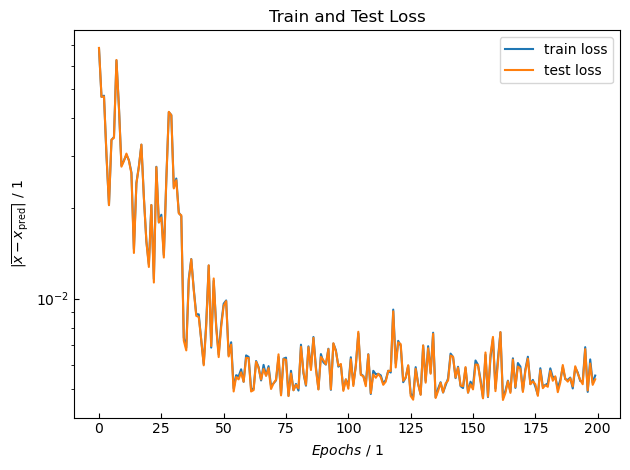

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\overline{x - x\mathregular{_{pred}}}$| / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9794645173206264 , R^2(NH3) = 0.9659518908786452
Test Dataset: R^2(H2) = 0.9733016822110918 , R^2(NH3) = 0.9662370692595073
Max Error Training: |x_H2 - x_H2,pred| = 0.16714432644422494 , |x_NH3 - x_NH3,pred| = 0.20341949250674224
Max Error Test: |x_H2 - x_H2,pred| = 0.15073868933900103 , |x_NH3 - x_NH3,pred| = 0.12889395923134758


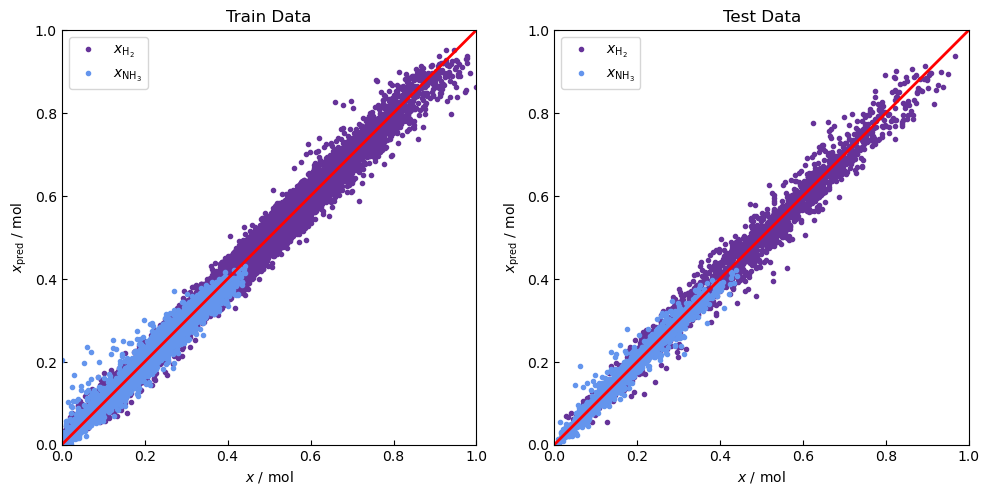

In [11]:
x_H2_real = []
x_H2_pred = []
x_NH3_real = []
x_NH3_pred = []
for (X,y) in train_dataloader:
    x_H2_real = np.append(x_H2_real, y[:,0].numpy())
    x_NH3_real = np.append(x_NH3_real, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred = np.append(x_H2_pred, help_x_H2)
    x_NH3_pred = np.append(x_NH3_pred, help_x_NH3)

x_H2_real_test = []
x_H2_pred_test = []
x_NH3_real_test = []
x_NH3_pred_test = []
for (X,y) in test_dataloader:
    x_H2_real_test = np.append(x_H2_real_test, y[:,0].numpy())
    x_NH3_real_test = np.append(x_NH3_real_test, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test = np.append(x_H2_pred_test, help_x_H2)
    x_NH3_pred_test = np.append(x_NH3_pred_test, help_x_NH3)

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

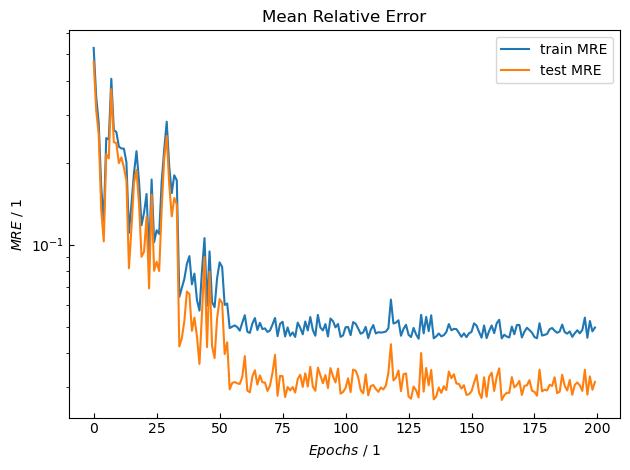

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_MRE, label='train MRE')
ax.semilogy(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

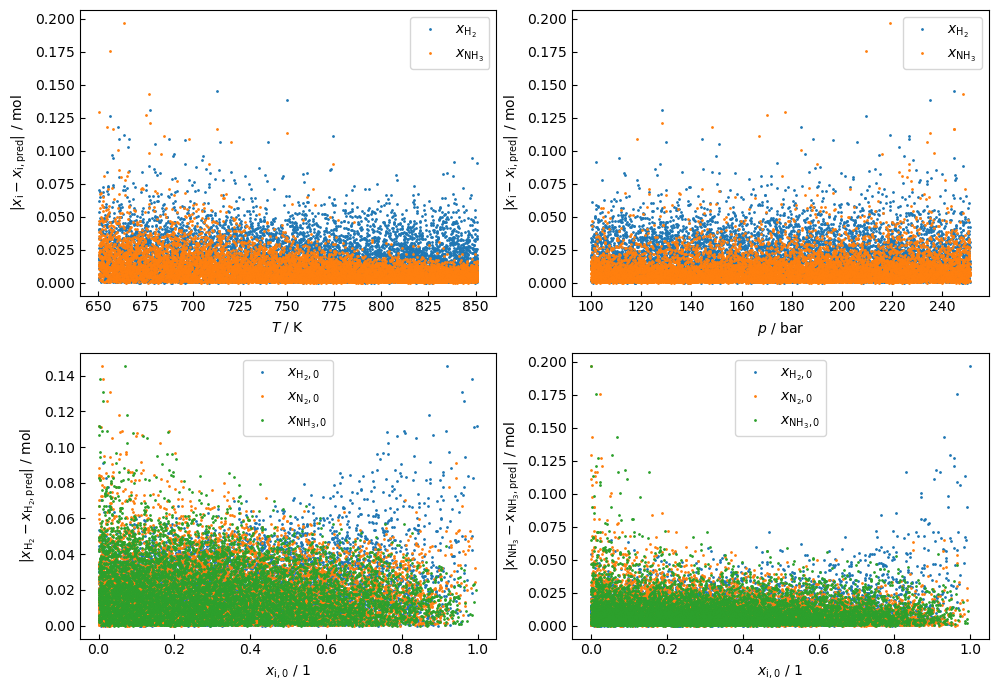

In [13]:
mistake_H2 = []
mistake_NH3 = []
param_T = []
param_p = []
param_x_H2_0 = []
param_x_N2_0 = []
param_x_NH3_0 = []
for X,y in train_dataloader:
    help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
    mistake_H2 = np.append(mistake_H2, help_mistake_H2)
    mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3)
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2_0 = np.append(param_x_H2_0, X[:,2])
    param_x_N2_0 = np.append(param_x_N2_0, X[:,3])
    param_x_NH3_0 = np.append(param_x_NH3_0, X[:,4])

# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].plot(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].plot(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].plot(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].plot(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].plot(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].plot(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].plot(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].legend()

ax[1,1].plot(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].plot(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].plot(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].legend()

plt.tight_layout()
plt.show()

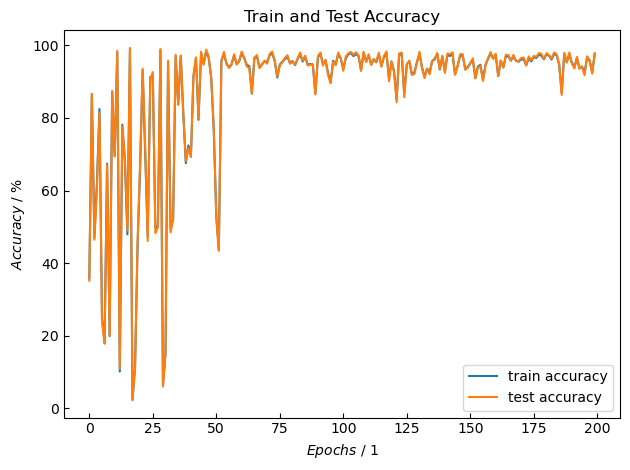

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[7.4104e+02, 2.2736e+02, 2.3881e-02, 3.1606e-01, 6.6006e-01],
        [8.4952e+02, 1.5828e+02, 8.3878e-01, 1.2057e-01, 4.0651e-02],
        [6.8619e+02, 2.2178e+02, 3.0536e-01, 5.2833e-01, 1.6631e-01],
        [6.7821e+02, 1.4111e+02, 7.6237e-02, 4.6922e-01, 4.5454e-01],
        [7.2105e+02, 1.8783e+02, 1.2850e-01, 8.4693e-01, 2.4562e-02],
        [8.2991e+02, 1.8272e+02, 5.5214e-01, 8.1851e-02, 3.6601e-01],
        [7.9161e+02, 1.8898e+02, 2.9252e-01, 5.0791e-01, 1.9957e-01],
        [6.8964e+02, 1.6694e+02, 5.2225e-01, 3.3148e-01, 1.4626e-01],
        [7.0047e+02, 1.5027e+02, 2.0421e-01, 2.1245e-01, 5.8334e-01],
        [6.6283e+02, 1.2023e+02, 1.2197e-01, 8.1860e-02, 7.9617e-01],
        [8.2036e+02, 1.4826e+02, 7.4226e-01, 2.6142e-02, 2.3159e-01],
        [7.0191e+02, 2.1503e+02, 1.3279e-01, 3.3374e-01, 5.3348e-01],
        [6.9265e+02, 1.8358e+02, 4.7331e-01, 3.2551e-01, 2.0118e-01],
        [8.5081e+02, 1.1043e+02, 3.4133e-01, 1.3575e-02, 6.4509e-01],
        [7.2086e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.2341, 0.1544, 0.2280, 0.3382, 0.2441], requires_grad=True),
 Parameter containing:
 tensor([ 0.0127, -0.0042, -0.0138, -0.0445,  0.0166], requires_grad=True),
 Parameter containing:
 tensor([[ 4.1868e-02, -1.0394e-02, -5.9688e-02, -4.2724e-02, -3.3014e-02],
         [ 6.7311e-03,  6.5876e-02,  7.0838e-02,  4.3512e-02,  6.4839e-02],
         [ 4.9320e-03,  1.0288e-01, -1.8880e-01, -1.3006e-01, -1.5001e-01],
         [-1.9679e-01, -2.8000e-01, -3.5358e-01, -2.3943e-01,  7.3113e-01],
         [ 1.3511e-02, -5.0675e-02,  1.5886e-02, -5.7555e-04,  1.5184e-02],
         [-9.7791e-02,  4.6012e-02, -1.3923e-01, -9.5147e-02, -1.5314e-01],
         [ 2.6016e-03,  4.9730e-02,  8.2792e-02,  5.5316e-02,  7.9274e-02],
         [ 1.0440e-03,  5.8979e-02, -4.7156e-02, -2.7519e-02, -3.1163e-02],
         [-4.4827e-04,  2.0669e-02,  5.1347e-02,  3.1133e-02,  3.9658e-02],
         [ 1.5119e-02,  1.4023e-02,  4.2979e-01,  2.8094e-01,  3.7250e-01],
         [-6.1360e-03,  

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0688, 0.7315, 0.8816, 0.3244, 0.2686],
        [0.5643, 0.3025, 0.1103, 0.1302, 0.4937]])
tensor([[0.3021, 0.2734],
        [0.6574, 0.0924]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[7.7818e+02, 1.2227e+02, 5.5762e-02, 9.0619e-01, 3.8046e-02],
        [7.2942e+02, 1.3952e+02, 2.1696e-01, 2.9640e-01, 4.8663e-01],
        [7.5639e+02, 1.2081e+02, 5.0778e-01, 1.5727e-02, 4.7649e-01],
        [7.6238e+02, 1.3190e+02, 6.4138e-03, 6.6466e-01, 3.2892e-01],
        [8.2124e+02, 2.1729e+02, 5.1938e-02, 5.7755e-01, 3.7051e-01],
        [7.1786e+02, 2.0218e+02, 3.6683e-01, 6.0108e-01, 3.2093e-02],
        [6.6149e+02, 1.3655e+02, 3.2842e-01, 3.3691e-01, 3.3466e-01],
        [6.9407e+02, 1.6962e+02, 4.5482e-01, 3.8991e-01, 1.5526e-01],
        [7.0384e+02, 1.2655e+02, 5.3555e-01, 1.3741e-01, 3.2703e-01],
        [7.6966e+02, 1.4262e+02, 3.2214e-01, 2.7180e-01, 4.0606e-01],
        [7.2439e+02, 1.4297e+02, 4.3660e-01, 4.8754e-01, 7.5862e-02],
        [7.2311e+02, 1.7321e+02, 8.0015e-01, 1.4261e-01, 5.7244e-02],
        [7.9068e+02, 1.6955e+02, 4.7775e-01, 2.3720e-01, 2.8505e-01],
        [8.1950e+02, 1.8925e+02, 4.8570e-01, 4.2593e-01, 8.8371e-02],
        [8.4310e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()